# Biblioth√®ques

In [123]:
import pandas as pd
pd.set_option('display.max_columns', 51)
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn : apprentissage automatique
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn import set_config # Pour afficher les pipelines
set_config(display='diagram')

# Mod√®les
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Learning curve avec yellowbrick
from yellowbrick.datasets import load_game
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ROCAUC

# Tests statistiques
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import norm, kurtosis
import pylab
from sklearn.feature_selection import SelectKBest, f_classif # Anova

# statmodel
import statsmodels.api as sm

import joblib 

import warnings
warnings.filterwarnings("ignore")

# Catalogue des fonctions

## Datavisualisation

In [4]:
# Datavisualisation

def analyse_dtypes_object(data):
    '''Modalit√©s pour les variables qualitatives tri√©es par nombre
    '''
    return data.select_dtypes(include=('object')).nunique().sort_values(ascending=False)


def analyse_dtypes_numeric(data):
    '''Modalit√©s pour les variables quantitatives tri√©es par nombre
    '''
    return data.select_dtypes(include=('integer', 'float')).nunique().sort_values(ascending=False)


def analyse_target(data):
    '''R√©partition en % des modalit√©s de la target
    '''
    number = data.readmitted.value_counts()
    percentage = data.readmitted.value_counts(normalize=True).round(3)*100
    analyse_target = {'number': number, '%': percentage}
    analyse_target_1 = pd.DataFrame(analyse_target)
    return analyse_target_1

def check_null_values(df):
    ''' Pourcentage de valeurs nulles par colonne
    '''
    nb_null = df.isnull().sum().sort_values(ascending=False).head(10)
    percentage_null = df.isnull().sum()*100/len(df)
    percentage_null = percentage_null.sort_values(ascending=False).head(10).round(1)
    null = {'nombre_null' : nb_null,'%_null' : percentage_null}
    data = pd.DataFrame(data = null)
    return data

def chi_2(col_1, col_2):
    table_diag = pd.crosstab(df[col_1], df[col_2], margins=True, margins_name='Total')
    chi_2, pvalue, degrees, expected = chi2_contingency(table_diag)
    print(f'Chi 2: {chi_2}, p_value: {pvalue}')

def map_missing_values(data):
    '''Cartographie des valeurs manquantes du dataset (couleur noire)
    '''
    plt.figure(figsize=(17,7))
    heatmap = sns.heatmap(data.isna(), cbar=False, cmap="Blues")
    heatmap.set_title('Heatmap des valeurs manquantes du dataset',
    fontdict={'fontsize':18}, pad=16);

def modalites(df):
    # Ajouter dans la fonction le param√®tre de colonne (si on veut n'en s√©lectionner qu'une)
    ''' Pour chaque colonne indique les modalit√©s et leur nombre
    '''
    for i in df.columns:
        print(f'{i}: {df[i].unique()}')
        print(f'Nb de modalit√©s : {df[i].value_counts().count()}\n')

        
def skewness(df):
    ''' Indique la nature de la distribution : normale, biais√©e, tr√®s biais√©e
        df peut se pr√©senter sous cette forme (df[['', '']])
    '''
    for col in df.columns:
        result = df[col].skew()
        print(f' Skewness of {col}: {result}')

## Preprocessing

In [14]:
def age_transform_to_numeric(df):
    '''Transforme la colonne √¢ge (en object par intervalle) par une variable num√©rique
       On calcule la moyenne des extr√™mes de l'intervalle. 
    '''
    df = df.replace({'age' : 
                            {'[0-10)' : 5, 
                             '[10-20)' : 15, 
                             '[20-30)' : 25, 
                             '[30-40)' : 35, 
                             '[40-50)' : 45,
                             '[50-60)' : 55,
                             '[60-70)' : 65,
                             '[70-80)' : 75,
                             '[80-90)' : 80, 
                             '[90-100)' : 95}
                            })
    return df



def columns_with_special_character(data, character = ''):
    ''' Retourne les colonnes pr√©sentant le caract√®re sp√©cial indiqu√©
    '''
    # Am√©liorer la fonction avec un print ("aucune colonne impact√©e")
    list = []
    [list.append(i) for i in data.columns if np.any(data[i] == character)]
    for i in list:
        number = data[i] == character
        total = number.sum()
        print(f'La colonne "{i}" en contient : {total}')

def diag_1_transform(df):
    ''' Transforme la colonne diag_1 en variable binaire
        Si le premier diagnotique est le diabete = 1, else = 0
    '''
    df['diag_1'].loc[df['diag_1'].str.startswith('250') == True] = 1
    df['diag_1'].loc[df['diag_1'].str.startswith('250') == False] = 0
    return df

        
        
def base_clean_dataset():
    '''Permet de r√©initialiser le dataset pr√©-nettoy√© √† chaque nouvelle it√©ration 
    '''
    data = pd.read_csv('diabetic_data_130US_hospital.csv', sep=';')
    data = data.replace({'?' : np.nan}).replace({'Unknown/Invalid' : np.nan})
    data = data.replace({'readmitted' : {'NO' : 0, '>30' : 1, '<30' : 1}})
    data = data.drop(columns=['encounter_id', 'patient_nbr'])
    data = age_transform_to_numeric(data)
    return data


def medical_transform(df):   
    if df['medical_specialty'] == 'InternalMedicine':
        return 'Internal medicine'
    elif df['medical_specialty'] == 'Emergency/Trauma':
        return 'Trauma'
    elif df['medical_specialty'] == 'Family/GeneralPractice':
        return 'General Practice'
    elif df['medical_specialty'] == 'Cardiology':
        return 'Cardiology'
    elif df['medical_specialty'] == 'Pediatrics-Endocrinology':
        return 'Endocrinology'
    elif df['medical_specialty'] == 'Endocrinology':
        return 'Endocrinology'
    elif df['medical_specialty'] == 'Endocrinology-Metabolism':
        return 'Endocrinology'
    elif df['medical_specialty'] == 'Inconnu':
        return 'Inconnu'
    else:
        return 'Autres'

def ordinal_encodage(df):
    ''' Encoder ordinalement (affecter un poids) aux variables s√©lectionn√©es
        @Retourne un df preprocess√©
    '''
    code = {'No': 0,
            'Yes': 1,
            'Ch': 1, 
            'None': 0,
            'Norm': 1,
            '>200': 2,
            '>300': 3,
            '>7': 2,
            '>8': 3,
            'Steady': 2,
            'Down': 1,
            'Up': 3        
           }

    for col in df[['change', 'diabetesMed', 'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'pioglitazone', 'rosiglitazone', 'insulin']]:
        df.loc[:, col] = df[col].map(code)
    
    return df


def preprocessing(df):
    '''Actionne toutes les √©tapes de preprocessing
       @Return le dataset en s√©parant les variables de la target
    '''
    df = null_cleaning(df)
    df = remove_outliers_dataset(df)
    df = logarithme(df)
    df = ordinal_encodage(df)
    df = feature_engineering(df)
    df = dummies_encodage(df)
#     df = standardisation(df)
                         
    X = df.drop(columns=['readmitted'], axis=1)
    y = df[['readmitted']]
    
    return X, y
    
def remove_outliers(df, col_name):
    ''' Supprime les outliers de la variable num√©rique indiqu√©e
    '''

    # D√©finit les percentiles 25% et 75% et calcule le IQR
    Q1 = np.percentile(df[col_name], 25)
    Q3 = np.percentile(df[col_name], 75)
    IQR = Q3 - Q1

    print("Old Shape: ", df.shape)

    # D√©tection des outliers (fourchette haute et basse)
    upper = np.where(df[col_name] >= (Q3+1.5*IQR))
    lower = np.where(df[col_name] <= (Q1-1.5*IQR))

    # Suppression des outliers

    df = df.reset_index(drop=True)  
    df = df.drop(upper[0], axis=0) 
    df = df.drop(lower[0],axis=0)
    
    print("New Shape: ", df.shape)
    return df

## Entrainement du mod√®le

In [43]:
def evaluation_cv(model, X, y):
    ''' Evalue toutes les m√©triques du mod√®le / Assez long √† ex√©cuter
        Score les 4 m√©triques : 'accuracy', 'recall', 'precision', 'f1'
        @Return scores en cv et la learning curve
    '''
    
    # Entra√Ænement du mod√®le
    model.fit(X, y)
    
    # M√©triques √† tester
    scoring = ['accuracy', 'recall', 'precision', 'f1']
    
    # Score des m√©triques
    for score in scoring: 
        print(f'Score {score} en cv : {cross_val_score(model, X, y, scoring = score, cv=5)}')
        print(f'Score {score} moyen en cv : {cross_val_score(model, X, y, scoring = score, cv=5).mean()}')
        print('')

    # Learning curve pour chacune des m√©triques 
    for score in scoring: 
        
        print(f'Pour {score} :')
        
        visualizer = LearningCurve(model, cv=5, train_sizes=np.linspace(0.1, 1, 10), n_jobs=4, 
                                   scoring = score)

        visualizer.fit(X, y) # Fit the data to the visualizer
        custum_title = visualizer.ax
        custum_title.set_title("Learning curve pour le score : {score}")
        visualizer.show() # Finalize and render the figure

        print('------------------------------------------------')
        
def evaluation_bis(model, X_train, y_train, X_test, y_test, scoring=''):
    ''' @Return classification report sur le test
        @Return learning curve en cv
    '''
    
    # Entra√Ænement du mod√®le
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    # Score synth√©tique des m√©triques sur le test   
    print("CLASSIFICATION REPORT SUR LE TEST\n")
    print(classification_report(y_test, ypred))
    
    # Learning curve en cross_validation pour le recall
    print(f"Learning curve en cross validation pour le {scoring}:")
    visualizer = LearningCurve(model, cv=5, train_sizes=np.linspace(0.1, 1, 10), n_jobs=4, 
                                   scoring = scoring)

    visualizer.fit(X_train, y_train) # Fit the data to the visualizer
    custum_title = visualizer.ax
    custum_title.set_title(scoring)
    visualizer.show() # Finalize and render the figure

# Import du dataset

In [ ]:
data = pd.read_csv('diabetic_data_130US_hospital.csv', sep=';')

In [ ]:
data.head()

# Principales informations

## Source et vue d'ensemble du dataset  

Ce dataset est h√©berg√© sur le site opensource du "Center for Machine Learning and Intelligent Systems" de l'Universit√© de Californie, qui regroupe des donn√©es permettant de faire du machine learning. 

Notre dataset traite du diab√®te et repr√©sente les donn√©es sur 10 ans (1999-2008), de 130 h√¥pitaux am√©ricains, des patients ayant √©t√© admis (patients hospitalis√©s) pour ce type de probl√®me : https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008

Le dataset compte 101766 exemples et 50 features. Chaque ligne correspond √† l'admission unique d'un patient. A noter qu'un patient peut √™tre admis plusieurs fois. Le nombre de patients total ayant √©t√© admis sur la p√©riode est de 71518. 


In [ ]:
data.shape

In [ ]:
data['encounter_id'].nunique(), data['patient_nbr'].nunique()

## Quelles sont mes variables ?

Le dataset pr√©sente des variables relatives aux caract√©ristiques physiques du patient, √† la nature de sa prise en charge m√©dicale (sp√©cialit√© du m√©decin, temps d'hospitalisation...), √† ses traitements m√©dicaux et √† ses r√©sultats de tests de sanguins : 

|Variable| |Description| |Remarques|
|--------| |----------- | |---------|
|encounter_id| |identifiant unique de l'admission| ||
|patient_nbr| |identifiant unique du patient| || 
|race| |Caucasian, AfricanAmerican, Other, Asian, Hispanic| ||
|gender| |homme ou femme| 
|age| |group√© par des intervalles de 10 ann√©es| ||
|weight| |poids du patient en livre| |A TRADUIRE EN KG|
|admission_type_id| |id correspondant √† 8 modalit√©s (Emergency, Urgent, Elective, Newborn, Not Available, NULL, Trauma Center, Not Mapped| |voir dans le d√©tail √† quoi cela correspond|
|discharge_disposition_id| |lieu de transfert apr√®s gu√©rison - 26 modalit√©s (voir fichier excel) - A la maison, dans un autre service, etc.| ||
|admission_source_id| |raison de l'admission (recommandation m√©dicale/urgence/enfant malade..) / 17 modalit√©s|   
|time_in_hospital| |nombre de jours entre l'admission et la sortie (va de 1 √† 14 jours)|
|payer_code| |unique ID assign√© √† chaque compagnie| |RETROUVER NOM ENTIER DE CHAQUE MODALITE|
|medical_specialty| |correspond √† la sp√©cialit√© du m√©decin qui a pris en charge le patient √† son arriv√©e - 73 modalit√©s|
|num_lab_procedures| |nombre de tests labo faits pendant l'hospitalisation||Analyses m√©dicales -> v√©rifier)
|num_procedures||nombre de proc√©dures (interventions) autre que les tests en labo|
|num_medications||nombre de type de m√©dicaments administr√©s durant le s√©jour hospitalier||
|number_outpatient||nombre de visites ambulatoires du patient dans l'ann√©e pr√©c√©dant la consultation (consultation externe/soins de ville)|
|number_emergency||nombre de visites aux urgences du patient dans l'ann√©e pr√©c√©dant la consultation|
|number_inpatient||nombre de visites hospitali√®res du patient dans l'ann√©e pr√©c√©dant la consultation|
|diag_1/2/3||premier, second et diagnostique additionnel. Correspond au code ICD9 (documentation pour la classification : https://www2.gov.bc.ca/gov/content/health/practitioner-professional-resources/msp/physicians/diagnostic-code-descriptions-icd-9)|
|number_diagnoses||nombre de diagnostics d√©clar√©s dans le syst√®me|
|max_glu_serum||4 modalit√©s - Glyc√©mie √† jeun||A v√©rifier|
|A1Cresult||HbA1c = h√©moglobine glyqu√©e|
|medications : de metformin √† metformin-pioglitazone||types de m√©dicaments pris avec 4 modalit√©s (r√©gulier, pas pris, augment√©, diminu√©)|
|change||indique s'il y a eu un changement dans la traitement pour le diab√®te, soit dans la posologie, soit dans le nom du m√©dicament|
|diabetesMed||prescription de m√©dicaments pour le diab√®te ou pas|
|readmitted||le patient a-t-il √©t√© r√©admis au bout de 30 jours max, √† plus de 30 jours ou pas r√©admis ?||target|

In [ ]:
# Nature et nombre de modalit√©s pour chacune des colonnes

modalites(data)

## La target : r√©admission ou non du patient

Notre target est la variable 'readmitted' : il s'agira de pr√©dire si, au regard des caract√©ristiques ci-dessus, le patient sera r√©admis ou non ult√©rieurement dans le service diab√©tologie.

Nous avons l√† deux possibilit√©s :  
    - effectuer une classification mutliclasse (dans ce cas, v√©rifier le d√©s√©quilibre des classes et le corriger avec la m√©thode Smote par exemple)   
    - rassembler la target en une variable binaire (0 = pas de r√©admission / 1 = r√©admission (>30 et <30))

In [ ]:
data.readmitted.value_counts().plot.pie()
plt.show()

# Traitement n√©cessaire avant exploration des donn√©es

## Analyse des caract√®res anormaux du dataframe

Nous observons deux types de donn√©es que nous qualifions d'anormaux : 
- des "?" que nous allons remplacer par des NaN 
- des "None" dont nous allons devoir analyser la nature et d√©terminer la signification

### Les points d'interrogation

In [ ]:
# Colonnes avec points d'interrogation

columns_with_special_character(data, '?')

In [ ]:
# Remplacement des ? par des nan

data = data.replace({'?' : np.nan})
columns_with_special_character(data, '?') # on v√©rifie qu'on n'a plus de colonnes impact√©es

### Gestion des valeurs "None"

In [ ]:
columns_with_special_character(data, 'None')

In [ ]:
data['max_glu_serum'].value_counts()

Les deux colonnes impact√©es par ces None concernent les prises de sang li√©es √† la mesure du glucose. Apr√®s v√©rification dans la litt√©rature et analyse de la variable, cela signifie que le test n'a pas √©t√© effectu√©. Cela est diff√©rent que de ne pas avoir la donn√©e (Nan). Le test n'a s√ªrement pas √©t√© r√©alis√© pour des raisons m√©dicales. Il est donc int√©ressant de conserver cette donn√©e comme modalit√© en tant que telle. En revanche, au regard du nombre important, il faudra √™tre attentif √† la fa√ßon dont g√©rer cette classe d√©s√©quilibr√©e et/ou l'encodage. 

### "Unknown/Invalid"

In [ ]:
columns_with_special_character(data, 'Unknown/Invalid')

Il n'y a que 3 modalit√©s, nous la qualifions en Nan et verrons plus tard si nous devons la supprimer ou l'encoder. 

In [ ]:
data = data.replace({'Unknown/Invalid' : np.nan})

## Suppression de l'Id

Variable integer inutile qui va parasiter notre mod√®le.

In [ ]:
data = data.drop(columns=['encounter_id'])

## V√©rification des doublons

On ne constate aucun doublon.

In [ ]:
data.duplicated(keep=False).sum()

## Encodage de la target

Notre int√©r√™t ici est de savoir si le patient, lors de son admission, sera de nouveau hospitalis√© ou non. Nous ne prenons pas en compte la granularit√© de temps (√† moins ou plus de 30 jours). Nous optons donc pour une variable binaire et non multiclasse.

In [ ]:
data = data.replace({'readmitted' : {'NO' : 0, '>30' : 1, '<30' : 1}})

In [ ]:
# nb d'exemples pour chaque modalit√© de la colonne readmitted

data.readmitted.value_counts(normalize=True)

# It√©ration 1 : baseline

**Objectif** : cr√©er un mod√®le pr√©dictif simple, bas√© sur une analyse exploratoire et une data pr√©paration sommaires afin de comprendre un peu mieux la structure du dataset et de pouvoir √©laborer une √©bauche de l'application demand√©e. 

In [ ]:
# Copie du dataset nettoy√© des informations inutiles

baseline = first_clean_dataset_create_copy()

## Analyse de forme des donn√©es

**- Target** : readmitted - la classe est √©quilibr√©e (0 : 53% / 1 : 46%)  
**- Lignes et colonnes** : 101766 lignes et  49 colonnes  
**- Types de variables** : int64 = 13, object = 36 dont 5 avec plus de 10 modalit√©s  
**- Valeurs manquantes**: 7 colonnes ont des valeurs manquantes dont 'weight' √† hauteur de 96%. 'medical_specialty' et 'payer_code' manquent respectivement √† 49% et 40%. 

### Structure du dataset

In [ ]:
# R√©partition des modalit√©s de la target 'readmitted'
  
analyse_target(baseline)

In [ ]:
# Nombre de Lignes et colonnes

baseline.shape

### Types de variables

A ce stade, nous avons 36 variables qualitatives dont 5 contiennent plus de 10 modalit√©s, et 13 quantitatives.  

In [ ]:
baseline.dtypes.value_counts()

In [ ]:
# R√©partition du type de variables

baseline.dtypes.value_counts().plot.pie()
plt.show()

In [ ]:
analyse_dtypes_object(baseline)

### Valeurs nulles

In [ ]:
# Cartographie des valeurs nulles 

map_missing_values(baseline)

In [ ]:
# Pourcentage de valeurs nulles

check_null_values(baseline)

7 colonnes ont des valeurs manquantes dont 'weight' √† hauteur de 96%. 'medical_specialty' et 'payer_code' manquent respectivement √† 49% et 40%.

## Pre-processing

### Suppression des valeurs nulles

Pour notre mod√®le experimental (baseline), nous d√©cidons de supprimer les colonnes qui ont plus de 30% de valeurs nulles (weight, medical_specialty, payer_code) et toutes les lignes poss√©dant au moins une valeur nulle. 
Notre dataset se compose d√©sormais de 98 052 exemples et 46 colonnes.

In [ ]:
# Suppression des colonnes ayant plus de 30% de valeurs nulles (isna)
# Suppression des lignes ayant au moins une valeur nulle(dropna)

baseline = baseline[baseline.columns[baseline.isna().sum()/baseline.shape[0] <0.3]]
baseline = baseline.dropna()

In [ ]:
check_null_values(baseline)

In [ ]:
baseline.shape

### Transformation de la variable "age"

La colonne "age" est class√©e selon un intervalle avec 10 modalit√©s (object). 
Point d'attention : cette donn√©e perd en qualit√© car on ne sait pas comment la donn√©e initiale a √©t√© transform√©e.  
Creuser pour savoir comment traiter une variable qui a √©t√© encod√©e selon un intervalle. En attendant, nous allons la transformer en variable num√©rique en prenant la moyenne des extr√™mes de l'intervalle. On aurait pu aussi envisager de faire un Ordinal encorder. 

In [ ]:
baseline = baseline.replace({'age' : 
                            {'[0-10)' : 5, 
                             '[10-20)' : 15, 
                             '[20-30)' : 25, 
                             '[30-40)' : 35, 
                             '[40-50)' : 45,
                             '[50-60)' : 55,
                             '[60-70)' : 65,
                             '[70-80)' : 75,
                             '[80-90)' : 80, 
                             '[90-100)' : 95}
                            })

In [ ]:
baseline['age'].dtypes

### S√©lection des variables et split

De notre baseline, nous voulions exclure :    
- les variables qui n'ont qu'une modalit√© (examide/citoglipton) car elles n'apportent rien au mod√®le
- les variables √† plus de 10 modalit√©s (diag_1/2/3) car elles vont cr√©er de multiples dimensions lors de l'encodage, ce qui peut √™tre lourd et et cr√©er du bruit dans notre algorithme de r√©gression logistique
- la variable "patient_nbr" qui est un ID unique

Et donc conserver certaines variables qualitatives (encod√©es). Or, cela perturbait notre mod√®le. Le temps d'ex√©cution √©tait tr√®s long et le score restait le m√™me avec ou sans. De ce fait, pour cette premi√®re it√©ration/baseline, je n'ai entrain√© mon mod√®le qu'avec les features num√©riques (hors discharge_disposition_id, admission_source_id, admission_type_id qui sont des integer mais correspondant √† des modalit√©s).  

In [ ]:
baseline = baseline.drop(columns=['diag_3', 'diag_2', 'diag_1', 'citoglipton', 'examide', 'metformin-rosiglitazone', 'patient_nbr'], axis=1)

In [ ]:
baseline.shape

In [ ]:
# Cr√©ation du X et du y avec les seules variables quantitatives

# X = baseline.drop(columns=['readmitted'], axis=1)
X = baseline[['time_in_hospital','num_lab_procedures','num_procedures','num_medications',
              'number_outpatient','number_emergency', 'number_inpatient', 'number_diagnoses','age']]
y = baseline[['readmitted']]

In [ ]:
# Split du dataset entre un jeu de donn√©es de train et de test

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=5, stratify=y)

print('Train set :', X_train.shape)
print('Test set :', X_test.shape)

### Encodage et normalisation (pipeline)

On cr√©e un pipeline de pr√©-processing de fa√ßon √† pouvoir transformer nos donn√©es plus facilement, et √©viter d'avoir de la fuite de donn√©es (dataleakage) ou des donn√©es mal transform√©es. 

Pour le variables cat√©gorielles, nous avions choisi d'utiliser le OneHotEncoder m√™me si apr√®s l'EDA, il sera certianement plus pertinent parfois de faire un OrdinalEncoder (mettre un poids en fonction du degr√© d'importance).

Dans notre baseline, nous n'avons que des variables num√©riques, que nous allons standardiser (moyenne de 0 et √©cart-type de 1). En effet, les algorithmes de r√©gression fonctionnent mieux sur des donn√©es standardis√©es. 

In [ ]:
# Distinction entre les variables num√©riques et cat√©gorielles

numerical_features = X.select_dtypes(include=['float', 'integer']).columns.values
categorical_features = X.select_dtypes(include=['object']).columns.values

In [ ]:
numerical_features

In [ ]:
# handle_unknown = 'ignore' : pallier au fait que nous n'avons pas dans le X_test le m√™me nombre de classes/modalit√©s

numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(OneHotEncoder(sparse = False,  handle_unknown = 'ignore'))

In [ ]:
# make_column_transformer : permet d'appliquer les transformers sur les colonnes qu'on s√©lectionne

preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                                   (categorical_pipeline, categorical_features))

In [ ]:
preprocessor

## Entrainement du mod√®le et score

### Choix th√©orique du mod√®le et des m√©triques de performance

#### La r√©gression logistique

Nous choisissons la r√©gression logistique binaire comme premier estimateur pour construire notre premier mod√®le, pour sa simplicit√© d'ex√©cution et de son interpr√©tation. L'algorithme va nous permettre d'estimer la probabilit√© qu'une observation appartienne √† la classe n√©gative 0 (proba inf. √† 50%) ou la classe positive 1 (prob sup. √† 50%).

#### Les m√©triques de performance choisies : fonctions co√ªt et algorithme de minimisation

Notre application d'aide √† la d√©cision m√©dicale a pour objectif de pr√©dire si un patient admis pour diab√®te sera de nouveau hospitalis√© ou non. L'int√©r√™t m√©dical est de pouvoir assurer un suivi particulier et d'√™tre vigilent envers les patients top√©s positif. 
Dans ce contexte, il nous faut donc √©viter les faux n√©gatifs : on ne veut pas pr√©dire qu'une personne ne retournera pas l'h√¥pital alors qu'elle reviendra. Il est pr√©f√©rable qu'on dise qu'elle vienne, m√™me si c'est une fausse alerte, plut√¥t que de penser qu'elle ne fera pas de nouveau une crise de diab√®te. Nous allons donc nous attacher √† obtenir un bon RECALL.   
En revanche, nous ne voulons pas non plus que les h√¥pitaux soient "surcharg√©s" par une masse de travail et un suivi pr√©cis de patients, donc il nous faut √©galement limiter les faux positifs. Nous veillerons donc √©galement √† obtenir une PRECISION convenable.  
Dans la mesure o√π nous avons besoin d'un rapport entre la precision et le recall honorable, nous avons tout int√©r√™t √† veiller √† ce que notre F1 SCORE soit optimis√© (il calcule le rapport moyen entre les 2 m√©triques gr√¢ce √† une moyenne harmonique).  
Enfin, nous serons attentifs √† l'ACCURACY, qui nous permettra de v√©rifier la part de bonnes pr√©dictions. 

S'agissant de l'algorithme qui va aider notre mod√®le √† minimiser cette fonction co√ªt, nous utiliserons pour le moment celle impl√©ment√©e dans le module Logistic Regression de Sklearn, qui est celle des moindres carr√©s. Au regard de la taille de notre dataset, nous envisagerons lors d'une seconde it√©ration d'appliquer le Stochastic Gradient Descent Classifier qui nous permettra d'appliquer l'algorithme de minimisation de la Descente de gradient et d'en ajuster les param√®tres.  

### Entra√Ænement & score en cross validation

#### Cr√©ation du mod√®le avec le pipeline de preprocessing

In [ ]:
# Choix du model et pipeline de pre-processing

model_rlog = make_pipeline(preprocessor, LogisticRegression(random_state = 5, solver='lbfgs')) # solver='lbfgs' mis suite √† message d'erreur

#### Evaluation du mod√®le et learning curve

In [ ]:
# Evaluation du mod√®le avec les 4 m√©triques et analyse de la learning curve

evaluation_cv(model_rlog, X_train, y_train.values.ravel())

**Recall**:    

Le score est de 0,39 en cross validation : pour toutes le observations actuellement positives (y_true), 39% ont √©t√© correctement classifi√©es. Ce qui est mauvais. L'objectif de la learning curve est de comprendre la structure de la donn√©e et d'avoir un train qui baisse (le mod√®le ne surapprend pas) et un test qui augmente (ce qui montre une bonne g√©n√©ralisation). Dans le cas du recall, on observe une convergence du train et du validation set √† mesure que la donn√©e augmente, ce qui pourrait supposer une bonne g√©n√©ralisation.

Les zones ombr√©es autour des courbes mettent en avant la variabilit√© (√©cart-type au dessus et en dessous de la moyenne). La variabilit√© semble l√©g√®rement plus grande autour du train, ce qui laisse supposer que nous avons un probl√®me de biais, confirm√© par les mauvais r√©sultats sur le train et le validation set. Nous avons de grandes erreurs sur les deux courbes, notre mod√®le ne parvient pas √† faire de relations pertinentes entre les donn√©es lorsqu'il s'agit de minimiser les faux n√©gatifs. A noter une plus grande variance encore sur le train en d√©but d'entrainement, pouvant s'expliquer par un manque de donn√©es. 

Notre mod√®le souffre d'underfitting. 

**Precision**:

Le score est de 0,69 : pour toutes les observations class√©es en positif, 69% sont corrects.  
Il est meilleur que le recall. Avec une learning curve qui se comporte √† peu pr√®s de la m√™me fa√ßon que le recall. Notre mod√®le souffre de biais et est en underfitting.  

**Accuracy** :

Notre mod√®le explique √† 61% la variance de notre target. Il est honorable mais doit √™tre am√©lior√© et ne peut √™tre consid√©r√© comme fiable. 


**Conclusion** : 
Notre mod√®le g√®re mieux les pr√©dictions lorsqu'il s'agit de minimiser les faux positifs, c'est √† dire pr√©dire qu'une personne reviendra en hospitalisation alors que ce ne sera pas le cas. Nous voulons atteindre cet objectif mais pas prioritairement, nous allons donc nous attacher √† am√©liorer le score en recall. 
Il souffre clairement d'underfitting, ne parvenant pas √† saisir les patterns de notre mod√®le.

**Pistes d'am√©lioration √† envisager** :
- optimiser les hyperparam√®tres afin de mieux "guider" l'algorithme ou choisir un mod√®le plus puissant avec plus de param√®tres
- fournir davantage de variables au mod√®le 
- fournir de meilleures variables √† l'algorithme d'apprentissage (voir les transformations possibles) gr√¢ce √† l'exploration des donn√©es (EDA)

- la regression logistique √©tant un mod√®le param√©trique, il conviendrait de v√©rifier que les principaux pr√©suppos√©s sont bien respect√©s, notamment la normalit√© et homosc√©dasticit√© des r√©sidus

#### Matrice de confusion en cv

La matrice de confusion permet de comparer les r√©sultats du mod√®le (pr√©dictions) avec les valeurs r√©elles. 
Chaque ligne du tableau correspond √† la classe r√©elle et chaque colonne √† la classe pr√©dite. 

In [ ]:
y_pred_cv = cross_val_predict(model_rlog, X_train, y_train.values.ravel(), cv=5)
y_pred_cv

In [ ]:
# Confusion matrix (on compare y_true et y_pred)
# Question : est-ce judicieux de faire la confusion matrix avec le y_train (non cross√© et le y_pred_cv) ?

conf_cv = pd.DataFrame(confusion_matrix(y_train, y_pred_cv))
conf_cv = conf_cv.rename(columns={0: 'Predicted 0',1:'Predicted 1'})
conf_cv= conf_cv.rename(index={0: 'Actual 0',1:"Actual 1"})
conf_cv 

Notre mod√®le fait de grosses erreurs lorsqu'il s'agit de pr√©dire les vrais positifs : il a pr√©dit que 22175 personnes ne seraient pas r√©hospitalis√©es alors que c'est le cas. Cela corrobore notre mauvais score sur le recall.  

#### Classification report

In [ ]:
# Classification report (classification_report(y_true, y_pred))

print(classification_report(y_train, y_pred_cv))

Interpr√©tation du recall pour les 0 : parmi les observations actuellement n√©gatives, 81% ont √©t√© correctement classifi√©es par mon mod√®le.  

### Score sur le train et le test

#### Score

In [ ]:
# Faire fonction o√π on fit/score/classification report/pr√©diction ? 

In [ ]:
# Entrainement
model_rlog.fit(X_train, y_train.values.ravel()) 

In [ ]:
# score sur le test

score_test = model_rlog.score(X_test,y_test)
score_test

In [ ]:
# Classification report sur le test

y_pred = model_rlog.predict(X_test)
print(classification_report(y_test, y_pred))

#### Courbe AUC/ROC

Elle met en corr√©lation le taux de faux positifs et le taux de vrais positifs.
Elle repr√©sente la performance attendue pour une estimation totalement al√©atoire pour chaque patient, ce qui reviendrait √† tirer √† pile ou face : on peut s'attendre √† un r√©sultat correct dans la moiti√© des cas et incorrect dans l'autre moiti√©. La zone sous la ligne diagonale repr√©sente donc un AUC de 0.5. Si l‚ÄôAUC est sup√©rieure √† O.5 pour un mod√®le de classification binaire, alors il est plus performant qu‚Äôune estimation al√©atoire. La zone sous la courbe est une mesure de discrimination : plus elle est important, plus le mod√®le est capable de pr√©voir correctement la valeur de la r√©ponse de l'observation.

In [ ]:
visualizer = ROCAUC(model_rlog, classes=["non_rehospitalis√©", "rehospitalis√©"])

visualizer.fit(X_train, y_train)       
visualizer.score(X_test, y_test)      
visualizer.show()  

Notre mod√®le est consid√©r√© comme plus performant qu'une simple pr√©diction al√©atoire car sup√©rieur √† 0.5. N√©anmoins, √©tant inf√©rieur √† 0.7, on en conclut qu'il ne fournit pas de discrimination appropri√©e, suffisante.  

### Score sur l'ensemble du data set

In [ ]:
# model.fit(X, y)

model_rlog.fit(X,y.values.ravel())

In [ ]:
model_rlog.score(X, y)

### Predict

In [ ]:
# Renvoie la prediction du label en fonction de X

y_hat = model_rlog.predict(X)
y_hat

In [ ]:
# Renvoie une probabilit√© pour chaque label
# Interpr√©tation : L'item 25 a 56% d'appartenir √† la classe 0 et 43% d'appartenir √† la classe 1.

y_hat_proba = model_rlog.predict_proba(X)
y_hat_proba

## Pistes d'am√©lioration pour les it√©rations suivantes

Pour le choix du mod√®le : 
- la regression logistique √©tant un mod√®le param√©trique, il conviendrait de v√©rifier que les principaux pr√©suppos√©s :
    - √©chantillon repr√©sentatif
    - absence de multicolin√©arit√© (tests avec le VIF par exemple)
    - normalit√© des r√©sidus (voir comment afficher les r√©sidus d'une classification binaire)
    - homosc√©dasticit√© des erreurs (variance)
- √† d√©faut, utiliser un mod√®le non param√©trique tel que le DecisionTreeClassifier : si on obtient les m√™mes scores, on en d√©duit que les pr√©suppos√©s de la r√©gression logisitique sont r√©unis
- si la question des pr√©suppos√©s est remplie, tester le SGD Classifier afin d'utiliser un mod√®le plus puissant qui permet d'appliquer la Descente de Gradient (stochastique). Par ailleurs, ce mod√®le est recommand√© pour les datasets dont le nombre d'exemples est sup√©rieur √† 100000. 

Pour enrayer l'underfiting : 
- optimiser les hyperparam√®tres afin de mieux "guider" l'algorithme 
- choisir un mod√®le plus puissant avec plus de param√®tres (SDG Classifier ou XGBoost Classifier)
- fournir davantage de variables au mod√®le
- fournir de meilleures variables √† l'algorithme d'apprentissage (voir les transformations possibles) gr√¢ce √† l'exploration des donn√©es (EDA)



## Sauvegarde du mod√®le avec Joblib

D'apr√®s la documentation Sklearn (https://scikit-learn.org/stable/model_persistence.html), Joblib est plus efficace que piclke quand il s'agit de sauvegarder des mod√®les bas√©s sur des algorithmes qui ont de nombreux param√®tres et qui reposent sur de grands datasets. 

In [ ]:
import joblib 

In [ ]:
# Sauvegarde du mod√®le sous le fichier nomm√© 'model_joblib'

joblib.dump(model, 'model_joblib')

In [ ]:
# Lecture du mod√®le enregistr√© dans le fichier

model_joblib = joblib.load('model_joblib')

In [ ]:
# Visualisation du mod√®le tel qu'il a √©t√© enregistr√©

model_joblib

In [ ]:
# Test de prediction ave le mod√®le encapsul√© dans le fichier joblib

prediction_joblib = model_joblib.predict(X)
prediction_joblib

# It√©ration 2

## EDA

In [5]:
df = base_clean_dataset()

In [7]:
df.head()

race  gender  age weight  admission_type_id  \
0        Caucasian  Female    5    NaN                  6   
1        Caucasian  Female   15    NaN                  1   
2  AfricanAmerican  Female   25    NaN                  1   
3        Caucasian    Male   35    NaN                  1   
4        Caucasian    Male   45    NaN                  1   

   discharge_disposition_id  admission_source_id  time_in_hospital payer_code  \
0                        25                    1                 1        NaN   
1                         1                    7                 3        NaN   
2                         1                    7                 2        NaN   
3                         1                    7                 2        NaN   
4                         1                    7                 1        NaN   

          medical_specialty  num_lab_procedures  num_procedures  \
0  Pediatrics-Endocrinology                  41               0   
1                       NaN                  59               0   
2                       NaN                  11               5   
3                       NaN                  44               1   
4                       NaN                  51               0   

   num_medications  number_outpatient  number_emergency  number_inpatient  \
0                1                  0                 0                 0   
1               18                  0                 0                 0   
2               13                  2                 0                 1   
3               16                  0                 0                 0   
4                8                  0                 0                 0   

   diag_1  diag_2 diag_3  number_diagnoses max_glu_serum A1Cresult metformin  \
0  250.83     NaN    NaN                 1          None      None        No   
1     276  250.01    255                 9          None      None        No   
2     648     250    V27                 6          None      None        No   
3       8  250.43    403                 7          None      None        No   
4     197     157    250                 5          None      None        No   

  repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide  \
0          No          No             No          No            No        No   
1          No          No             No          No            No        No   
2          No          No             No          No            No    Steady   
3          No          No             No          No            No        No   
4          No          No             No          No            No    Steady   

  glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol  \
0        No          No           No            No       No       No   
1        No          No           No            No       No       No   
2        No          No           No            No       No       No   
3        No          No           No            No       No       No   
4        No          No           No            No       No       No   

  troglitazone tolazamide examide citoglipton insulin glyburide-metformin  \
0           No         No      No          No      No                  No   
1           No         No      No          No      Up                  No   
2           No         No      No          No      No                  No   
3           No         No      No          No      Up                  No   
4           No         No      No          No  Steady                  No   

  glipizide-metformin glimepiride-pioglitazone metformin-rosiglitazone  \
0                  No                       No                      No   
1                  No                       No                      No   
2                  No                       No                      No   
3                  No                       No                      No   
4                  No                       No                    

In [8]:
df.shape

(101766, 48)

### Analyse de forme

- Identification de la target : readmitted
- Nb lignes et colonnes : 101766 lignes et 49 colonnes
- Types de variables : 13 variables quantitatives et 36 cat√©gorielles. Il va √™tre indispensable d'analyser plus pr√©cis√©ment les variables cat√©gorielles en termes d'encodage et de s√©lection car elles vont grandement influencer notre mod√®le. 
=> au regard du nombre important de features, il peut √™tre int√©ressant dans un premier temps de mesure la variance des num√©riques et cat√©gorielles afin de ne s√©lectionner que celles qui vont nous donner de l'information (VarianceThreshold() de sklearn pour les num√©riques et Anova pour les cat√©gorielles).
- Identification des valeurs manquantes : 
    - pas bcp de colonnes avec des Nan
    - colonne "weight" >96% de Nan
    - "3 diag" √† analyser pour voir s'il existe une logique dans les NAN car correspondent √† des diagnostiques additionnels
    - payer_code"/medical_specialty : 40% / 50% de Nan => voir si relation entre l'assurance et la sp√©cialit√© du m√©decin

In [9]:
df.dtypes.value_counts()

object    35
int64     13
dtype: int64

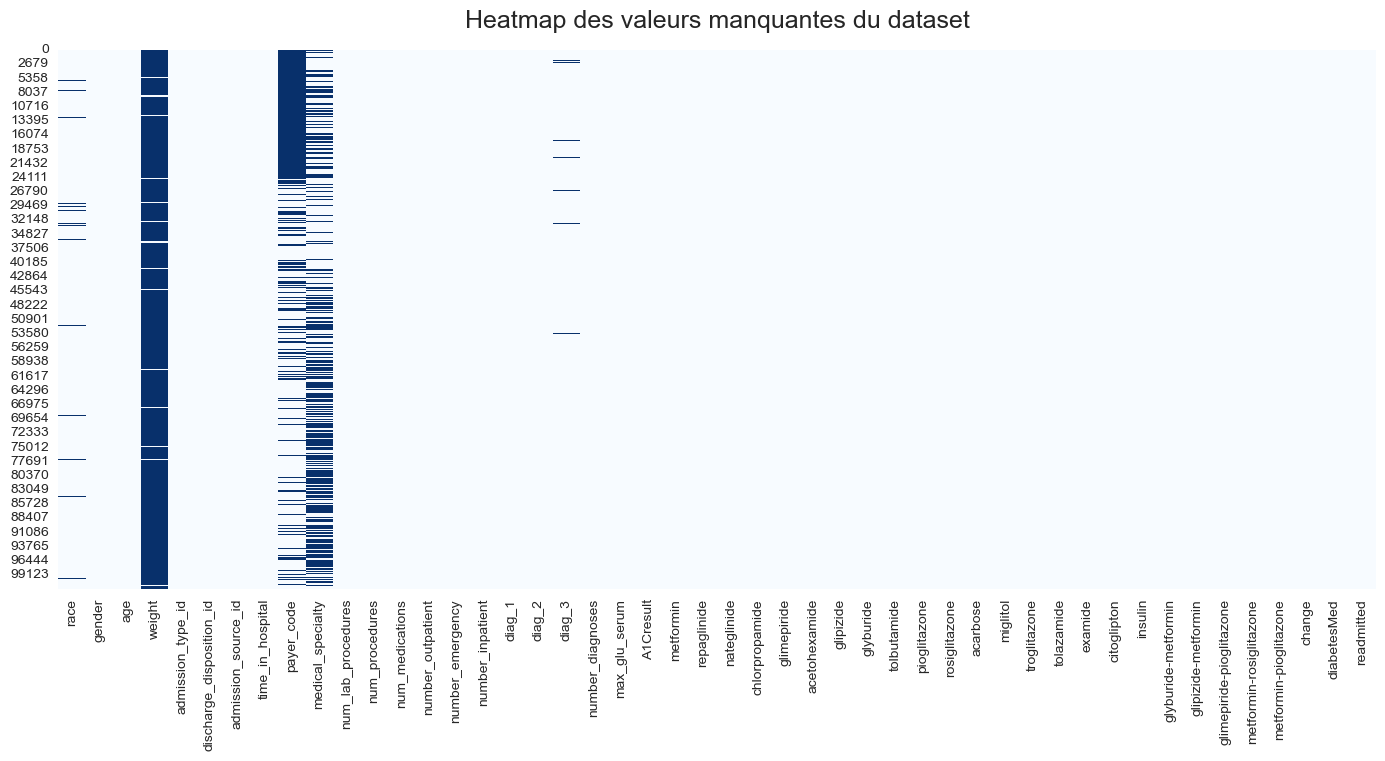

In [10]:
map_missing_values(df)

**Interpr√©tation:**    

Valeurs manquantes (en noir):  
- Pas beaucoup de valeurs manquantes, sauf pour la colonne weight > 96% => sera √† supprimer.  
- les 3 diag n'ont seulement que quelques valeurs manquantes => voir si cela est normal dans la hi√©rarchie et la compr√©hension de la variable (diag1, puis diag2 puis diag3) => dropna ?
- payer code : 40% de valeurs nulles => Khi2 qui montre corr√©lation avec la target => analyser comment g√©rer les valeurs nulles (suppression ou remplacement ?)
- medical_specialty ont quasiment le m√™me nombre de valeurs nulles => voir s'il existe une relation entre elles (quand figuration ainsi, souvent c'est qu'il y a une relation - cf. Machine Learnia)
- genre et race comportent un petit pourcentage de valeurs nulles que l'on pourra supprimer

In [11]:
check_null_values(df)

nombre_null  %_null
weight                   98569    96.9
medical_specialty        49949    49.1
payer_code               40256    39.6
race                      2273     2.2
diag_3                    1423     1.4
diag_2                     358     0.4
diag_1                      21     0.0
gender                       3     0.0
tolazamide                   0     0.0
tolbutamide                  0     0.0

### Analyse de fond

#### Elimination des colonnes inutiles

In [12]:
# Suppression des colonnes avec valeurs nulles > 90%  => colonne weight

df = df[df.columns[df.isna().sum()/df.shape[0] <0.9]]

In [13]:
df.shape

(101766, 47)

On est pass√© de 48 √† 47 colonnes. 

In [14]:
df.head()

race  gender  age  admission_type_id  discharge_disposition_id  \
0        Caucasian  Female    5                  6                        25   
1        Caucasian  Female   15                  1                         1   
2  AfricanAmerican  Female   25                  1                         1   
3        Caucasian    Male   35                  1                         1   
4        Caucasian    Male   45                  1                         1   

   admission_source_id  time_in_hospital payer_code         medical_specialty  \
0                    1                 1        NaN  Pediatrics-Endocrinology   
1                    7                 3        NaN                       NaN   
2                    7                 2        NaN                       NaN   
3                    7                 2        NaN                       NaN   
4                    7                 1        NaN                       NaN   

   num_lab_procedures  num_procedures  num_medications  number_outpatient  \
0                  41               0                1                  0   
1                  59               0               18                  0   
2                  11               5               13                  2   
3                  44               1               16                  0   
4                  51               0                8                  0   

   number_emergency  number_inpatient  diag_1  diag_2 diag_3  \
0                 0                 0  250.83     NaN    NaN   
1                 0                 0     276  250.01    255   
2                 0                 1     648     250    V27   
3                 0                 0       8  250.43    403   
4                 0                 0     197     157    250   

   number_diagnoses max_glu_serum A1Cresult metformin repaglinide nateglinide  \
0                 1          None      None        No          No          No   
1                 9          None      None        No          No          No   
2                 6          None      None        No          No          No   
3                 7          None      None        No          No          No   
4                 5          None      None        No          No          No   

  chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide  \
0             No          No            No        No        No          No   
1             No          No            No        No        No          No   
2             No          No            No    Steady        No          No   
3             No          No            No        No        No          No   
4             No          No            No    Steady        No          No   

  pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamide  \
0           No            No       No       No           No         No   
1           No            No       No       No           No         No   
2           No            No       No       No           No         No   
3           No            No       No       No           No         No   
4           No            No       No       No           No         No   

  examide citoglipton insulin glyburide-metformin glipizide-metformin  \
0      No          No      No                  No                  No   
1      No          No      Up                  No                  No   
2      No          No      No                  No                  No   
3      No          No      Up                  No                  No   
4      No          No  Steady                  No                  No   

  glimepiride-pioglitazone metformin-rosiglitazone metformin-pioglitazone  \
0                       No                      No                     No   
1                       No                      No                     No   
2                       No                      No                     No   
3                       No                      No

#### Analyse de la target

In [15]:
analyse_target(df)

number     %
0   54864  53.9
1   46902  46.1

Nos classes sont bien √©quilibr√©es. 

#### Analyse univari√©e des variables num√©riques

In [16]:
analyse_dtypes_numeric(df)

num_lab_procedures          118
num_medications              75
number_outpatient            39
number_emergency             33
discharge_disposition_id     26
number_inpatient             21
admission_source_id          17
number_diagnoses             16
time_in_hospital             14
age                          10
admission_type_id             8
num_procedures                7
readmitted                    2
dtype: int64

##### Variables continues

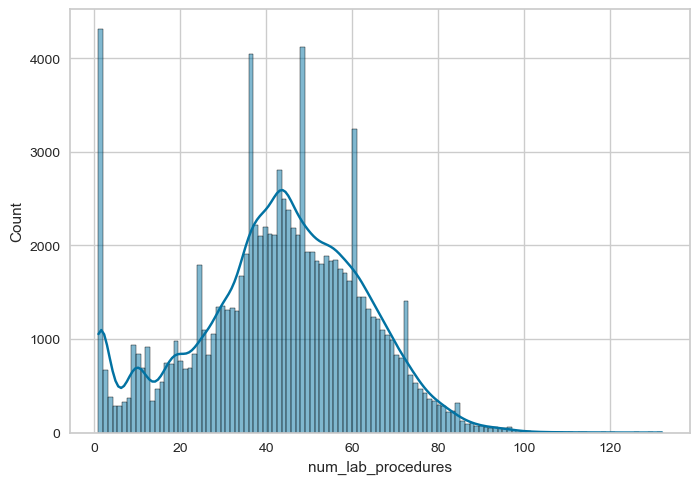

In [17]:
# "num_lab_procedures" (Nombre de tests de laboratoire effectu√©s pendant l'admission)

sns.histplot(df['num_lab_procedures'], kde = True, bins=120)
plt.show()

La distribution semble suivre la loi normale car nous pouvons observer une belle courbe en cloche avec cependant la pr√©sence des valeurs aberrantes en d√©but de courbe et en queue de distribution, biais√©e vers la droite. 
On constate la pr√©sence de palliers lorsque l'on configure les bins (intervalles) √† 120 : ce qui pourrait laisser penser que le nombre de proc√©dures a peut-√™tre parfois √©t√© arrondi lors du remplissage de la donn√©e (mais nous ne pouvons en √™tre certain puisque nous n'avons pas les m√©thodes de collecte √† notre disposition).  
On remarque par ailleurs, qu'au moins une analyse en laboratoire est effectu√©e puisque la distribution et le describe montre que la valeur minimum est 1. 

Au regard de cette distribution, deux id√©es nous viennent : 
- g√©rer les palliers et les outliers en faisant du feature engineering (en cr√©ant des classes) 
- supprimer les outliers en queue de distribution √† droite afin de normaliser au mieux la distribution

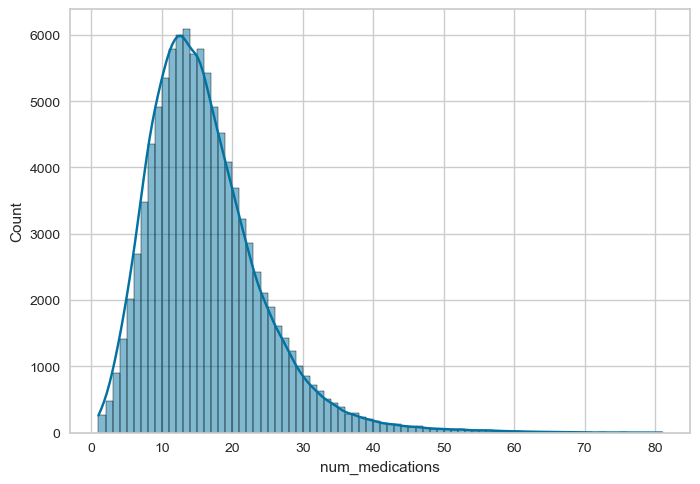

In [18]:
# "num medications" (nombre de type de m√©dicaments administr√©s durant le s√©jour hospitalier)

sns.histplot(df['num_medications'], kde = True, bins=80)
plt.show()

Cette distribution suit la loi normale mais est biais√©e √† droite (skewed) montrant la pr√©sence d'outliers, qu'il conviendrait de supprimer aussi. En effet, notre mod√®le param√©trique est sensible aux outliers, ce qui risquera de biaiser notre mod√®le. Nous souhaitons g√©n√©raliser au mieux et non d√©tecter des comportements anormaux. Il conviendra alors de le supprimer. 

In [19]:
continuous_variables = df[['num_lab_procedures', 'num_medications']]
continuous_variables.describe()

num_lab_procedures  num_medications
count       101766.000000    101766.000000
mean            43.095641        16.021844
std             19.674362         8.127566
min              1.000000         1.000000
25%             31.000000        10.000000
50%             44.000000        15.000000
75%             57.000000        20.000000
max            132.000000        81.000000

##### Variables discr√®tes

In [20]:
analyse_dtypes_numeric(df)

num_lab_procedures          118
num_medications              75
number_outpatient            39
number_emergency             33
discharge_disposition_id     26
number_inpatient             21
admission_source_id          17
number_diagnoses             16
time_in_hospital             14
age                          10
admission_type_id             8
num_procedures                7
readmitted                    2
dtype: int64

In [21]:
# On s√©lectionne les variables discr√®tes
variables_discrete = df[['number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'time_in_hospital', 'age', 'num_procedures']]

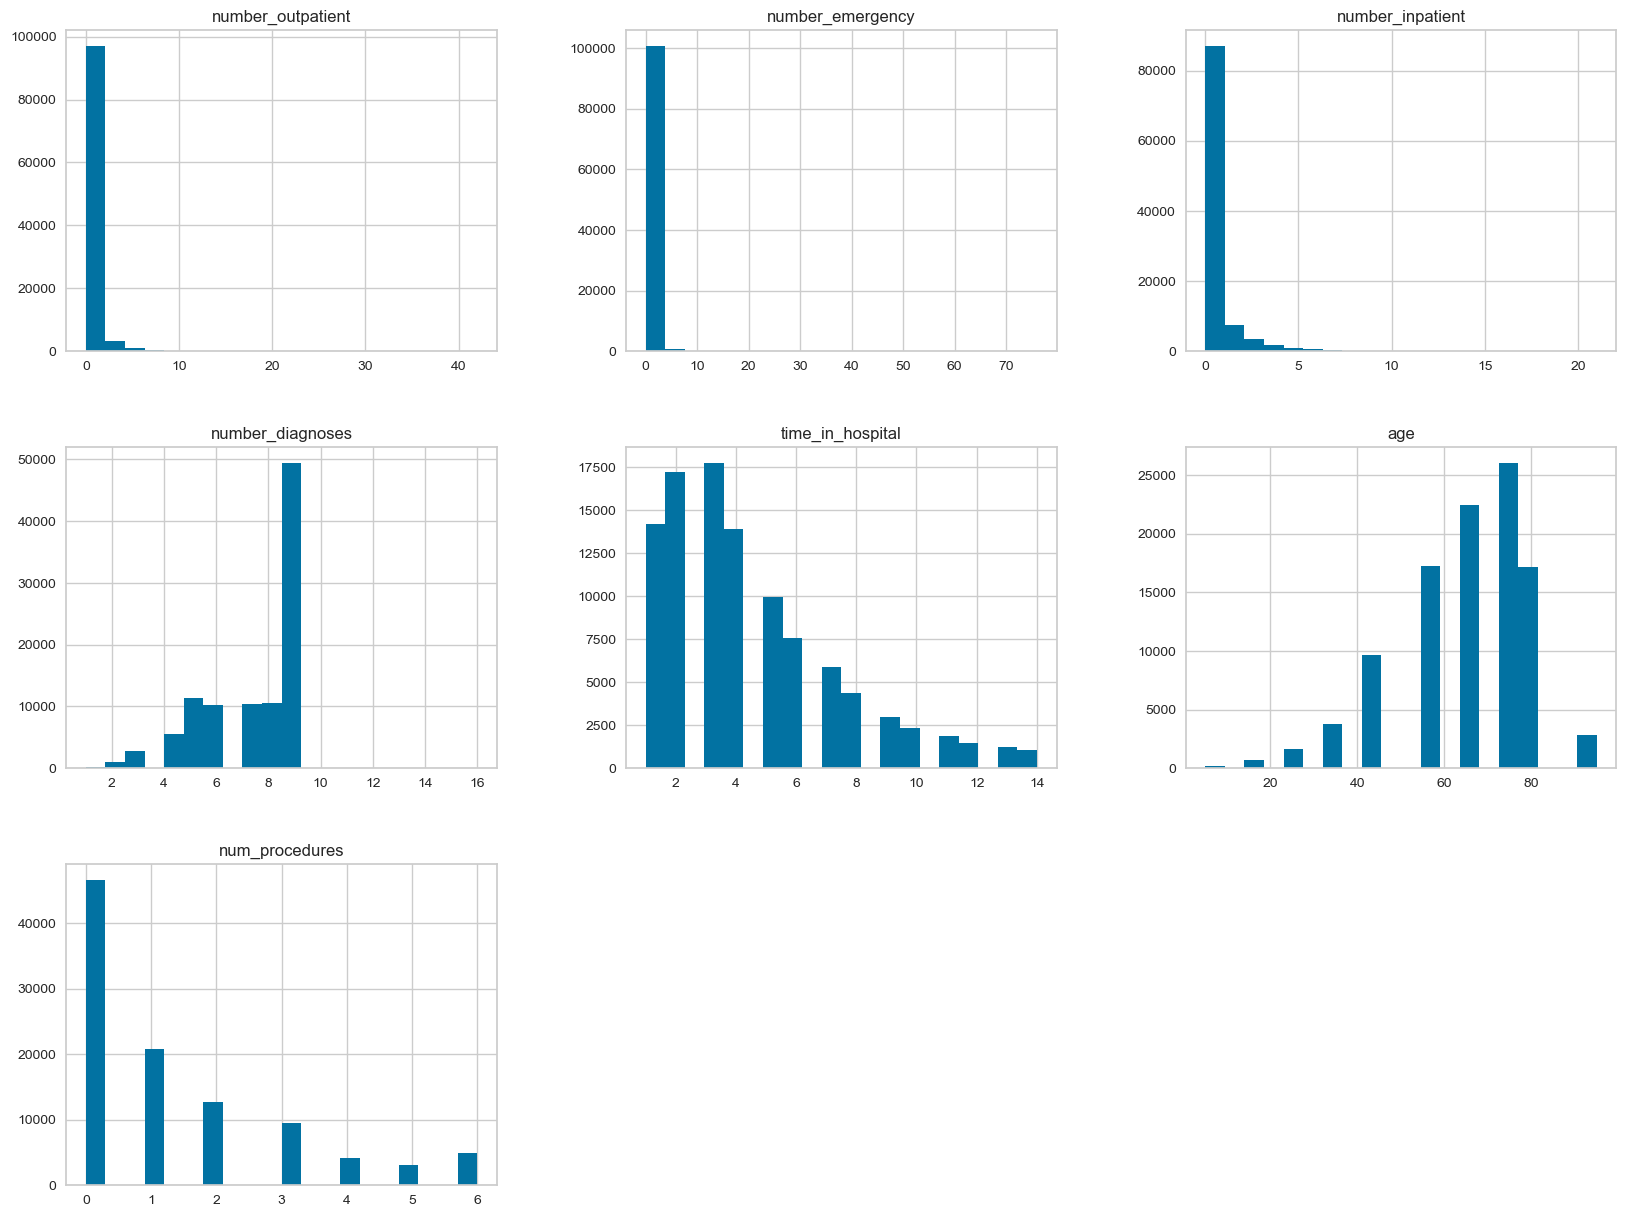

In [22]:
variables_discrete.hist(bins=20, figsize=(20,15))
plt.show()

**'number_outpatient', 'number_emergency', 'number_inpatient'**

La distribution des trois premi√®res variables (number_outpatient, number_emergency, number_inpatient) qui correspondent, en termes de connaissance m√©tier, au nombre de visites m√©dicales qu'a eues le patient l'ann√©e pr√©c√©dente, est concentr√©e autour du z√©ro avec des outliers importants. Nous faisons un describe() pour analyser plus dans le d√©tail la r√©partition en termes de quartiles. En effet, la variance est quasi-nulle, l'√©cart-type, qui rend compte de la dispersion des donn√©es, est tr√®s faible. La fonction VarianceThreshold avec un seuil √† 3 corrobe notre hypoth√®se. 

Voir G√©ron p 48 pour explication de l'√©cart type et de la loi normale. 

In [23]:
variables_discrete.describe()

number_outpatient  number_emergency  number_inpatient  \
count      101766.000000     101766.000000     101766.000000   
mean            0.369357          0.197836          0.635566   
std             1.267265          0.930472          1.262863   
min             0.000000          0.000000          0.000000   
25%             0.000000          0.000000          0.000000   
50%             0.000000          0.000000          0.000000   
75%             0.000000          0.000000          1.000000   
max            42.000000         76.000000         21.000000   

       number_diagnoses  time_in_hospital            age  num_procedures  
count     101766.000000     101766.000000  101766.000000   101766.000000  
mean           7.422607          4.395987      65.122094        1.339730  
std            1.933600          2.985108      15.015251        1.705807  
min            1.000000          1.000000       5.000000        0.000000  
25%            6.000000          2.000000      55.000000        0.000000  
50%            8.000000          4.000000      65.000000        1.000000  
75%            9.000000          6.000000      75.000000        2.000000  
max           16.000000         14.000000      95.000000        6.000000

In [24]:
from sklearn.feature_selection import VarianceThreshold

In [25]:
selector = VarianceThreshold(threshold=2)
learn_variance = selector.fit(variables_discrete)
variance_result = learn_variance.get_support()
variance_result

array([False, False, False,  True,  True,  True,  True])

La fonction get_support() renvoit en fait un vecteur de booleen. Si la valeur est True cel√† signifie que la colonne peut √™tre conserv√©e, dans le cas contraire la variance de la colonne doit √™tre supprim√©e. Pour savoir si la colonne doit √™tre supprim√©e la fonction calcule la variance de la colonne et la compare √† un seuil. Par d√©faut le seuil est √† z√©ro. Cela signifie que seules les colonnes √† variance nulle (c‚Äôest √† dire celles qui ont une valeur constante) seront supprim√©es.

**number_diagnoses**  
Cette variable pr√©sente √©galement des outliers et semble avoir √©t√© plafonn√©e √† 9 : en effet, 75% des patients ont eu 9 diagnostics ou moins. Pour analyser √† quel point la distribution est biais√©e, nous essayer de mesurer le degr√© d'asy√©mtrie gr√¢ce √† l'indicateur skew. 

Le skew est un coefficient de mesure du degr√© d'asym√©trie de la distribution : 
*   Distribution normale : compris entre -0,5 et 0,5
*   Donn√©es mod√©r√©ment biais√©es : compris entre -1 et -0,5 ou 0,5 et 1
*   Donn√©es sont fortement biais√©es : inf√©rieur √† -1 ou sup√©rieure √† 1

L'asym√©trie nous renseigne sur la direction de la valeur aberrante. 

In [26]:
skewness(df[['number_diagnoses']])

 Skewness of number_diagnoses: -0.8767462388449531


Le r√©sultat du coefficient montre que les donn√©es sont mod√©r√©ment biaisi√©es vers la gauche.  
Voyons le r√©sultat en √¥tant les outliers.

In [27]:
df_remove_outl = remove_outliers(df, 'number_diagnoses')

Old Shape:  (101766, 47)
New Shape:  (101485, 47)


In [28]:
skewness(df_remove_outl[['number_diagnoses']])

 Skewness of number_diagnoses: -0.9039106216137414


Apr√®s avoir √¥t√© les outliers, la variable est toujours mod√©rement biais√©e, mais un peu moins.  
Tentons de transformer avec le logarithme.

In [29]:
df_log = np.log(df['number_diagnoses'])

In [30]:
df_log.skew()

-1.741746664928519

Passer la variable en logarithme n'aide pas la distribution √† mieux se comporter => nous allons donc nous contenter de supprimer les outliers. 

**time_in_hospital et num_procedures**   

Elles pr√©sentent une distribution clairement biais√©e √† droite qu'il conviendrait de normaliser si nous devons appliquer des tests statistiques qui requi√®rent la loi normale. Nous pouvons appliquer une transformation logarithmique (attention √† l'interpr√©tation des donn√©es en visualisation si on doit l'analyser car modifie l'√©chelle).

*time_hospital*

In [31]:
# On v√©rifie le score skew pour ces deux variables

skewness(df[['time_in_hospital','num_procedures']])

 Skewness of time_in_hospital: 1.133998719333879
 Skewness of num_procedures: 1.3164147632805119


Le skewness sup√©rieur √† 1, ce qui montre une distribution fortement biais√©e pour les deux variables. 

On passe en logarithme la feature 'time_in_hospital'. Nous ne pouvons pas proc√©der de m√™me avec 'num_procedures' parce que nous avons des valeurs nulles.

In [32]:
df_log_time = np.log(df['time_in_hospital'])

In [33]:
df_log_time.skew()

-0.2041595502088673

Le logarithme a permis de normaliser la distribution car le skew est d√©sormais compris entre -0,5 et 0,5. 

*num_procedures*

*avec Kurtosis

In [34]:
df['num_procedures'].kurtosis()

0.857110302059521

Plus il est proche de 0, et plus il approche la loi normale. 
Testons de nous en rapprocher en supprimant les outliers. 

In [35]:
test_remove_outliers = remove_outliers(df, 'num_procedures')

Old Shape:  (101766, 47)
New Shape:  (93734, 47)


In [36]:
skewness(test_remove_outliers[['num_procedures']])

 Skewness of num_procedures: 1.023699439233688


In [37]:
test_remove_outliers['num_procedures'].kurtosis()

-0.07486480673726437

Les donn√©es sont un peu moins biais√©es mais on s'√©loigne quand m√™me de la loi normale => voir si nous avons un int√©r√™t √† garder cette feature. 

*Avec Jarque_bera_test

La normalit√© nous permet de savoir si nous aurons un bon intervalle de confiance pour avoir des pr√©visions le plus fiable possible. On utilise le test Jarque Bera en positionnant que l'hypoth√®se nulle est que la variable suit la normalit√©. 

In [38]:
from scipy import stats

In [39]:
data = df['num_procedures']

In [40]:
jarque_bera_test = stats.jarque_bera(data)
jarque_bera_test

Jarque_beraResult(statistic=32505.976129570914, pvalue=0.0)

In [41]:
jarque_bera_test.statistic

32505.976129570914

In [42]:
jarque_bera_test.pvalue

0.0

La p_value est inf√©rieure √† 5%, on rejette alors l'hypoth√®se nulle, la variable ne suit pas la loi normale. 
Testons le jarque sur la variable d√©pourvue de ses outliers. 

In [43]:
jarque_bera_test_2 = stats.jarque_bera(test_remove_outliers['num_procedures'])
jarque_bera_test_2

Jarque_beraResult(statistic=16392.989814286517, pvalue=0.0)

Le r√©sultat est toujours identique, la variable ne suit pas la loi normale.  
Nous d√©cidons donc pour le moment de la supprimer de notre mod√®le param√©trique car nous ne parvenons pas √† la normaliser. 

**age**  
Le distribution de √¢ge semble suivre une repr√©sentation gaussienne, en d√©montre le describe. Nous avons un √©cart-type √©lev√© et une m√©diane qui est √©gale √† la moyenne (65 ans). L'√¢ge moyen des personnes hospitalis√©es pour diab√®te est de 65 ans. 

In [44]:
df['age'].describe()

count    101766.000000
mean         65.122094
std          15.015251
min           5.000000
25%          55.000000
50%          65.000000
75%          75.000000
max          95.000000
Name: age, dtype: float64

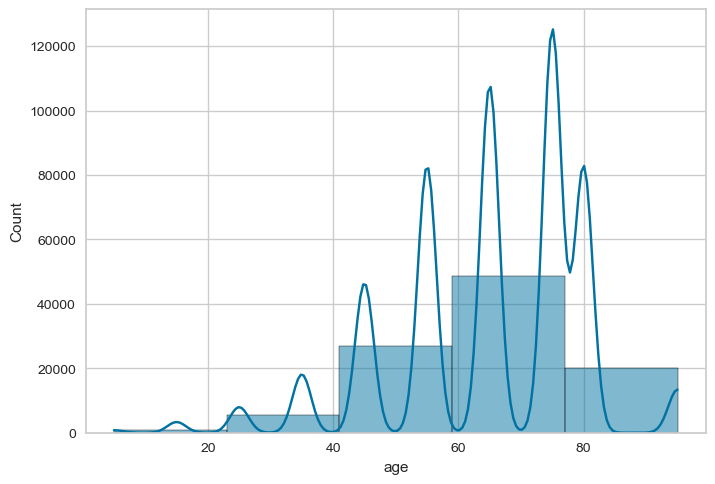

In [45]:
plt.figure()
sns.histplot(df['age'], kde = True, bins=5)
plt.show()

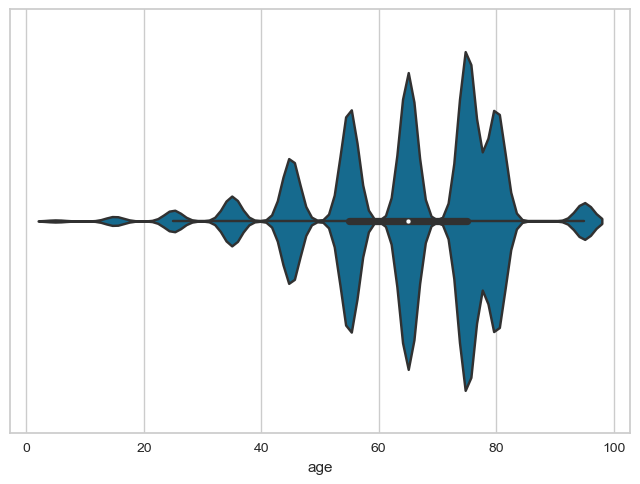

In [46]:
sns.violinplot(x=df['age'])
plt.show()

In [47]:
skewness(df[['age']])

 Skewness of age: -0.7917159691309223


Le score du skew montre tout de m√™me des donn√©es l√©g√®rement biais√©es. Nous pouvons r√©tablir cela en supprimant les outliers. 

In [48]:
test_remove_outl_age = remove_outliers(df, 'age')

Old Shape:  (101766, 47)
New Shape:  (99257, 47)


In [49]:
skewness(test_remove_outl_age[['age']])

 Skewness of age: -0.43330666916849647


Oter les outliers nous a permis de normaliser les donn√©es. 

##### Variables num√©riques ID qui correspondent √† des modalit√©s

In [50]:
analyse_dtypes_numeric(df)

num_lab_procedures          118
num_medications              75
number_outpatient            39
number_emergency             33
discharge_disposition_id     26
number_inpatient             21
admission_source_id          17
number_diagnoses             16
time_in_hospital             14
age                          10
admission_type_id             8
num_procedures                7
readmitted                    2
dtype: int64

**discharge_disposition_id**

Cette variable indique le lieu de sortie du patient : maison, maison avec soins, h√¥pital, etc. 

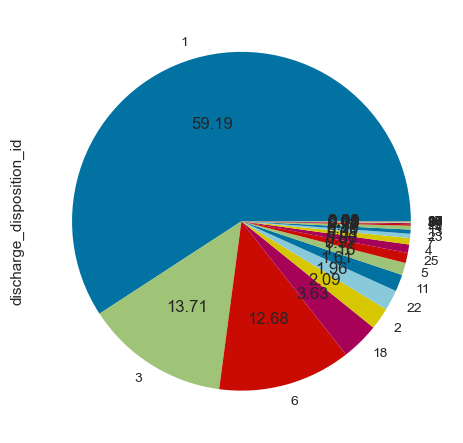

In [51]:
df['discharge_disposition_id'].value_counts().plot.pie(autopct='%.2f')
plt.show()

1,Discharged to home
2,Discharged/transferred to another short term hospital
3,Discharged/transferred to SNF
4,Discharged/transferred to ICF
5,Discharged/transferred to another type of inpatient care institution
6,Discharged/transferred to home with home health service
7,Left AMA
8,Discharged/transferred to home under care of Home IV provider
9,Admitted as an inpatient to this hospital
10,Neonate discharged to another hospital for neonatal aftercare
11,Expired
12,Still patient or expected to return for outpatient services
13,Hospice / home
14,Hospice / medical facility
15,Discharged/transferred within this institution to Medicare approved swing bed
16,Discharged/transferred/referred another institution for outpatient services
17,Discharged/transferred/referred to this institution for outpatient services
18,NULL
19,"Expired at home. Medicaid only, hospice."
20,"Expired in a medical facility. Medicaid only, hospice."
21,"Expired, place unknown. Medicaid only, hospice."
22,Discharged/transferred to another rehab fac including rehab units of a hospital .
23,Discharged/transferred to a long term care hospital.
24,Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.
25,Not Mapped
26,Unknown/Invalid
30,Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere
27,Discharged/transferred to a federal health care facility.
28,Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital
29,Discharged/transferred to a Critical Access Hospital (CAH).

=> ce qui vient √† l'id√©e est de transformer la variable en bianire (0 = rentr√© √† la maison sans soins particuliers (n¬∞1) / 1 (les autres) = prise en charge √† domicile ou hospitali√®re) qui formerait une variable √† deux classes assez √©quilibr√©es 
=> voir ensuite au niveau de la visualisation si on a une variabilit√© avec les readmissions ou non

In [52]:
def discharge_disposition_transform(df):   
    if df['discharge_disposition_id'] == 1:
        return 0
    else:
        return 1

In [53]:
df['discharge_disposition_transform'] = df.apply(discharge_disposition_transform, axis=1)

In [54]:
df.head(2)

race  gender  age  admission_type_id  discharge_disposition_id  \
0  Caucasian  Female    5                  6                        25   
1  Caucasian  Female   15                  1                         1   

   admission_source_id  time_in_hospital payer_code         medical_specialty  \
0                    1                 1        NaN  Pediatrics-Endocrinology   
1                    7                 3        NaN                       NaN   

   num_lab_procedures  num_procedures  num_medications  number_outpatient  \
0                  41               0                1                  0   
1                  59               0               18                  0   

   number_emergency  number_inpatient  diag_1  diag_2 diag_3  \
0                 0                 0  250.83     NaN    NaN   
1                 0                 0     276  250.01    255   

   number_diagnoses max_glu_serum A1Cresult metformin repaglinide nateglinide  \
0                 1          None      None        No          No          No   
1                 9          None      None        No          No          No   

  chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide  \
0             No          No            No        No        No          No   
1             No          No            No        No        No          No   

  pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamide  \
0           No            No       No       No           No         No   
1           No            No       No       No           No         No   

  examide citoglipton insulin glyburide-metformin glipizide-metformin  \
0      No          No      No                  No                  No   
1      No          No      Up                  No                  No   

  glimepiride-pioglitazone metformin-rosiglitazone metformin-pioglitazone  \
0                       No                      No                     No   
1                       No                      No                     No   

  change diabetesMed  readmitted  discharge_disposition_transform  
0     No          No           0                                1  
1     Ch         Yes           1                                0

**admission_source_id** 

Correspond au type de service dans lequel le patient a √©t√© admis en premier lieu. 

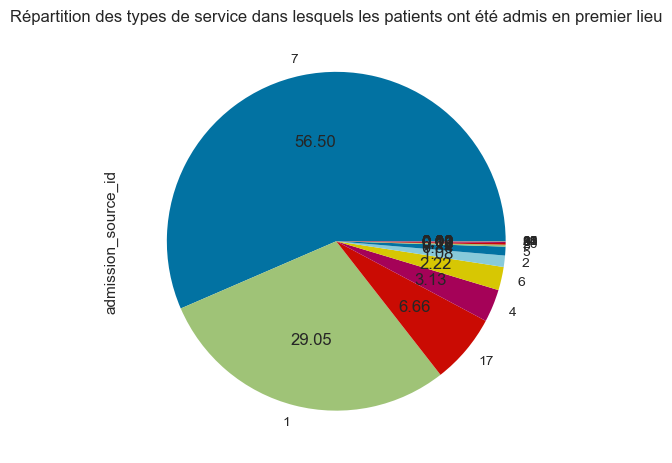

In [55]:
df['admission_source_id'].value_counts().plot.pie(autopct='%.2f', title='R√©partition des types de service dans lesquels les patients ont √©t√© admis en premier lieu')
plt.show()

LE 7 correspond aux urgences, le 1 = venue sur recommandation/prescription m√©dicale (= int√©ressant en termes de sens)  
=> cr√©er une variable √† 3 modalit√©s : urgences, recommandation m√©dicale et autres  
            => voir la variabilit√© en fonction de la r√©hospitalisation ou non

In [56]:
def admission_source_transform(df):   
    if df['admission_source_id'] == 7:
        return 'Urgences'
    elif df['admission_source_id'] == 1:
        return 'Prescription medicale'
    else:
        return 'Autres'

In [57]:
df['admission_source_transform'] = df.apply(admission_source_transform, axis=1)

In [ ]:
df.head(2)

**admission_type_id**  
Correspond √† la raison pour laquelle le patient a √©t√© admis : recommandation m√©dicale, urgence, enfant malade...

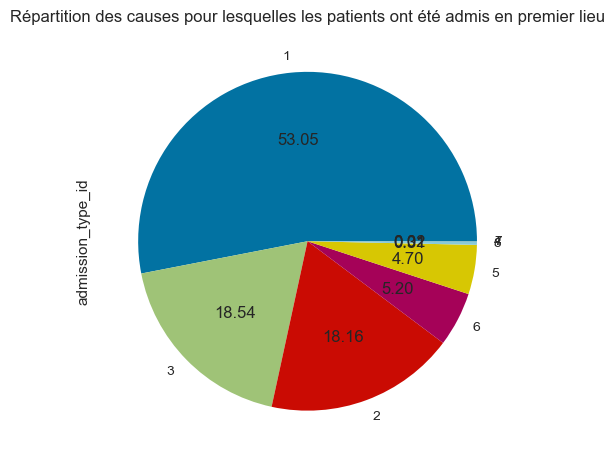

In [58]:
df['admission_type_id'].value_counts().plot.pie(autopct='%.2f', title='R√©partition des causes pour lesquelles les patients ont √©t√© admis en premier lieu')
plt.show()

Le 1 = urgence, le 2 = urgent et le 3 = facultatif => ne comprend pas cette variable et n'ai pas trouv√© de documentation sur le sujet donc pour l'instant, on la met de c√¥t√©. 

#### Analyse univari√©e des variables cat√©gorielles

In [59]:
analyse_dtypes_object(df)

diag_3                        789
diag_2                        748
diag_1                        716
medical_specialty              72
payer_code                     17
race                            5
glyburide-metformin             4
acarbose                        4
rosiglitazone                   4
pioglitazone                    4
insulin                         4
glyburide                       4
glipizide                       4
nateglinide                     4
glimepiride                     4
chlorpropamide                  4
repaglinide                     4
metformin                       4
A1Cresult                       4
max_glu_serum                   4
miglitol                        4
tolazamide                      3
admission_source_transform      3
troglitazone                    2
gender                          2
acetohexamide                   2
glipizide-metformin             2
glimepiride-pioglitazone        2
metformin-rosiglitazone         2
metformin-piog

**diag 1 / 2 / 3** 

Nous allons conserver les premiers et troisi√®mes diagnostics afin d'identifier si nous avons une diff√©rence entre les deux et une incidence sur le fait que le patient sera r√©hospitalis√© ou non. 
Il sera int√©ressant dans un second temps de cr√©er un nouvelle variable qui permettra de d√©terminer s'il y avait une diff√©rence de diagnotique entre les 1 et 3.   
Au regard du nombre important de modalit√©s (716), il convient de faire du feature engineering. Nous allons nous aider du classement officiel ICD-9 sur lequel repose ces codes qui correspondent au "Diagnostic Code Descriptions" https://www2.gov.bc.ca/gov/content/health/practitioner-professional-resources/msp/physicians/diagnostic-code-descriptions-icd-9

In [60]:
df['diag_1'].value_counts()

428    6862
414    6581
786    4016
410    3614
486    3508
       ... 
817       1
61        1
148       1
870       1
V51       1
Name: diag_1, Length: 716, dtype: int64

In [61]:
# On drop les Nan
df.dropna(subset='diag_1', inplace=True)
df['diag_1'].isnull().sum()

0

In [63]:
# On drop les Nan
df.dropna(subset='diag_3', inplace=True)
df['diag_3'].isnull().sum()

0

In [64]:
# Variable binaire = bon diagnostic de d√©part en diabete (1) et les autres (0)

df['diag_1'].loc[df['diag_1'].str.startswith('250') == True] = 1
df['diag_1'].loc[df['diag_1'].str.startswith('250') == False] = 0
df['diag_3'].loc[df['diag_3'].str.startswith('250') == True] = 1
df['diag_3'].loc[df['diag_3'].str.startswith('250') == False] = 0

In [65]:
df['diag_3'].value_counts()

0    83169
1    17154
Name: diag_3, dtype: int64

In [66]:
df['diag_1'].value_counts()

0    92186
1     8137
Name: diag_1, dtype: int64

**medical specialty**  

In [67]:
df['medical_specialty'].value_counts()

InternalMedicine                    14391
Emergency/Trauma                     7511
Family/GeneralPractice               7304
Cardiology                           5324
Surgery-General                      3028
                                    ...  
Speech                                  1
Pediatrics-InfectiousDiseases           1
Perinatology                            1
Neurophysiology                         1
Surgery-PlasticwithinHeadandNeck        1
Name: medical_specialty, Length: 72, dtype: int64

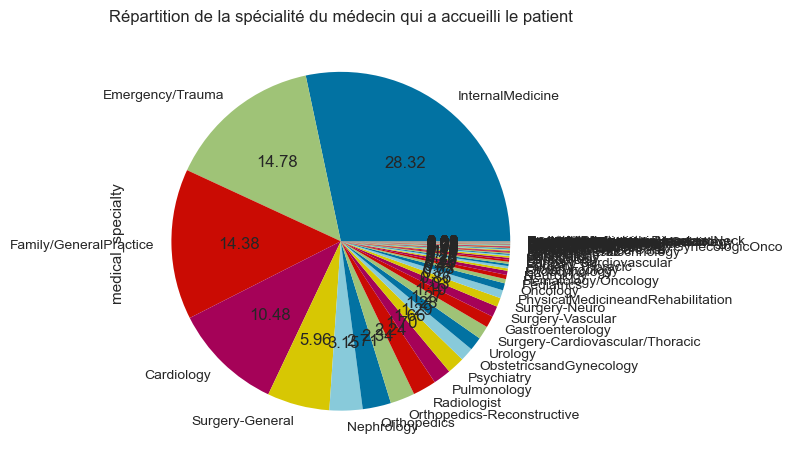

In [68]:
df['medical_specialty'].value_counts().plot.pie(autopct='%.2f', title='R√©partition de la sp√©cialit√© du m√©decin qui a accueilli le patient')
plt.show()

Au regard du nombre important de modalit√©s, il convient de proc√©der √† une transformation. En analysant le nombre total d'observations par modalit√©s, nous constatons que des cat√©gories √©mergent. 
Nous d√©cidons de conserver les cat√©gories suivantes : 
- InternalMedicine
- Emergency/Trauma 
- Family/GeneralPractice 
- Cardiology 
- Surgery-General 
- Endocrinology (car m√™me s'il est peu repr√©sent√©, il concerne la sp√©cialit√© m√©dicale qui traite des probl√®mes de diab√®te)
- Autres
- Inconnu pour les valeurs nulles

En effet, nous allons toper les valeurs nulles par 'Inconnu', √† d√©faut de supprimer cette variable car nous avons beaucoup de valeurs nulles, et les supprimer nous ferait perdre beaucoup d'information. Par ailleurs, indiquer "Inconnu" peut avoir du sens en terme de connaissance m√©tier : soit on n'a pas eu le temps de r√©cup√©rer l'information, soit on ne connaissait vraiment pas la sp√©cialit√© ou le service auquel √©tait rattach√© le m√©decin (dans ce cas, les r√©sultats montreront peut-√™tre qu'il conviendrait de d√©terminer la sp√©cialit√© du m√©decin d√®s le d√©part).  

In [69]:
df.head()

race  gender  age  admission_type_id  discharge_disposition_id  \
1        Caucasian  Female   15                  1                         1   
2  AfricanAmerican  Female   25                  1                         1   
3        Caucasian    Male   35                  1                         1   
4        Caucasian    Male   45                  1                         1   
5        Caucasian    Male   55                  2                         1   

   admission_source_id  time_in_hospital payer_code medical_specialty  \
1                    7                 3        NaN               NaN   
2                    7                 2        NaN               NaN   
3                    7                 2        NaN               NaN   
4                    7                 1        NaN               NaN   
5                    2                 3        NaN               NaN   

   num_lab_procedures  num_procedures  num_medications  number_outpatient  \
1                  59               0               18                  0   
2                  11               5               13                  2   
3                  44               1               16                  0   
4                  51               0                8                  0   
5                  31               6               16                  0   

   number_emergency  number_inpatient diag_1  diag_2 diag_3  number_diagnoses  \
1                 0                 0      0  250.01      0                 9   
2                 0                 1      0     250      0                 6   
3                 0                 0      0  250.43      0                 7   
4                 0                 0      0     157      1                 5   
5                 0                 0      0     411      1                 9   

  max_glu_serum A1Cresult metformin repaglinide nateglinide chlorpropamide  \
1          None      None        No          No          No             No   
2          None      None        No          No          No             No   
3          None      None        No          No          No             No   
4          None      None        No          No          No             No   
5          None      None        No          No          No             No   

  glimepiride acetohexamide glipizide glyburide tolbutamide pioglitazone  \
1          No            No        No        No          No           No   
2          No            No    Steady        No          No           No   
3          No            No        No        No          No           No   
4          No            No    Steady        No          No           No   
5          No            No        No        No          No           No   

  rosiglitazone acarbose miglitol troglitazone tolazamide examide citoglipton  \
1            No       No       No           No         No      No          No   
2            No       No       No           No         No      No          No   
3            No       No       No           No         No      No          No   
4            No       No       No           No         No      No          No   
5            No       No       No           No         No      No          No   

  insulin glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
1      Up                  No                  No                       No   
2      No                  No                  No                       No   
3      Up                  No                  No                       No   
4  Steady                  No                  No                       No   
5  Steady                  No                  No                       No   

  metformin-rosiglitazone metformin-pioglitazone change diabetesMed  \
1                      No                     No     Ch         Yes   
2                      No                     No     No         Yes   
3                      No                     No 

In [70]:
# Remplace les valeurs nulles par 'Inconnu'
df = df.replace({'medical_specialty' : {np.nan : 'Inconnu'}})
df.head(10)

race  gender  age  admission_type_id  discharge_disposition_id  \
1         Caucasian  Female   15                  1                         1   
2   AfricanAmerican  Female   25                  1                         1   
3         Caucasian    Male   35                  1                         1   
4         Caucasian    Male   45                  1                         1   
5         Caucasian    Male   55                  2                         1   
6         Caucasian    Male   65                  3                         1   
7         Caucasian    Male   75                  1                         1   
8         Caucasian  Female   80                  2                         1   
9         Caucasian  Female   95                  3                         3   
10  AfricanAmerican  Female   45                  1                         1   

    admission_source_id  time_in_hospital payer_code medical_specialty  \
1                     7                 3        NaN           Inconnu   
2                     7                 2        NaN           Inconnu   
3                     7                 2        NaN           Inconnu   
4                     7                 1        NaN           Inconnu   
5                     2                 3        NaN           Inconnu   
6                     2                 4        NaN           Inconnu   
7                     7                 5        NaN           Inconnu   
8                     4                13        NaN           Inconnu   
9                     4                12        NaN  InternalMedicine   
10                    7                 9        NaN           Inconnu   

    num_lab_procedures  num_procedures  num_medications  number_outpatient  \
1                   59               0               18                  0   
2                   11               5               13                  2   
3                   44               1               16                  0   
4                   51               0                8                  0   
5                   31               6               16                  0   
6                   70               1               21                  0   
7                   73               0               12                  0   
8                   68               2               28                  0   
9                   33               3               18                  0   
10                  47               2               17                  0   

    number_emergency  number_inpatient diag_1  diag_2 diag_3  \
1                  0                 0      0  250.01      0   
2                  0                 1      0     250      0   
3                  0                 0      0  250.43      0   
4                  0                 0      0     157      1   
5                  0                 0      0     411      1   
6                  0                 0      0     411      0   
7                  0                 0      0     492      1   
8                  0                 0      0     427      0   
9                  0                 0      0     198      0   
10                 0                 0      1     403      0   

    number_diagnoses max_glu_serum A1Cresult metformin repaglinide  \
1                  9          None      None        No          No   
2                  6          None      None        No          No   
3                  7          None      None        No          No   
4                  5          None      None        No          No   
5                  9          None      None        No          No   
6                  7          None      None    Steady          No   
7                  8          None      None        No          No   
8                  8          None      None        No          No   
9                  8          None      None        No          No   
10                 9          None      None

In [71]:
def medical_transform(df):   
    if df['medical_specialty'] == 'InternalMedicine':
        return 'Internal medicine'
    elif df['medical_specialty'] == 'Emergency/Trauma':
        return 'Trauma'
    elif df['medical_specialty'] == 'Family/GeneralPractice':
        return 'General Practice'
    elif df['medical_specialty'] == 'Cardiology':
        return 'Cardiology'
    elif df['medical_specialty'] == 'Pediatrics-Endocrinology':
        return 'Endocrinology'
    elif df['medical_specialty'] == 'Endocrinology':
        return 'Endocrinology'
    elif df['medical_specialty'] == 'Endocrinology-Metabolism':
        return 'Endocrinology'
    elif df['medical_specialty'] == 'Inconnu':
        return 'Inconnu'
    else:
        return 'Autres'

In [72]:
df['specialty_transform'] = df.apply(medical_transform, axis=1)

In [73]:
df['specialty_transform'].value_counts()

Inconnu              49513
Autres               16114
Internal medicine    14391
Trauma                7511
General Practice      7304
Cardiology            5324
Endocrinology          166
Name: specialty_transform, dtype: int64

**payer_code**

Cette feature comporte aussi beaucoup de valeurs nulles (40%). Avant de l'analyser plus en d√©tail et d'entreprendre du feature engineering, nous pouvons gagner du temps en nous demandant si elle √©tait corr√©l√©e √† notre target et pr√©sente un int√©r√™t.  
Nous allons analyser cette variable (exempt√©e de ses valeurs nulles) √† travers un tableau de contingence (ou cross tab), qui va nous permettre de mesurer la fr√©quence √† laquelle ses modalit√©s apparaissent en fonction de la target.

In [74]:
# Tableau de contingence

table = pd.crosstab(df['readmitted'], df['payer_code'], margins=True, margins_name='Total')
table

payer_code    BC   CH    CM    CP   DM  FR    HM     MC    MD  MP    OG  OT  \
readmitted                                                                    
0           2865   99  1076  1511  259   1  3255  16539  1826  31   554  50   
1           1706   46   856   987  277   0  2948  15722  1654  48   466  44   
Total       4571  145  1932  2498  536   1  6203  32261  3480  79  1020  94   

payer_code   PO  SI    SP    UN   WC  Total  
readmitted                                   
0           400  29  2558  1460  103  32616  
1           186  23  2345   911   28  28247  
Total       586  52  4903  2371  131  60863

Au regard du tableau de contingence, on ne note pas de discrimination visible entre ces deux variables. Mais v√©rifions tout de m√™me cette hypoth√®se avec le test de Khi-2, qui va √©valuer l'hypoth√®se nulle selon laquelle les deux variables (cat√©gorielles) sont ind√©pendantes. L‚Äôind√©pendance signifie que la valeur d‚Äôune des deux variables ne nous donne aucune information sur la valeur possible de l‚Äôautre variable. 

In [75]:
# V√©rification de l'hypoth√®se de corr√©lation entre ces deux variables

chi_2, pvalue, degrees, expected = chi2_contingency(table)
chi_2, pvalue

(452.69834488386925, 1.217107883535164e-74)

La pvalue est bien inf√©rieure √† 5%, on peut donc rejeter l‚Äôhypoth√®se selon laquelle les deux variables test√©es sont ind√©pendantes. Par d√©finition, on peut dire que les deux variables sont d√©pendantes l‚Äôune de l‚Äôautre : la variation de l‚Äôune influence la variation de l‚Äôautre‚Ä¶

On choisit donc de conserver la feature pour laquelle il manque de nombreuses valeurs. Comme pour medical_specialty, on va remplacer les NULL par la valeur 'Inconnu' car cela r√©duirait beaucoup trop notre dataset (risque de perdre de l'information). 

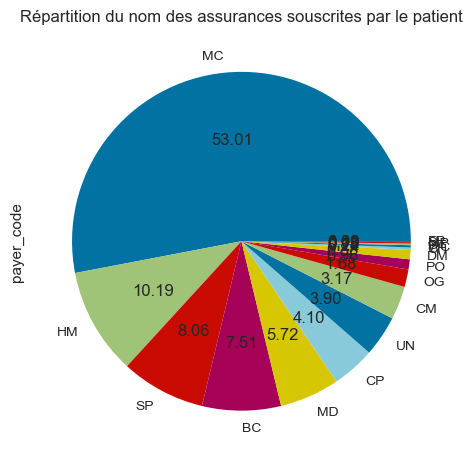

In [76]:
df['payer_code'].value_counts().plot.pie(autopct='%.2f', title='R√©partition du nom des assurances souscrites par le patient')
plt.show()

N'ai pas trouv√© de documentation sur ces codes mais ai voulu creuser l'acronyme "MC" : il semblerait qu'il s'agisse de "Medicare". En effet, c'est une assurance maladie am√©ricaine principalement fournie aux Am√©ricains √¢g√©s de 65 ans et plus, mais √©galement √† certaines personnes plus jeunes ayant un statut d'invalidit√© ou souffrant d'insuffisance r√©nale terminale ou de scl√©rose lat√©rale amyotrophique. V√©rifions si nos donn√©es vont dans ce sens en visualisant la distribution de l'√¢ge en fonction de notre variable payer_code.

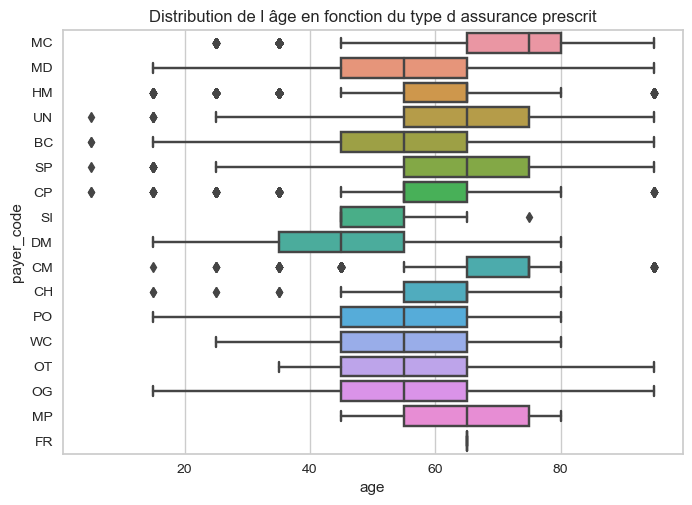

In [77]:
sns.boxplot(data=df, x="age", y="payer_code")
plt.title('Distribution de l √¢ge en fonction du type d assurance prescrit')
plt.show()

Effectivement, la boite √† moustaches montre que l'√¢ge m√©dian des personnes qui ont cette assurance est de 75 ans environ avec des quartiles 1 et 3 entre 65 et 80, ce qui corrobore qu'il s'agit bien de la souscription √† Medicare. Les outliers en d√©but de distribution correspondrait aux exceptions mentionn√©es dans la d√©finition (jeunes malades).  
En cons√©quence de cette analyse, nous allons transformer cette variable entre : 
- MC (Medicare)
- SP (self-pay) : le fait de payer soit-m√™me ses soins peut amener √† √©courter les analyses
- Autres
- Inconnu pour les NULL

In [78]:
# Remplace les valeurs nulles par 'Inconnu'
df = df.replace({'payer_code' : {np.nan : 'Inconnu'}})
df.head(10)

race  gender  age  admission_type_id  discharge_disposition_id  \
1         Caucasian  Female   15                  1                         1   
2   AfricanAmerican  Female   25                  1                         1   
3         Caucasian    Male   35                  1                         1   
4         Caucasian    Male   45                  1                         1   
5         Caucasian    Male   55                  2                         1   
6         Caucasian    Male   65                  3                         1   
7         Caucasian    Male   75                  1                         1   
8         Caucasian  Female   80                  2                         1   
9         Caucasian  Female   95                  3                         3   
10  AfricanAmerican  Female   45                  1                         1   

    admission_source_id  time_in_hospital payer_code medical_specialty  \
1                     7                 3    Inconnu           Inconnu   
2                     7                 2    Inconnu           Inconnu   
3                     7                 2    Inconnu           Inconnu   
4                     7                 1    Inconnu           Inconnu   
5                     2                 3    Inconnu           Inconnu   
6                     2                 4    Inconnu           Inconnu   
7                     7                 5    Inconnu           Inconnu   
8                     4                13    Inconnu           Inconnu   
9                     4                12    Inconnu  InternalMedicine   
10                    7                 9    Inconnu           Inconnu   

    num_lab_procedures  num_procedures  num_medications  number_outpatient  \
1                   59               0               18                  0   
2                   11               5               13                  2   
3                   44               1               16                  0   
4                   51               0                8                  0   
5                   31               6               16                  0   
6                   70               1               21                  0   
7                   73               0               12                  0   
8                   68               2               28                  0   
9                   33               3               18                  0   
10                  47               2               17                  0   

    number_emergency  number_inpatient diag_1  diag_2 diag_3  \
1                  0                 0      0  250.01      0   
2                  0                 1      0     250      0   
3                  0                 0      0  250.43      0   
4                  0                 0      0     157      1   
5                  0                 0      0     411      1   
6                  0                 0      0     411      0   
7                  0                 0      0     492      1   
8                  0                 0      0     427      0   
9                  0                 0      0     198      0   
10                 0                 0      1     403      0   

    number_diagnoses max_glu_serum A1Cresult metformin repaglinide  \
1                  9          None      None        No          No   
2                  6          None      None        No          No   
3                  7          None      None        No          No   
4                  5          None      None        No          No   
5                  9          None      None        No          No   
6                  7          None      None    Steady          No   
7                  8          None      None        No          No   
8                  8          None      None        No          No   
9                  8          None      None        No          No   
10                 9          None      None

In [79]:
df['payer_code'].value_counts()

Inconnu    39460
MC         32261
HM          6203
SP          4903
BC          4571
MD          3480
CP          2498
UN          2371
CM          1932
OG          1020
PO           586
DM           536
CH           145
WC           131
OT            94
MP            79
SI            52
FR             1
Name: payer_code, dtype: int64

In [80]:
def payer_code(df):   
    if df['payer_code'] == 'MC':
        return 'Medicare'
    elif df['payer_code'] == 'SP':
        return 'Self_pay'
    elif df['payer_code'] == 'Inconnu':
        return 'Inconnu'
    else:
        return 'Autres'

In [81]:
df['payer_code_transform'] = df.apply(payer_code, axis=1)

In [82]:
df['payer_code_transform'].value_counts()

Inconnu     39460
Medicare    32261
Autres      23699
Self_pay     4903
Name: payer_code_transform, dtype: int64

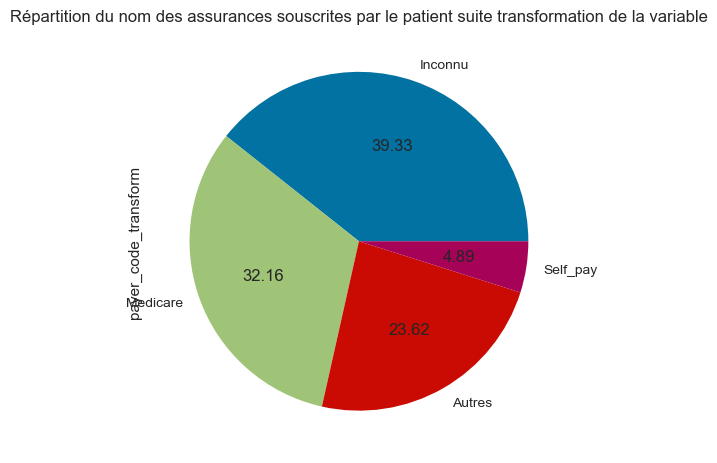

In [83]:
df['payer_code_transform'].value_counts().plot.pie(autopct='%.2f', title='R√©partition du nom des assurances souscrites par le patient suite transformation de la variable')
plt.show()

**race & gender**

In [84]:
df['race'].value_counts()

Caucasian          75144
AfricanAmerican    18887
Hispanic            1986
Other               1484
Asian                625
Name: race, dtype: int64

In [85]:
df['gender'].value_counts()

Female    53964
Male      46356
Name: gender, dtype: int64

La variable 'gender' a deux classes √©quilibr√©es tandis que 'race' l'est un peu moins. Le Chi_2 montre une d√©pendance entre la target et ces variables. Il peut √™tre int√©ressant de les conserver. On va donc les encoder. 

In [86]:
df[['race', 'gender']].describe()

race  gender
count       98126  100320
unique          5       2
top     Caucasian  Female
freq        75144   53964

In [87]:
table_gender = pd.crosstab(df['gender'], df['readmitted'], margins=True, margins_name='Total')
table_gender

readmitted      0      1   Total
gender                          
Female      28543  25421   53964
Male        25313  21043   46356
Total       53856  46464  100320

In [88]:
table_race = pd.crosstab(df['race'], df['readmitted'], margins=True, margins_name='Total')
table_race

readmitted           0      1  Total
race                                
AfricanAmerican  10201   8686  18887
Asian              401    224    625
Caucasian        39722  35422  75144
Hispanic          1145    841   1986
Other              902    582   1484
Total            52371  45755  98126

In [89]:
chi_2, pvalue, degrees, expected = chi2_contingency(table_gender)
chi_2, pvalue

(29.427763956935564, 6.399200774762359e-06)

In [90]:
chi_2, pvalue, degrees, expected = chi2_contingency(table_race)
chi_2, pvalue

(87.5719014338937, 1.6206748230561673e-14)

**Change & diabetesMed**

Change indique s'il y a eu un changement dans le traitement pour le diab√®te (soit dans la posologie, soit dans le m√©dicament prescrit).  
DiabetesMed indique s'il y a eu prescription de m√©dicaments pour le diab√®te ou pas.   
=> Ces deux variables devraient √™tre corr√©l√©es ? 

In [91]:
df['change'].value_counts()

No    53930
Ch    46393
Name: change, dtype: int64

In [92]:
df['diabetesMed'].value_counts()

Yes    77218
No     23105
Name: diabetesMed, dtype: int64

Ces deux variables sont effectivement d√©pendantes. Il conviendrait de conserver celle qui est la plus corr√©l√©e √† la target. 

In [ ]:
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [95]:
table_diab_change = pd.crosstab(df['change'], df['diabetesMed'], margins=True, margins_name='Total')
table_diab_change

diabetesMed     No    Yes   Total
change                           
Ch               0  46393   46393
No           23105  30825   53930
Total        23105  77218  100323

In [96]:
chi_2, pvalue, degrees, expected = chi2_contingency(table_diab_change)
chi_2, pvalue

(25823.194792780185, 0.0)

In [97]:
obs = np.sum(table_diab_change)
obs

diabetesMed
No        46210
Yes      154436
Total    200646
dtype: int64

In [98]:
mini = min(table_diab_change.shape)-1
mini

2

In [99]:
result = chi_2/(obs*mini)
result

diabetesMed
No       0.279411
Yes      0.083605
Total    0.064350
dtype: float64

In [100]:
result[2]

0.06435013604253308

Le test de Cramer mesure le niveau de corr√©lation entre 2 variables cat√©gorielles. Il renvoie une valeur entre 0 et 1. Si la valeur est sup√©rieure √† 0.9, la relation est tr√®s forte, si elle est inf√©rieure √† 0.1, elle est faible.  
On peut qualifier la relation entre nos deux variables de tr√®s faible, voire quasi-nulle. 

**Medication**

Les variables quantitatives li√©es √† la prise de m√©dicaments pr√©sentent des types de modalit√©s diff√©rentes : 
- modalit√©s distinctes avec r√©partition int√©ressante : 
    - max_glu_serum (glyc√©mie √† jeun), 
    - A1Cresult (h√©moglobine glyqu√©e), 
    - antidiab√©tiques oraux : metformin, glipizide, glyburide, pioglitazone, rosiglitazone
    - insulin (piq√ªre) 
- modalit√©s avec peu de variabilit√©
- une seule modalit√©

Nous ne retenons que les variables avec des modalit√©s distinctes. Rappelons que le None signifie que la prise de sang n'a pas √©t√© effectu√©e. 

Deux choix s'offrent √† nous : 
- encoder les variables en ordinal en fonction du degr√© d'importance
- cr√©er une nouvelle feature qui indiquerait si le patient prend ou non un antidiab√©tique oral

Nous nous contenterons pour le moment d'encoder les variables ordinalement.

#### Relation des variables avec la target 

##### Variables continues : num_lab_procedures / num_medications

In [101]:
readmitted = df[df['readmitted'] == 1]
no_readmitted = df[df['readmitted'] == 0]

In [102]:
readmitted.shape, no_readmitted.shape

((46464, 51), (53859, 51))

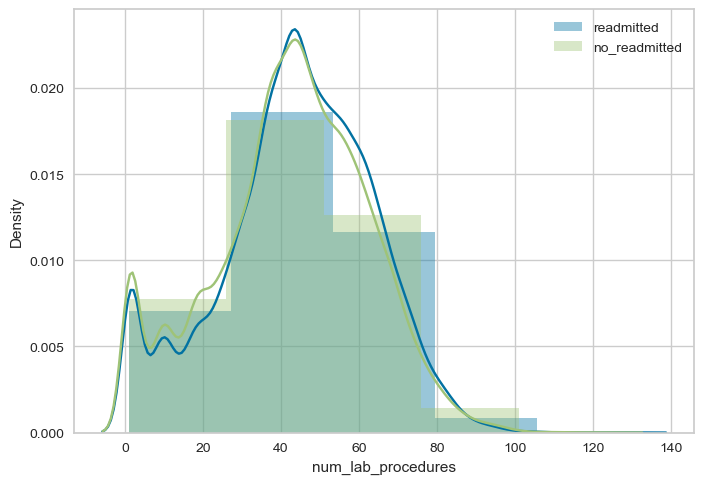

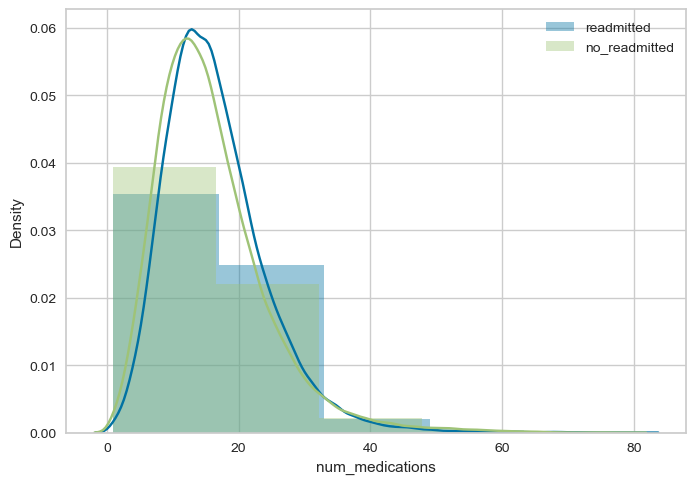

In [103]:
for col in continuous_variables:
    plt.figure()
    sns.distplot(readmitted[col], label = 'readmitted', bins=5)
    sns.distplot(no_readmitted[col], label = 'no_readmitted', bins=5)
    plt.legend()
    plt.show()

A priori, le nombre de m√©dicaments pris ou de prises de sang effetu√©es ne semble pas avoir d'impact sur le fait d'√™tre r√©admis ou non pour des raisons de diab√®te.

Avec le t_test, on √©met l'hypoth√®se nulle que les distributions sont √©gales pour les personnes r√©admissent ou non. Pour cela, on utilise le test de student. Il permet de v√©rifier si la moyenne entre deux distribution est significativement diff√©rente. Le principe est d'essayer de rejeter cette hypoth√®se avec un seuil alpha souvent entre 2 et 5%, on calcule une valeur P avec test de student (ou Khi2). Si la valeur pest inf√©rieur √† notre seuil de probabilit√© alpha = on peut rejeter cette hypoth√®se, sinon on ne peut pas rejeter cette hypoth√®se.

Quand on utilise ce test, il vaut mieux avoir des classes balanc√©es entre nos diff√©rents groupes (le nb de personnes + et - doivent √™tre √† peu pr√®s √©gales).

In [104]:
from scipy.stats import ttest_ind

In [105]:
alpha = 0.05
stat, p = ttest_ind(readmitted['num_lab_procedures'].dropna(), no_readmitted['num_lab_procedures'].dropna())
print(p)
if p < alpha:
     print('H0 Rejet√©e')
else :
    print('0')

3.899911648131104e-33
H0 Rejet√©e


In [106]:
alpha = 0.05
stat, p = ttest_ind(readmitted['num_medications'].dropna(), no_readmitted['num_medications'].dropna())
print(p)
if p < alpha:
     print('H0 Rejet√©e')
else :
    print('0')

1.3780046537364088e-42
H0 Rejet√©e


L'hypoth√®se nulle √©tant rejet√©e, d'apr√®s le t_student, les distributions sont tout de m√™me diff√©rente. Il y aurait donc une variabilit√© int√©ressante pour ces deux features entre les personnes r√©hospitalis√©es ou non. Nous conservons donc ces variables dans notre mod√®le. 

In [107]:
continuous_variables.corr()

num_lab_procedures  num_medications
num_lab_procedures            1.000000         0.268161
num_medications               0.268161         1.000000

Par ailleurs, ces deux variables ne semblent pas corr√©l√©es entre elles. 

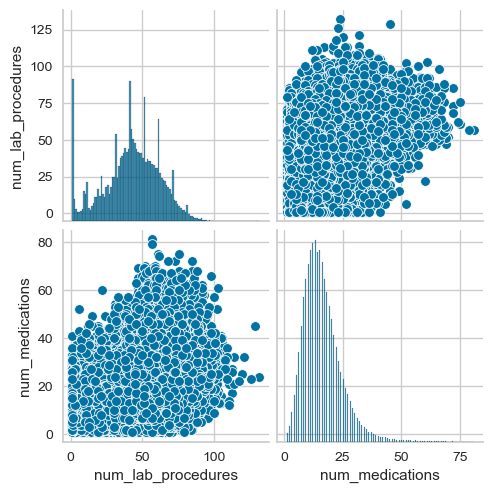

In [108]:
sns.pairplot(continuous_variables)
plt.show()

##### Variables discr√®tes : num_diagnoses, time_in_hospital et age

In [109]:
discrete_variables_2 = df[['number_diagnoses', 'time_in_hospital', 'age', 'readmitted']]

In [110]:
# Pour rappel de la r√©partition de la target
df['readmitted'].value_counts()

0    53859
1    46464
Name: readmitted, dtype: int64

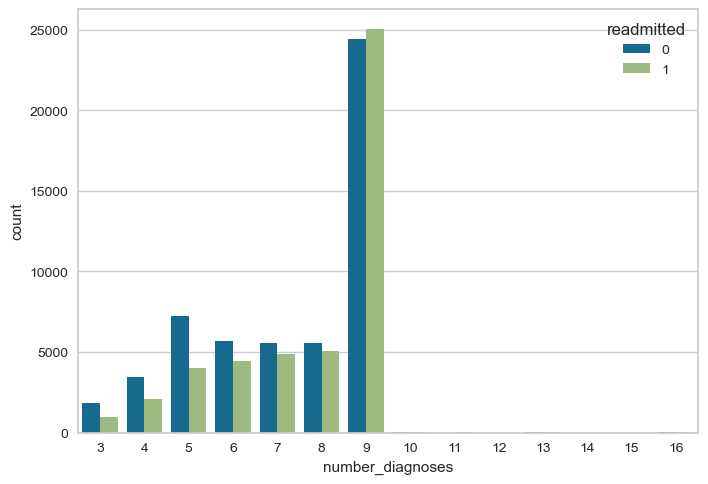

In [111]:
sns.countplot(x='number_diagnoses', hue='readmitted', data = discrete_variables_2)
plt.show()

On compte le nombre d'apparition de diagnostic √©tabli dans le syst√®me pour les patients en fonction s'ils ont √©t√© r√©admis ou non. A noter que notre √©chantillon 0/1 est respectivement de 53% et 46%. 
Une diff√©rence semble se noter √† partir de 5 diagnostic d√©clar√©s et de surtout √† partir de 9. 

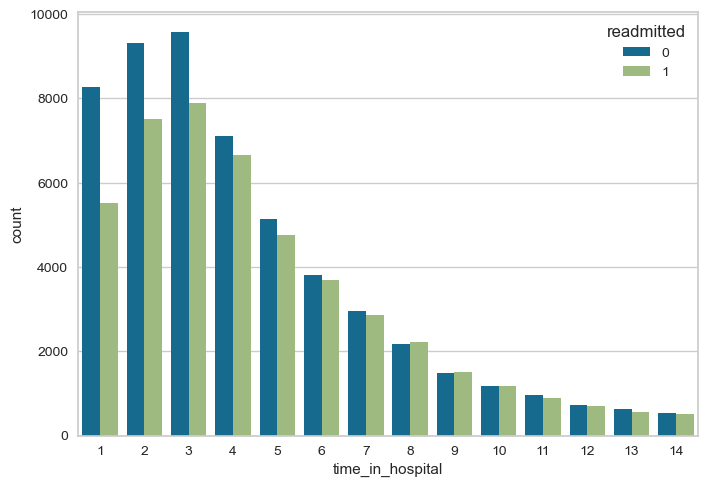

In [112]:
sns.countplot(x='time_in_hospital', hue='readmitted', data = discrete_variables_2)
plt.show()

On observe le nombre d'apparition des patients r√©admis ou non en fonction du temps d'hospitalisation. On ne note pas de diff√©rence significative, si ce n'est les 3 premiers jours : des temps d'hospitalisation courts semblent √™tre plus propices √† une non r√©admission. 

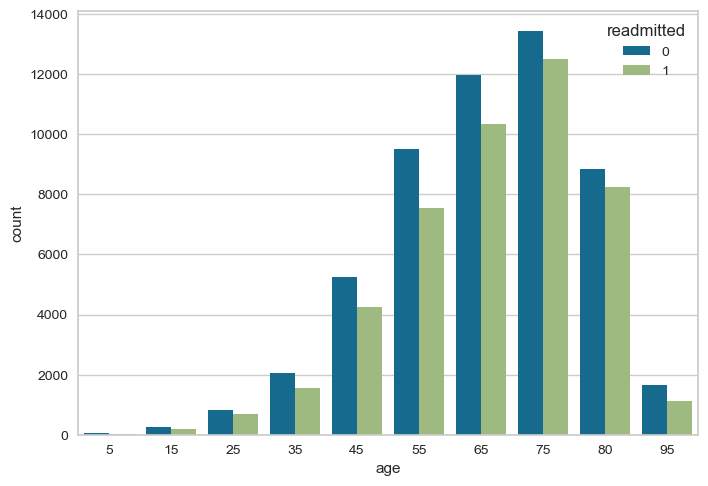

In [113]:
sns.countplot(x='age', hue='readmitted', data = discrete_variables_2)
plt.show()

La variable age ne semble pas discriminante au regard du countplot ci-dessus. Que la patient soit r√©admis ou non, la distribution est semblable.

In [114]:
discrete_variables_2.corr()

number_diagnoses  time_in_hospital       age  readmitted
number_diagnoses          1.000000          0.210214  0.200639    0.107241
time_in_hospital          0.210214          1.000000  0.095755    0.048886
age                       0.200639          0.095755  1.000000    0.023373
readmitted                0.107241          0.048886  0.023373    1.000000

##### Variables cat√©gorielles (avec feature engineering)

In [115]:
categorial_features = df[['discharge_disposition_transform', 'admission_source_transform', 'diag_1', 'diag_3', 'specialty_transform', 'payer_code_transform', 'race', 'gender','change', 'diabetesMed', 'max_glu_serum', 'A1Cresult', 'metformin', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'readmitted']]

In [116]:
categorial_features

discharge_disposition_transform admission_source_transform diag_1  \
1                                     0                   Urgences      0   
2                                     0                   Urgences      0   
3                                     0                   Urgences      0   
4                                     0                   Urgences      0   
5                                     0                     Autres      0   
...                                 ...                        ...    ...   
101761                                1                   Urgences      1   
101762                                1                     Autres      0   
101763                                0                   Urgences      0   
101764                                1                   Urgences      0   
101765                                0                   Urgences      0   

       diag_3 specialty_transform payer_code_transform             race  \
1           0             Inconnu              Inconnu        Caucasian   
2           0             Inconnu              Inconnu  AfricanAmerican   
3           0             Inconnu              Inconnu        Caucasian   
4           1             Inconnu              Inconnu        Caucasian   
5           1             Inconnu              Inconnu        Caucasian   
...       ...                 ...                  ...              ...   
101761      0             Inconnu             Medicare  AfricanAmerican   
101762      0             Inconnu             Medicare  AfricanAmerican   
101763      0             Inconnu             Medicare        Caucasian   
101764      0              Autres             Medicare        Caucasian   
101765      0             Inconnu              Inconnu        Caucasian   

        gender change diabetesMed max_glu_serum A1Cresult metformin glipizide  \
1       Female     Ch         Yes          None      None        No        No   
2       Female     No         Yes          None      None        No    Steady   
3         Male     Ch         Yes          None      None        No        No   
4         Male     Ch         Yes          None      None        No    Steady   
5         Male     No         Yes          None      None        No        No   
...        ...    ...         ...           ...       ...       ...       ...   
101761    Male     Ch         Yes          None        >8    Steady        No   
101762  Female     No         Yes          None      None        No        No   
101763    Male     Ch         Yes          None      None    Steady        No   
101764  Female     Ch         Yes          None      None        No    Steady   
101765    Male     No          No          None      None        No        No   

       glyburide pioglitazone rosiglitazone insulin  readmitted  
1             No           No            No      Up           1  
2             No           No            No      No           0  
3             No           No            No      Up           0  
4             No           No            No  Steady           0  
5             No           No            No  Steady           1  
...          ...          ...           ...     ...         ...  
101761        No           No            No    Down           1  
101762        No           No            No  Steady           0  
101763        No           No            No    Down           0  
101764        No       Steady            No      Up           0  
101765        No           No            No      No           0  

[100323 rows x 19 columns]

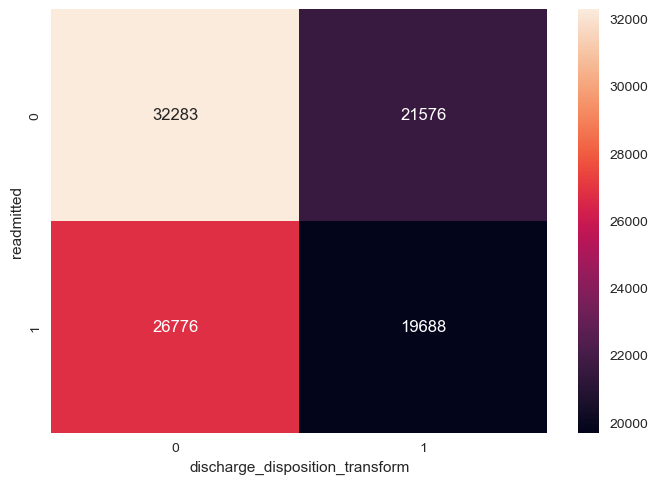

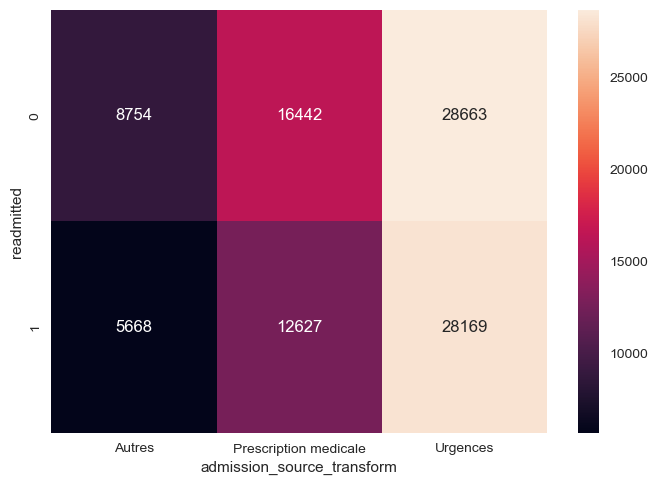

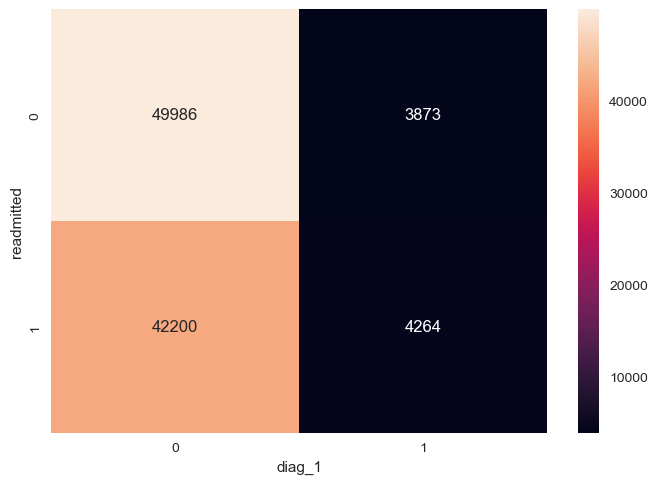

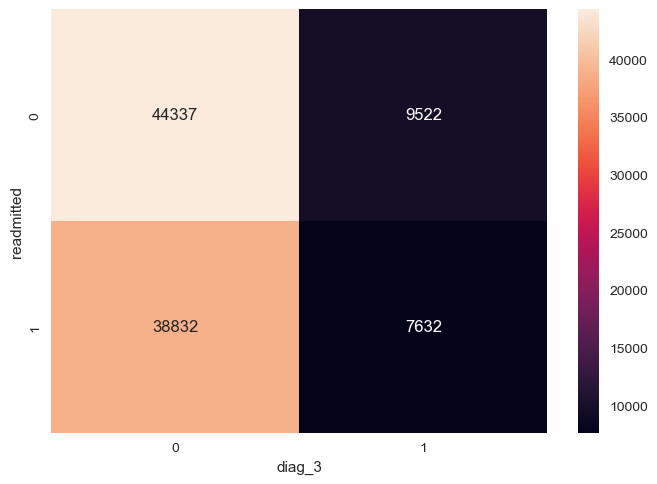

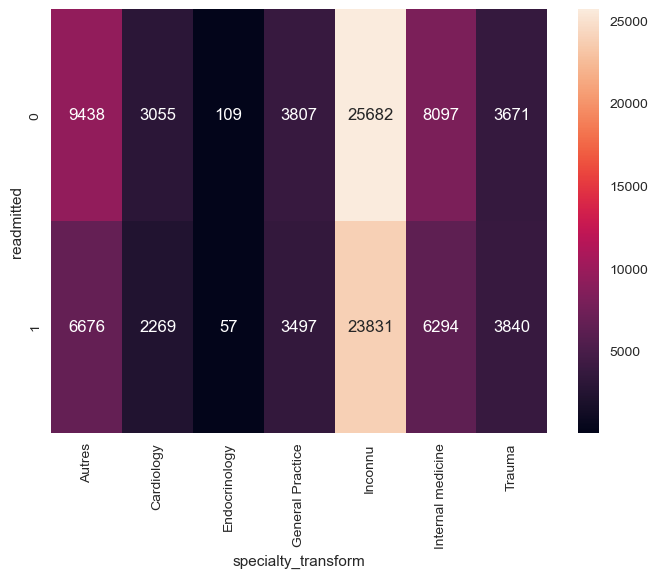

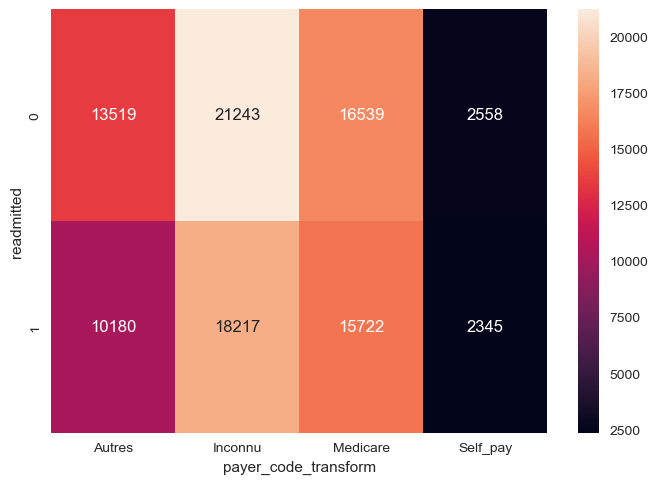

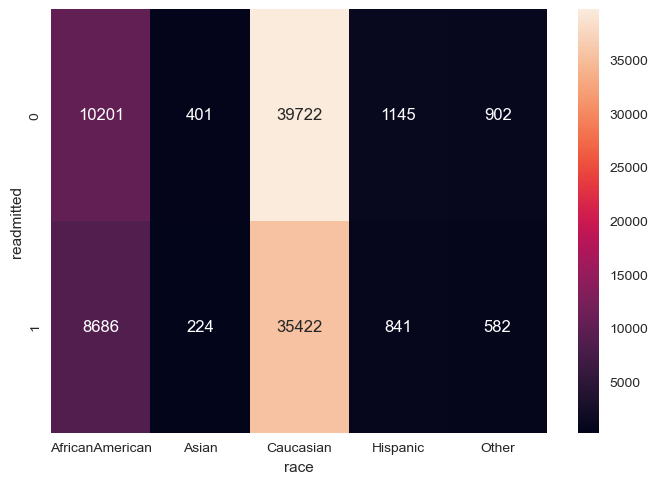

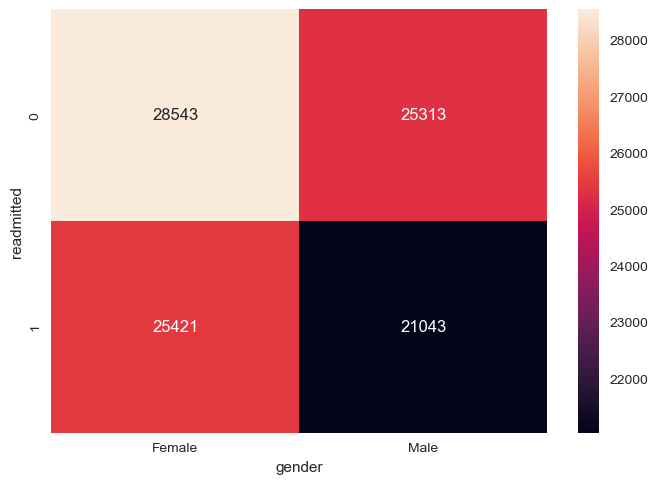

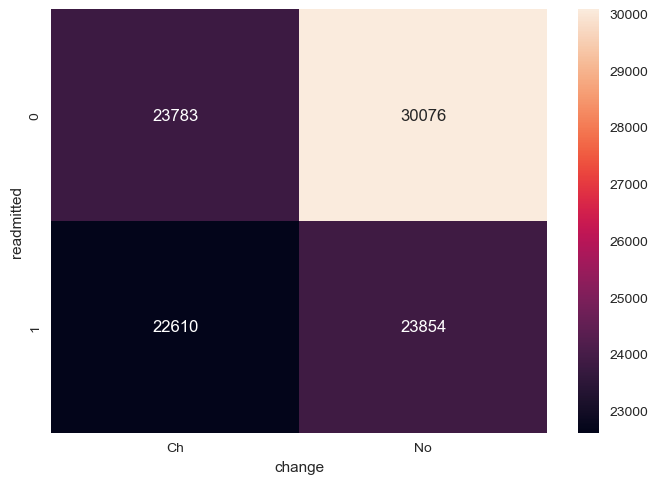

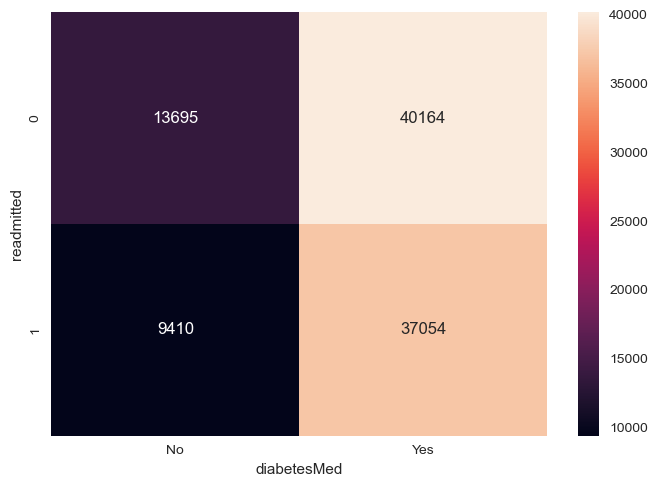

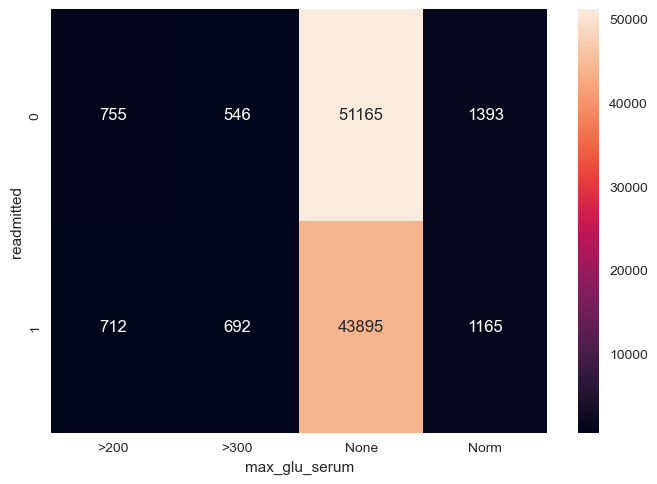

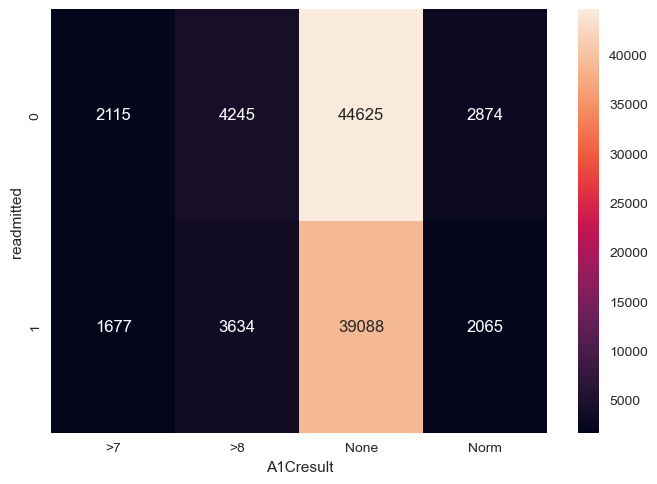

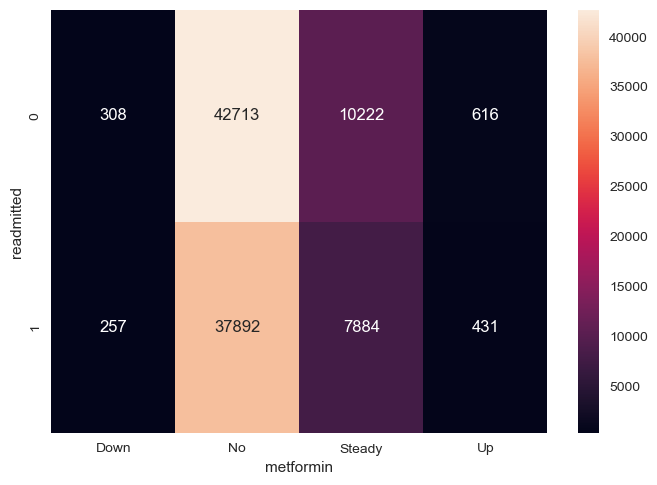

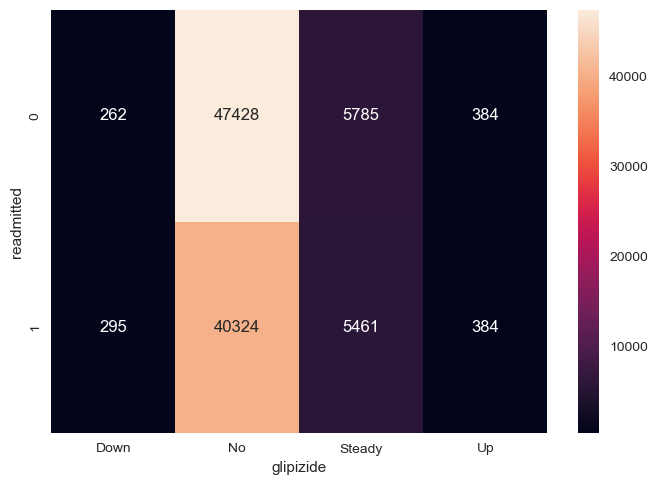

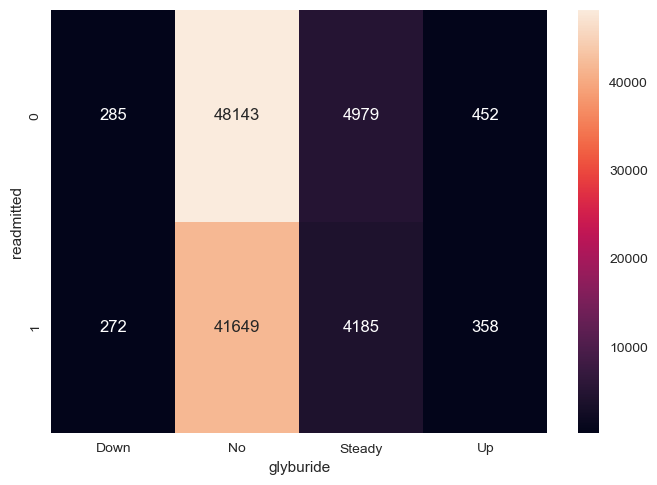

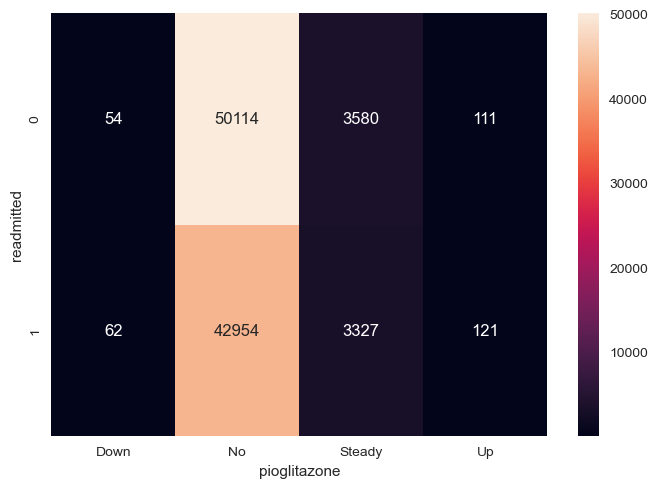

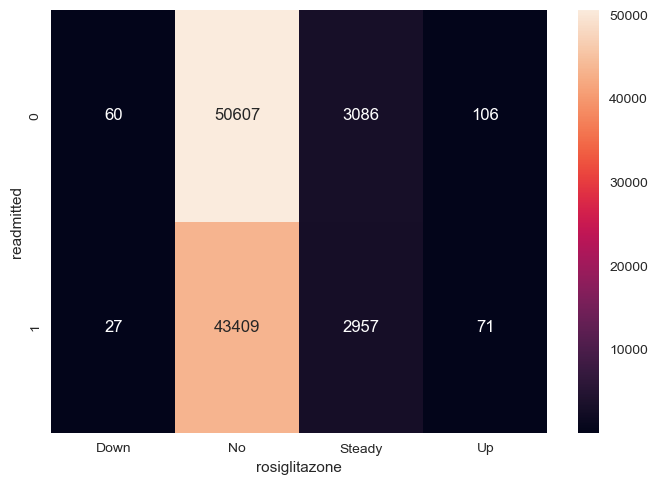

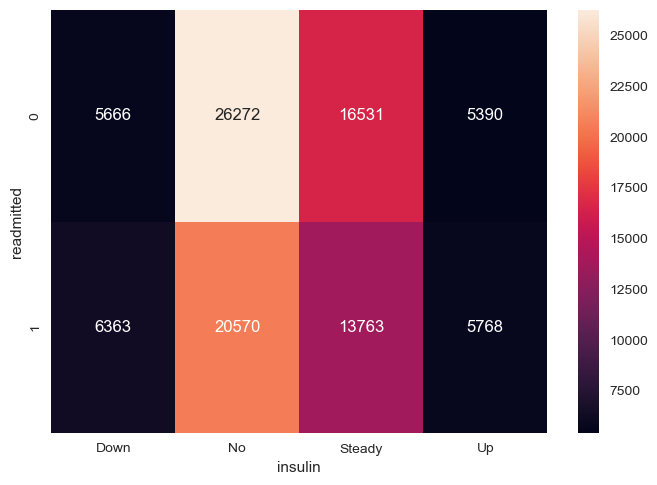

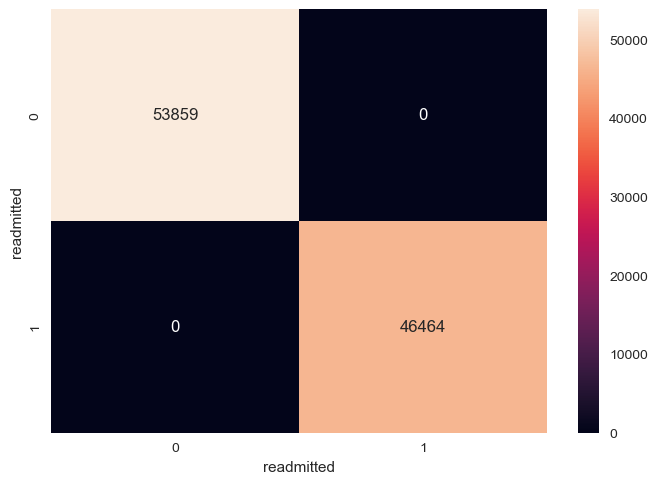

In [117]:
# Crosstab avec la target

for col in categorial_features:
    plt.figure()
    sns.heatmap(pd.crosstab(categorial_features['readmitted'], categorial_features[col]), annot=True, fmt='d')

In [118]:
import researchpy

In [119]:
# Retourne le score de V_cramer

for col in categorial_features:
    crosstab, res = researchpy.crosstab(categorial_features[col],  categorial_features['readmitted'], test='chi-square')
    print(f'{col} -- V de Cramer: {res.iloc[2,1]} / p_value du Chi_2: {res.iloc[1,1]}')

discharge_disposition_transform -- V de Cramer: 0.0234 / p_value du Chi_2: 0.0
admission_source_transform -- V de Cramer: 0.0788 / p_value du Chi_2: 0.0
diag_1 -- V de Cramer: 0.0363 / p_value du Chi_2: 0.0
diag_3 -- V de Cramer: 0.0166 / p_value du Chi_2: 0.0
specialty_transform -- V de Cramer: 0.0611 / p_value du Chi_2: 0.0
payer_code_transform -- V de Cramer: 0.0433 / p_value du Chi_2: 0.0
race -- V de Cramer: 0.0299 / p_value du Chi_2: 0.0
gender -- V de Cramer: 0.0171 / p_value du Chi_2: 0.0
change -- V de Cramer: 0.045 / p_value du Chi_2: 0.0
diabetesMed -- V de Cramer: 0.0613 / p_value du Chi_2: 0.0
max_glu_serum -- V de Cramer: 0.0223 / p_value du Chi_2: 0.0
A1Cresult -- V de Cramer: 0.0227 / p_value du Chi_2: 0.0
metformin -- V de Cramer: 0.0287 / p_value du Chi_2: 0.0
glipizide -- V de Cramer: 0.0203 / p_value du Chi_2: 0.0
glyburide -- V de Cramer: 0.0068 / p_value du Chi_2: 0.2039
pioglitazone -- V de Cramer: 0.0127 / p_value du Chi_2: 0.0011
rosiglitazone -- V de Cramer: 0

D'apr√®s les r√©sultats, aucune des variables n'a de relation forte avec la target car tous les r√©sultats sont inf√©rieure √† 0.10
Noius d√©cidons de toutes les garder tout de m√™me pour entrainer notre mod√®le (apr√®s avoir proc√©d√© au pre-processing). 

#### Relation des variables entre elles

A faire : 

- Regarder si la relation entrela probabilit√© de r√©admission et le fait d'avoir mesurer la glyc√©mie glyqu√©e d√©pend du diagnotic - payer_code et temps d'hospitalisation
- antidiab√©tiques oraux et r√©sultats de la glyc√©mie

In [ ]:
# test

for col in continuous_variables:
    plt.figure()
    sns.lmplot(x='age', y=col, hue='readmitted', data=df)

In [ ]:
# test

df.corr()['readmitted']

### Data selection

Etapes : 
- copie du dataset
- s√©lection des variables √† garder (suite √† l'EDA)
- TrainTest split

In [169]:
# R√©sum√© des √©tapes avant d'appliquer le preprocessing
df_2 = base_clean_dataset()
df_2 = df_2[['num_lab_procedures','num_medications', 'number_diagnoses', 'time_in_hospital', 'age', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_3', 'medical_specialty', 'payer_code', 'race', 'gender', 'change', 'diabetesMed', 'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'pioglitazone', 'rosiglitazone', 'insulin', 'readmitted']]
df_2.shape

(101766, 23)

In [170]:
trainset, testset = train_test_split(df_2, test_size=0.2, random_state=5)
print('Train set :', trainset.shape)
print('Test set :', testset.shape)

Train set : (81412, 23)
Test set : (20354, 23)


In [171]:
X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((75283, 38), (75283, 1), (18991, 38), (18991, 1))

In [ ]:
# R√©sum√© des √©tapes avant d'appliquer le preprocessing
# Toutes les √©tapes en Une cellule pour favoriser le copier/coller

data = base_clean_dataset()
data = data[['num_lab_procedures','num_medications', 'number_diagnoses', 'time_in_hospital', 'age', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_3', 'medical_specialty', 'payer_code', 'race', 'gender', 'change', 'diabetesMed', 'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'pioglitazone', 'rosiglitazone', 'insulin', 'readmitted']]
trainset, testset = train_test_split(data, test_size=0.2, random_state=5)
print('Train set :', trainset.shape)
print('Test set :', testset.shape)
X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
# test data sans preprocessing

In [172]:
trainset_dt, testset_dt = train_test_split(df_2, test_size=0.2, random_state=5)

In [175]:
X_train_dt = trainset_dt.drop(columns=['readmitted'], axis=1)
y_train_dt = trainset_dt[['readmitted']]

In [173]:
X_test_dt = testset_dt.drop(columns=['readmitted'], axis=1)
y_test_dt = testset_dt[['readmitted']]

In [176]:
X_train_dt.shape, y_train_dt.shape, X_test_dt.shape, y_test_dt.shape

((81412, 22), (81412, 1), (20354, 22), (20354, 1))

In [ ]:
def null_cleaning(df):
    df = df.replace({'medical_specialty' : {np.nan : 'Inconnu'}}).replace({'payer_code' : {np.nan : 'Inconnu'}})
    df = df.dropna()
    return df

In [177]:
X_train_dt = null_cleaning(X_train_dt)

In [179]:
X_test_dt = null_cleaning(X_test_dt)

In [180]:
X_train_dt.shape, X_test_dt.shape

((78502, 22), (19623, 22))

#### Import du dataset pre-nettoy√©

In [ ]:
df_2 = base_clean_dataset()

In [ ]:
df_2.head(2)

In [ ]:
df_2.shape

#### S√©lection des variables

On s√©lectionne les colonnes que nous avons identifi√©es comme utiles lors de l'EDA : nous avons d√©sormais 101766 exemples et 23 variables. 

In [ ]:
# S√©lection des variables

df_2 = df_2[['num_lab_procedures','num_medications', 'number_diagnoses', 'time_in_hospital', 'age', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_3', 'medical_specialty', 'payer_code', 'race', 'gender', 'change', 'diabetesMed', 'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'pioglitazone', 'rosiglitazone', 'insulin', 'readmitted']]

In [ ]:
df_2.head(2)

In [ ]:
df_2.shape

#### Train Test Split

L'objectif est de d√©couper le jeu d'entrainement en un train (sur lequel notre mod√®le va apprendre) et le test (qui doit √™tre mis de c√¥t√© sans jamais y toucher => √©viter √† tout prix le data leakage.

In [ ]:
trainset, testset = train_test_split(df_2, test_size=0.2, random_state=5)
print('Train set :', trainset.shape)
print('Test set :', testset.shape)

In [123]:
# R√©partition de la target sur le y_train

analyse_target(trainset)

number     %
0   43895  53.9
1   37517  46.1

In [124]:
# R√©partition de la target sur le y_train

analyse_target(testset)

number     %
0   10969  53.9
1    9385  46.1

La target constitue des classes bien √©quilibr√©es (pour le train et le test).

### Preprocessing

R√©capitulatif des transformations √† apporter en termes de preprocessing suite √† l'EDA : 

- suppression des outliers :
    - num_lab_procedures
    - num_medications
    - number_diagnoses
    - age  
    

- passer en logarithme : 
    - time_in_hospital
    

- encodage ordinal : (ou envisager de passer les traitements en OneHotEncoder car difficult√© √† attribuer un poids √† la variables -> tester les deux si r√©sultat pas probant) 
    - change
    - diabetesMed
    - max_glu_serum
    - A1Cresult
    - metformin
    - glimepiride
    - pioglitazone
    - rosiglitazone
    - insulin


- feature engineering:
    - discharge_disposition_id (0/1)
    - admission_source_id (Urgences/Prescription medicale/Autres) => puis √† OneHotEncoder
    - diag_1 / diag_3 (0/1)
    - medical_specialty => puis √† OneHotEncoder
    - payer_code => puis √† OneHotEncoder


- encodage OneHot : 
    - admission_source_transform
    - medical_specialty_transform
    - payer_code_transform
    - race
    - gender
    

#### Gestion des valeurs manquantes

Comme vu lors de l'EDA : 
- exclusion de la variable "weight" qui poss√©dait trop de valeurs nulles
- suppression des 3 colonnes pour lesquelles nous avons quelques lignes nulles
- Remplacement des valeurs nulles dans medical_speciality et payer_code par 'Inconnu'

In [125]:
check_null_values(df_2)

nombre_null  %_null
medical_specialty        49949    49.1
payer_code               40256    39.6
race                      2273     2.2
diag_3                    1423     1.4
diag_1                      21     0.0
gender                       3     0.0
diabetesMed                  0     0.0
insulin                      0     0.0
rosiglitazone                0     0.0
pioglitazone                 0     0.0

In [17]:
def null_cleaning(df):
    df = df.replace({'medical_specialty' : {np.nan : 'Inconnu'}}).replace({'payer_code' : {np.nan : 'Inconnu'}})
    df = df.dropna()
    return df

#### Suppression des outliers

In [19]:
def remove_outliers(df, col_name):

    # D√©finit les percentiles 25% et 75% et calcule le IQR
    Q1 = np.percentile(df[col_name], 25)
    Q3 = np.percentile(df[col_name], 75)
    IQR = Q3 - Q1
#     print("Old Shape: ", df.shape)

    # D√©tection des outliers (fourchette haute et basse)
    upper = np.where(df[col_name] > (Q3+1.5*IQR))
    lower = np.where(df[col_name] < (Q1-1.5*IQR))
    
    # Suppression des outliers
    df = df.reset_index(drop=True)  
    df = df.drop(upper[0], axis=0) 
    df = df.drop(lower[0],axis=0)
#     print("New Shape: ", df.shape)
    
    return df

In [20]:
def remove_outliers_dataset(df):
    '''Retire les outliers des colonnes sp√©cifi√©es
       A factoriser
    '''
    df = remove_outliers(df, 'num_lab_procedures')
    df = remove_outliers(df, 'num_medications')
    df = remove_outliers(df, 'number_diagnoses')
    df = remove_outliers(df, 'age')
    
    return df

In [ ]:
df_2.shape

In [ ]:
df_2 = remove_outliers_dataset(df_2)

In [ ]:
df_2.shape

#### Appliquer le logarithme

In [21]:
def logarithme(df):
    df['time_in_hospital'] = np.log(df[['time_in_hospital']])
    return df

In [ ]:
df_2 = logarithme(df_2)

In [ ]:
df_2.head()

#### Encodage ordinal

Nous allons proc√©der √† des transformations manuelles sans utiliser le module OrdinalEncoder de Sklearn par exemple car nous avons besoin de personnaliser l'encodage selon le type de variable. L'industrialisation √† l'aide des imputer de sklearn semble limit√©e. 

In [22]:
def ordinal_encodage(df):
    ''' Encoder ordinalement (affecter un poids) aux variables s√©lectionn√©es
        @Retourne un df preprocess√©
    '''
    code = {'No': 0,
            'Yes': 1,
            'Ch': 1, 
            'None': 0,
            'Norm': 1,
            '>200': 2,
            '>300': 3,
            '>7': 2,
            '>8': 3,
            'Steady': 2,
            'Down': 1,
            'Up': 3        
           }

    for col in df[['change', 'diabetesMed', 'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'pioglitazone', 'rosiglitazone', 'insulin']]:
        df.loc[:, col] = df[col].map(code)
    
    return df

In [ ]:
df_2[['change', 'diabetesMed', 'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'pioglitazone', 'rosiglitazone', 'insulin']]

In [ ]:
df_2 = ordinal_encodage(df_2)

In [ ]:
df_2.head()

#### Feature engineering

In [23]:
def discharge_disposition_id_transform(df):
    '''Transforme la colonne en binaire
    '''
    if df['discharge_disposition_id'] == 1:
        return 0
    else:
        return 1

In [24]:
def admission_source_id_transform(df):   
    '''Transforme la colonne selon 3 modalit√©s
    '''
    if df['admission_source_id'] == 7:
        return 'Urgences'
    elif df['admission_source_id'] == 1:
        return 'Prescription medicale'
    else:
        return 'Autres'

In [25]:
def diagnostic_transform(df):
    '''Transform les 2 colonnes en valeurs binaires : 1 = diag de Diab√®te / 0 = else
       @Return df
    '''
    df['diag_1'].loc[df['diag_1'].str.startswith('250') == True] = 1
    df['diag_1'].loc[df['diag_1'].str.startswith('250') == False] = 0
    df['diag_3'].loc[df['diag_3'].str.startswith('250') == True] = 1
    df['diag_3'].loc[df['diag_3'].str.startswith('250') == False] = 0
    df['diag_1'] = df['diag_1'].astype('int64')
    df['diag_3'] = df['diag_3'].astype('int64')
    return df

In [26]:
def medical_specialty_transform(df):   
    if df['medical_specialty'] == 'InternalMedicine':
        return 'Internal medicine'
    elif df['medical_specialty'] == 'Emergency/Trauma':
        return 'Trauma'
    elif df['medical_specialty'] == 'Family/GeneralPractice':
        return 'General Practice'
    elif df['medical_specialty'] == 'Cardiology':
        return 'Cardiology'
    elif df['medical_specialty'] == 'Pediatrics-Endocrinology':
        return 'Endocrinology'
    elif df['medical_specialty'] == 'Endocrinology':
        return 'Endocrinology'
    elif df['medical_specialty'] == 'Endocrinology-Metabolism':
        return 'Endocrinology'
    elif df['medical_specialty'] == 'Inconnu':
        return 'Inconnu'
    else:
        return 'Autres'

In [27]:
def payer_code_transform(df):   
    if df['payer_code'] == 'MC':
        return 'Medicare'
    elif df['payer_code'] == 'SP':
        return 'Self_pay'
    elif df['payer_code'] == 'Inconnu':
        return 'Inconnu'
    else:
        return 'Autres'

In [33]:
def feature_engineering(df):
    '''Transformation des colonnes discharge_disposition_id, admission_source_id, diag_1, diag_3, medical_specialty
       et payer_code suite √† l'EDA
       @Return le df modifi√©
    '''
    # Transform
    df['discharge_disposition_transform'] = df.apply(discharge_disposition_id_transform, axis=1)
    df['admission_source_transform'] = df.apply(admission_source_id_transform, axis=1)
    df = diagnostic_transform(df)
    df['medical_specialty_transform'] = df.apply(medical_specialty_transform, axis=1)
    df['payer_code_transform'] = df.apply(payer_code_transform, axis=1)
    
    # Delete les colonnes inutiles
    df = df.drop(['discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'payer_code'], axis = 1)
    
    return df

#### Encodage en get_dummies

chaque cat√©gorie ou classe est repr√©sent√©e de fa√ßon binaire dans colonne qui lui est propre (permet d'√©viter le probl√®me d'affectation de poids ordinal de la variable encod√©e). Les cat√©gories sont alors s√©par√©es en plusieurs dimensions.

In [29]:
def dummies_encodage(df):
    '''Passe en get_dummies les variables cat√©gorielles indiqu√©es
       @Return le df modifi√©
    '''
    one_hot_df = pd.get_dummies(df, 
                                columns=['admission_source_transform', 'medical_specialty_transform', 'payer_code_transform', 'race', 'gender'], 
                                drop_first=False)
    return one_hot_df

In [ ]:
test_2.head()

In [ ]:
test_2.shape

#### Normalisation

MinMaxScaler et StandardScaler sont sensibles aux valeurs aberrantes (outliers) Les donn√©es vont alors √™tre √©cras√©es par la pr√©sence des outliers => inutilisables pour un mod√®le de ML. 
Le RobustScaler, qui Soutrait les donn√©es √† la m√©diane de chaque variable, la m√©diane √©tant moins sensible aux outliers que la moyenne.  
Dans notre cas, nous allons utiliser le StandardScaler, qui fait en sorte que chaque variable ait une moyenne √©gale √† 0 et un √©cart-type de 1. Soustraire chaque valeur √† la moyenne initiale de notre variable et diviser par l'√©cart-type initial de notre variable : ùëß=(ùë•‚àí¬µ)/ùùà

In [30]:
def standardisation(df):
    ''' Standardisation des donn√©es sur l'ensemble du dataset encod√©
    '''
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
#     df_scaled = pd.DataFrame(scaler.fit_transform(df.drop(['readmitted'], axis=1)), columns = df.columns)
#     df_scaled = pd.DataFrame(scaler.fit_transform(df[['num_lab_procedures','num_medications', 'number_diagnoses', 'time_in_hospital', 'age', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_3', 'medical_specialty', 'payer_code', 'race', 'gender', 'change', 'diabetesMed', 'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'pioglitazone', 'rosiglitazone', 'insulin']]), columns = df.columns)
    return df_scaled

#### Fonction finale de preprocessing

In [31]:
def preprocessing(df):
    '''Actionne toutes les √©tapes de preprocessing
       @Return le dataset en s√©parant les variables de la target
    '''
    df = null_cleaning(df)
    df = remove_outliers_dataset(df)
    df = logarithme(df)
    df = ordinal_encodage(df)
    df = feature_engineering(df)
    df = dummies_encodage(df)
#     df = standardisation(df)
                         
    X = df.drop(columns=['readmitted'], axis=1)
    y = df[['readmitted']]
    
    return X, y

#### Application du preprocessing sur le trainset et testset

In [141]:
X_train, y_train = preprocessing(trainset)

In [159]:
X_test, y_test = preprocessing(testset)

In [156]:
X_train.shape, y_train.shape

((75283, 39), (75283, 1))

In [160]:
X_test.shape, y_test.shape

((18991, 38), (18991, 1))

In [144]:
y_train

readmitted
0               1
1               0
2               0
3               1
4               1
...           ...
75711           1
75712           0
75713           0
75714           1
75715           1

[75283 rows x 1 columns]

In [ ]:
# Standardise uniquement le X_train et le X_test afin que la target d√©j√† en 0/1 ne soit pas normalis√© (pose pb pour la suite du code)

# X_train = standardisation(X_train)
# X_test = standardisation(X_test)

### Entrainement & √©valuation du mod√®le en R√©gression logistique

Cette seconde it√©ration consistait √† tenter d'am√©liorer notre mod√®le gr√¢ce √† l'EDA, la s√©lection de variables qui en d√©coulait et un preprocessing plus √©labor√©. Nous re√©valuons notre mod√®le suite √† ces transformations. 
Nous indiquons le solver 'sag', visiblement pr√©conis√© par la documentation Sklearn pour les grands datasets (aide le mod√®le √† trouver les bonnes combinaisons ?).

In [46]:
model_iter_2_lr = LogisticRegression(random_state = 5, solver='sag')

In [36]:
# Fonction avec toutes les m√©triques mais longue √† s'√©xecuter 
def evaluation_cv(model, X, y):
    ''' Evalue toutes les m√©triques du mod√®le / Assez long √† ex√©cuter
        Score les 4 m√©triques : 'accuracy', 'recall', 'precision', 'f1'
        @Return scores en cv et la learning curve
    '''
    
    # Entra√Ænement du mod√®le
    model.fit(X, y)
    
    # M√©triques √† tester
    scoring = ['accuracy', 'recall', 'precision', 'f1']
    
    # Score des m√©triques
    for score in scoring: 
        print(f'Score {score} en cv : {cross_val_score(model, X, y, scoring = score, cv=5)}')
        print(f'Score {score} moyen en cv : {cross_val_score(model, X, y, scoring = score, cv=5).mean()}')
        print('')

    # Learning curve pour chacune des m√©triques 
    for score in scoring: 
        
        print(f'Pour {score} :')
        
        visualizer = LearningCurve(model, cv=5, train_sizes=np.linspace(0.1, 1, 10), n_jobs=4, 
                                   scoring = score)

        visualizer.fit(X, y) # Fit the data to the visualizer
        custum_title = visualizer.ax
        custum_title.set_title("Learning curve pour le score : {score}")
        visualizer.show() # Finalize and render the figure

        print('------------------------------------------------')

In [41]:
# Fonction moins longue : √† moduler en fonction de la m√©trique dont on a besoin

def evaluation_bis(model, X_train, y_train, X_test, y_test, scoring=''):
    ''' @Return classification report sur le test
        @Return learning curve en cv
    '''
    
    # Entra√Ænement du mod√®le
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    # Score synth√©tique des m√©triques sur le test   
    print("CLASSIFICATION REPORT SUR LE TEST\n")
    print(classification_report(y_test, ypred))
    
    # Learning curve en cross_validation pour le recall
    print(f"Learning curve en cross validation pour le {scoring}:")
    visualizer = LearningCurve(model, cv=5, train_sizes=np.linspace(0.1, 1, 10), n_jobs=4, 
                                   scoring = scoring)

    visualizer.fit(X_train, y_train) # Fit the data to the visualizer
    custum_title = visualizer.ax
    custum_title.set_title(scoring)
    visualizer.show() # Finalize and render the figure

CLASSIFICATION REPORT SUR LE TEST

              precision    recall  f1-score   support

           0       0.58      0.68      0.63     10093
           1       0.55      0.45      0.50      8898

    accuracy                           0.57     18991
   macro avg       0.57      0.56      0.56     18991
weighted avg       0.57      0.57      0.57     18991

Learning curve en cross validation pour le recall:


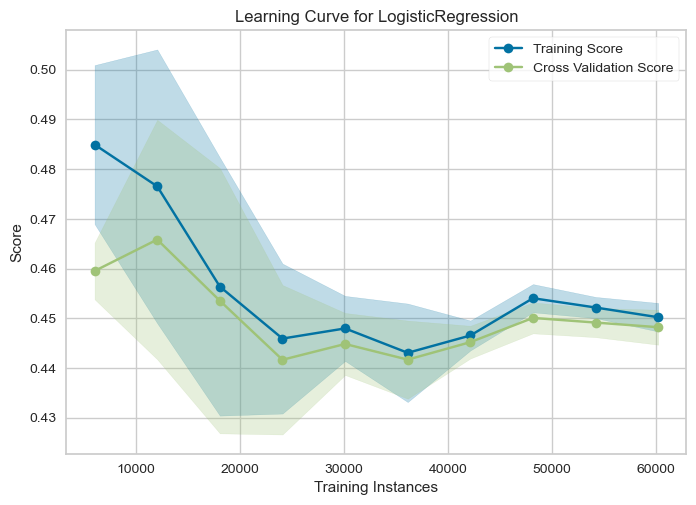

In [149]:
evaluation_bis(model_iter_2_lr, X_train, y_train, X_test, scoring='recall')

**Analyse** :   
Avec l'EDA et le processing, notre score en recall s'est un peu am√©lior√©. Nous sommes pass√©s d'un recall (baseline) de 0.39 √† 0.45. On perd un peu en pr√©cision (de 0.55 √† 0.63) mais on ongagne en F1-score (de 0.61 √† 0.57).  
La learning curve nous montre que le mod√®le a tendance √† bien g√©n√©raliser car le score du train et du validation set semble suivre la m√™me tendance. N√©anmoins, notre mod√®le souffre toujours underfitting. 

In [ ]:
# Evaluation du mod√®le (√† conserver pour les screenshot si besoin)

# evaluation_cv(model_iter_2_lr, X_train, y_train)

### Stat summary avec Statmodel

In [151]:
# log_reg = sm.Logit(y_train.values.reshape(-1,1), X_train).fit()
X_train_add_constant = sm.add_constant(X_train)
log_reg = sm.Logit(y_train, X_train_add_constant).fit()

         Current function value: 0.676081
         Iterations: 35


In [152]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:             readmitted   No. Observations:                75283
Model:                          Logit   Df Residuals:                    75249
Method:                           MLE   Df Model:                           33
Date:                Fri, 14 Oct 2022   Pseudo R-squ.:                 0.02183
Time:                        15:08:49   Log-Likelihood:                -50897.
converged:                      False   LL-Null:                       -52033.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                               -0.6432    2.9e+05  -2.22e-06      1.000   -5.69e+05    5.69e+05
num_lab_procedure

=> Interpr√©tation peu convaincante = il y a quelque chose qui cloche avec mon mod√®le. Voir avec Flo.

# It√©ration 3 : Valider le mod√®le param√©trique gr√¢ce au Decision Tree

## Entrainement et score

On veut utiliser ce mod√®le car il est tr√®s simple √† interpr√©ter et permet de comprendre assez rapidement les variables qui influent sur le mod√®le. Dans notre cas, nous souhaitons aussi v√©rifier les pr√©suppos√©s de la r√©gression logistique (md√®le param√©trique) afin de v√©rifier que nos donn√©es sont calibr√©es pour correspondre au mod√®le de reg logistique.  
A la place, nous tentons le Decision tree.

In [164]:
model_dt = DecisionTreeClassifier(random_state=5)

CLASSIFICATION REPORT SUR LE TEST

              precision    recall  f1-score   support

           0       0.55      0.54      0.55     10093
           1       0.49      0.50      0.49      8898

    accuracy                           0.52     18991
   macro avg       0.52      0.52      0.52     18991
weighted avg       0.52      0.52      0.52     18991

Learning curve en cross validation pour le recall:


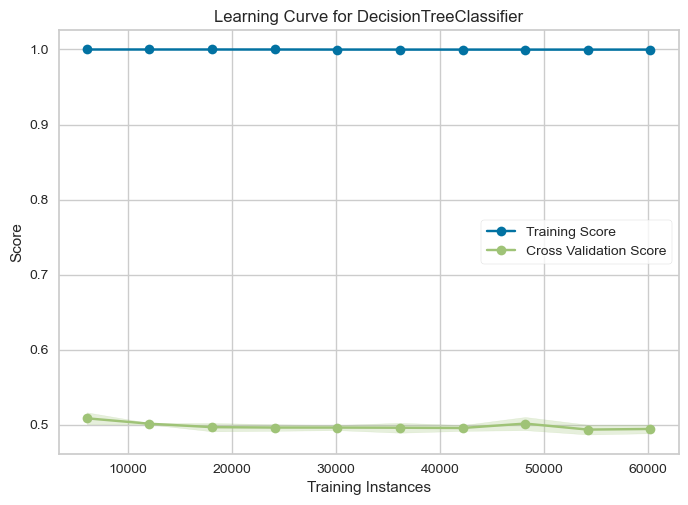

In [165]:
# Test avec EDA/Preprocessing
evaluation_bis(model_dt, X_train, y_train, X_test, scoring='recall')

Le recall s'est un peu am√©lior√© : on passe de 0.45 √† 0.50 mais notre mod√®le est clairement en overfitting (il ne parvient pas √† g√©n√©raliser lorsqu'il est test√© sur des donn√©es qu'il ne connait pas). Bien que les r√©sultats sur le test soient identiques √† ceux en cross validation. 
En revanche, la similarit√© des r√©sultats nous conforte dans l'id√©e que les principaux pr√©suppos√©s de la r√©gression logistique sont v√©rifi√©s.  

Le DecisionTree est r√©put√© pour overfitter facilement. L'hyperparam√®tre qui permet de r√©guler cela est le max_features. Correspond au
nombre de variables √† prendre en compte pour obtenir le
meilleur d√©coupage . La valeur par d√©faut est l'int√©gralit√© des features.
Il est int√©ressant de le positionner sur "auto" : l'algorithme prend la racine carr√©e du
nombre de colonnes total et choisit al√©atoirement un √©chantillon du nombre obtenu . Il
prend alors la meilleure variable parmi elles , et proc√®de ainsi pour chaque noeud

In [182]:
model_dt_2 = DecisionTreeClassifier(random_state=5, max_features = "auto")

CLASSIFICATION REPORT SUR LE TEST

              precision    recall  f1-score   support

           0       0.56      0.56      0.56     10093
           1       0.50      0.49      0.49      8898

    accuracy                           0.53     18991
   macro avg       0.53      0.53      0.53     18991
weighted avg       0.53      0.53      0.53     18991

Learning curve en cross validation pour le recall:


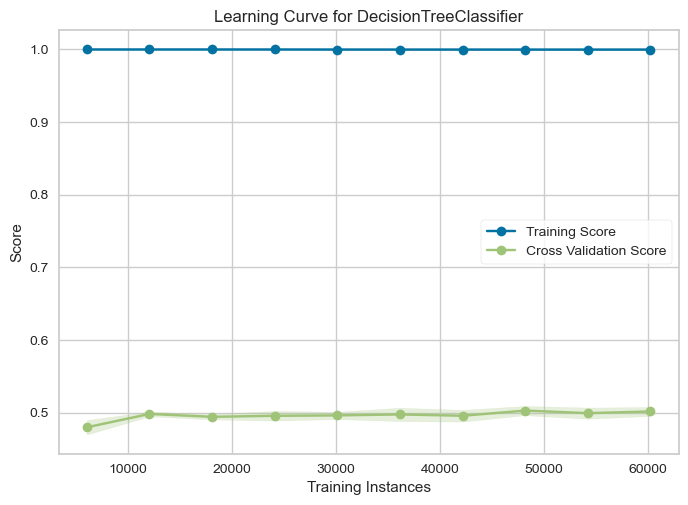

In [184]:
evaluation_bis(model_dt_2, X_train, y_train, X_test, scoring='recall')

Le r√©sultat est le m√™me, le mod√®le overfit toujours autant et le r√©sultat est pass√© √† 0.49.  
Voyons quelles sont les variables d√©finies comme les plus importantes pour le mod√®le. 

## Feature importances pour comprendre le mod√®le

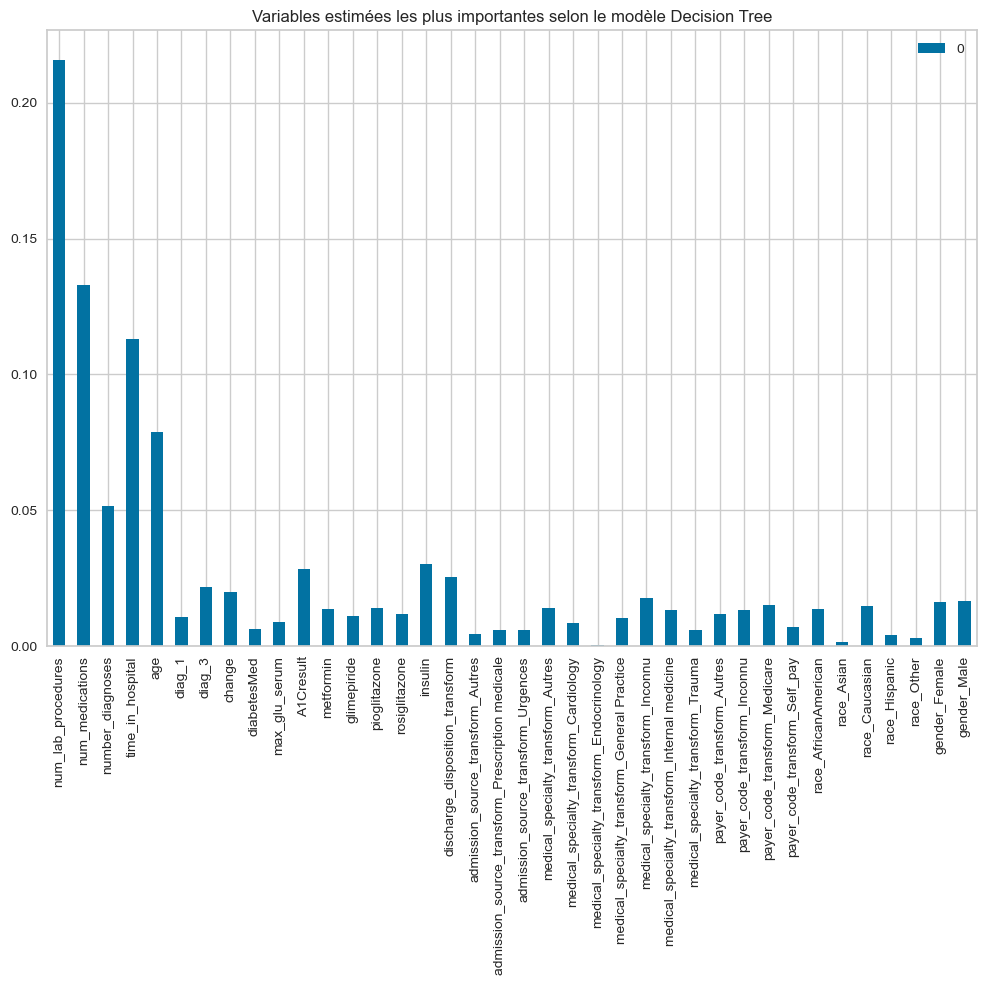

In [185]:
pd.DataFrame(model_dt.feature_importances_, index=X_train.columns).plot.bar(figsize=(12, 8))
plt.title("Variables estim√©es les plus importantes selon le mod√®le Decision Tree")
plt.show()

In [ ]:
dt_features = df_2[['num_lab_procedures','num_medications', 'number_diagnoses', 'time_in_hospital', 'age', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_3', 'medical_specialty', 'payer_code', 'race', 'gender', 'change', 'diabetesMed', 'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'pioglitazone', 'rosiglitazone', 'insulin', 'readmitted']]

## Interpr√©tation et axes d'am√©lioration

Ces r√©sultats sont int√©ressants. Ils nous indiquent que les features les plus significatives seraient : num_lab_procedures, num_medications, time_in_hospital, l'age et number_diagnoses. Ils corroborent pour certains les hypoth√®ses qui avaient √©t√© faites lors de l'EDA, notamment pour num_lab_procedures, num_medications. 
On constate que toutes les features qui ont fait l'objet de feature engineering pr√©sentent peu d'int√©r√™t pour le mod√®le. Il conviendrait d'ailleurs de tenter de supprimer les valeurs nulles des 2 colonnes pourlesquelles nous avons remplac√© les NaN pas 'Inconnu' => il serait int√©ressant de faire le test pour am√©liorer la qualit√© des donn√©es et de tester d'autres hypoth√®ses.  

On constate que la mesure de l'h√©moglobine glyqu√©e est pertinente, ainsi que l'insuline. Les m√©dicaments oraux antidiab√©tiques sont moins significatifs mais peut-√™tre qu'ils pourraient jouer un poids plus important s'ils √©taient rassembl√©s sous une m√™me variable. C'est une hypoth√®se que nous avions √©mise lors de l'EDA.  

# It√©ration 4 : Re-√©valuer les mod√®les avec les seules variables les plus significatives

## Avec le Decision Tree

In [186]:
# On conserve le X_train d√©j√† pr√©process√© mais on s√©lectionne les variables qui nous int√©ressent

X_train_feat_import = X_train[['num_lab_procedures','num_medications', 'number_diagnoses', 'time_in_hospital', 'age', 'diag_3', 'A1Cresult', 'insulin', 'discharge_disposition_transform',  'change']]

In [187]:
X_test__feat_import = X_test[['num_lab_procedures','num_medications', 'number_diagnoses', 'time_in_hospital', 'age', 'diag_3', 'A1Cresult', 'insulin', 'discharge_disposition_transform',  'change']]

CLASSIFICATION REPORT SUR LE TEST

              precision    recall  f1-score   support

           0       0.55      0.56      0.56     10093
           1       0.49      0.49      0.49      8898

    accuracy                           0.53     18991
   macro avg       0.52      0.52      0.52     18991
weighted avg       0.53      0.53      0.53     18991

Learning curve en cross validation pour le recall:


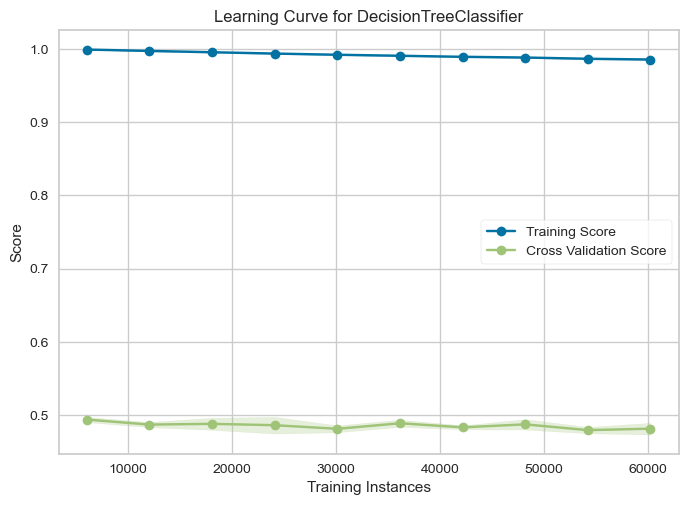

In [190]:
evaluation_bis(model_dt, X_train_feat_import, y_train, X_test__feat_import, scoring='recall')

Cette s√©lection n'a pas permis d'am√©liorer le score de notre recall, ni de mieux g√©n√©raliser notre mod√®le : il souffre toujours d'overfitting. 

## Avec la r√©gression logistique

CLASSIFICATION REPORT SUR LE TEST

              precision    recall  f1-score   support

           0       0.56      0.68      0.62     10093
           1       0.52      0.40      0.45      8898

    accuracy                           0.55     18991
   macro avg       0.54      0.54      0.53     18991
weighted avg       0.54      0.55      0.54     18991

Learning curve en cross validation pour le recall:


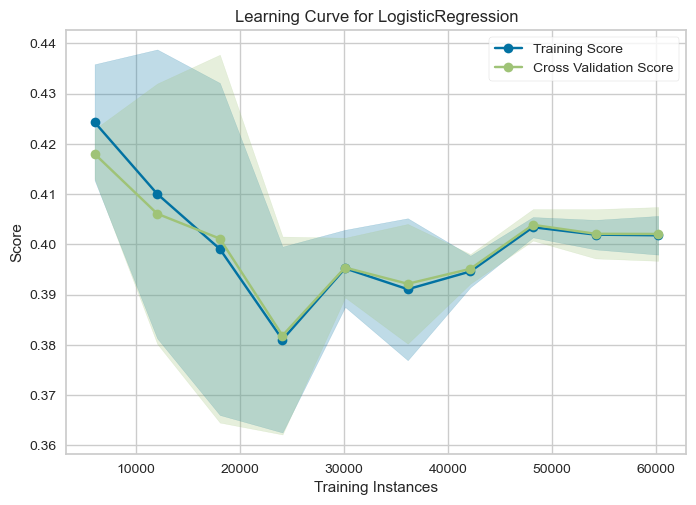

In [191]:
evaluation_bis(model_iter_2_lr, X_train_feat_import, y_train, X_test__feat_import, scoring='recall')

Le recall a baiss√© et la s√©lection des variables n'a pas permis d'endiguer l'underfitting. La learning curve suit une trajectoire singuli√®re au niveau du training et du validation set. Qu'est-ce que √ßa signifie exactement ? 
=> les r√©sultats sont mauvais, donc inutile de pr√©senter la learning curve lors de la pr√©sentation

# It√©ration 5 : am√©liorer le mod√®le gr√¢ce √† des algorithmes plus complexes : SGD Classifier & Random Decision Tree

Stochastic Gradient Descent Classifier pour lutter contre l'underfitiing

- Est plus puissant (lutte contre l'underfitting)
- Est plus recommand√© pour les dataset de grande taille
- Va permettre d'utiliser la Desente de Gradient Stochastique
- Dispose davantage d'hyperparam√®tres

Classifier Random Forest pour lutter contre l'overfitting
- Permet la r√©gularisation, il introduit une part de hasard suppl√©mentaire lors de la construction de l'arbre
- Cherche le compromis d'un biais plus √©lev√© en √©change d'une variance plus faible => meilleur mod√®le global
- Mesure facilement l'importance relative des variables


On repart sur un mod√®le avec toutes les variables s√©lectionn√©es de base et pr√©proc√©ss√©es. 

## Avec toutes les variables

### Sur le dataset initial

In [192]:
X_train.shape

(75283, 38)

In [194]:
X_test.shape

(18991, 38)

In [39]:
# On part sur un mod√®le non optimis√©, or l'avantage du SGD est qu'il est plus puissant avec les param√®tres optimis√©s. 

model_sgdc = SGDClassifier(random_state = 5)
model_rfc = RandomForestClassifier(random_state=5)

CLASSIFICATION REPORT SUR LE TEST

              precision    recall  f1-score   support

           0       0.55      0.89      0.68     10093
           1       0.57      0.17      0.26      8898

    accuracy                           0.55     18991
   macro avg       0.56      0.53      0.47     18991
weighted avg       0.56      0.55      0.48     18991

Learning curve en cross validation pour le recall:


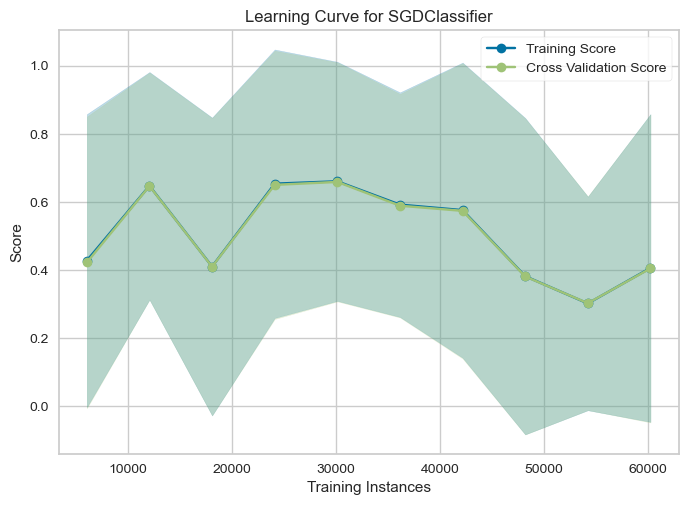

In [205]:
# Avec SGD Classifier

evaluation_bis(model_sgdc,  X_train, y_train, X_test, scoring='recall')

Score accuracy en cv : [0.47512785 0.50634256 0.54160855 0.48565356 0.55167375]
Score accuracy moyen en cv : 0.5120812555928985

Score recall en cv : [0.99177888 0.9112686  0.63387668 0.98058115 0.20697477]
Score recall moyen en cv : 0.744896016293865

Score precision en cv : [0.47143242 0.48572076 0.50870208 0.47628227 0.55810398]
Score precision moyen en cv : 0.5000483024440899

Score f1 en cv : [0.63908298 0.63367996 0.56443266 0.64114921 0.30196484]
Score f1 moyen en cv : 0.5560619304746768

Pour accuracy :


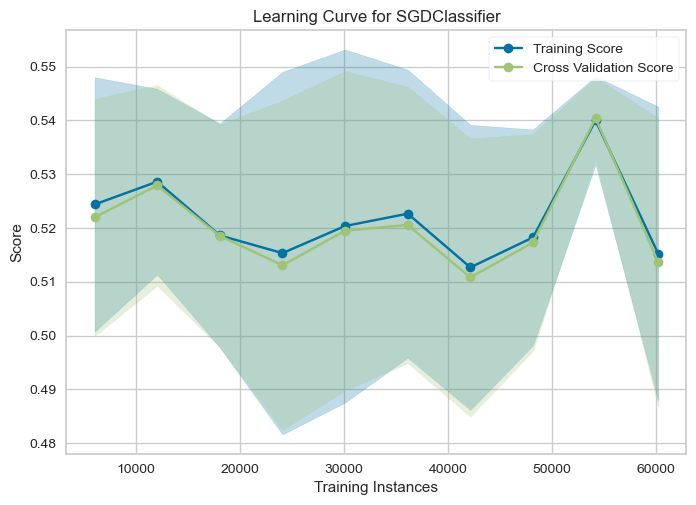

------------------------------------------------
Pour recall :


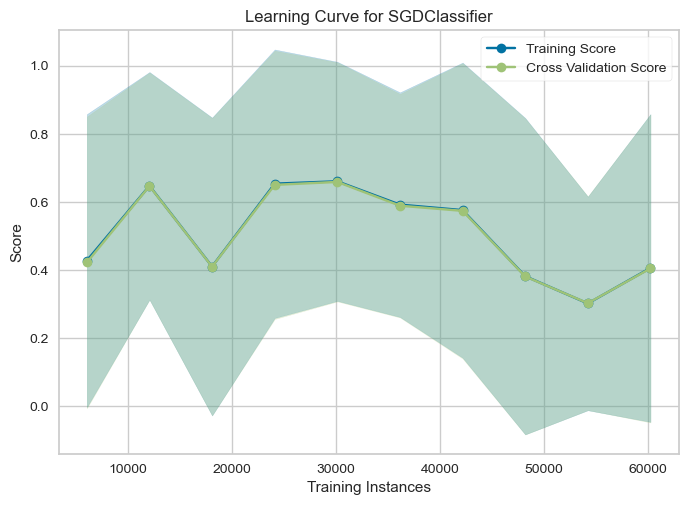

------------------------------------------------
Pour precision :


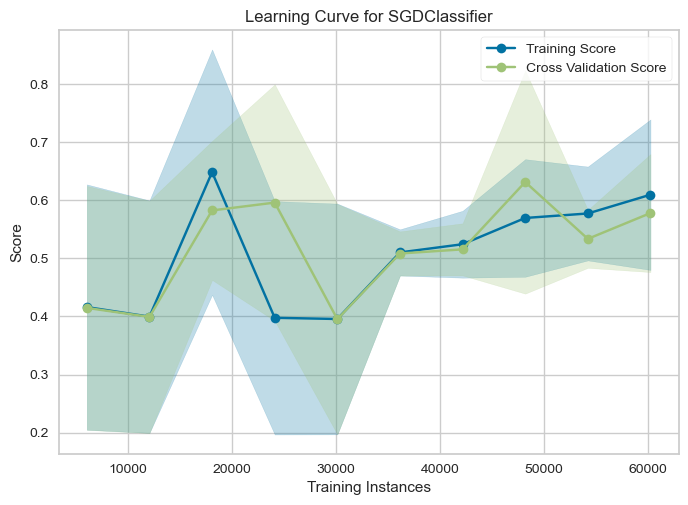

------------------------------------------------
Pour f1 :


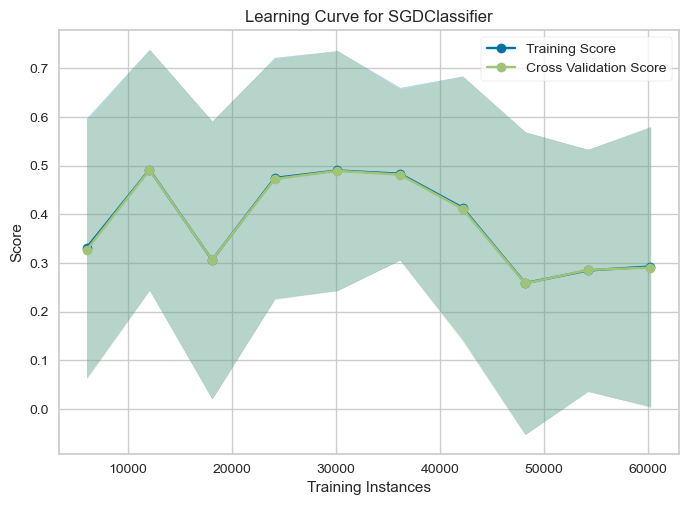

------------------------------------------------


In [210]:
evaluation_cv(model_sgdc,  X_train, y_train)

Les r√©sultats avec le SGD Classifier ne sont pas meilleurs (sauf la precision qui augmente un peu) mais le recall sur le test chute totalement alors que lorsqu'on y regarde de plus pr√®s, le Score recall moyen en cv est de 0.744896016293865. Cela pourrait supposer un bon score, or quand on zoome sur les 5 cv, on a des r√©sultats tr√®s variables (d'excellents √† tr√®s mauvais) : [0.99177888 0.9112686  0.63387668 0.98058115 0.20697477]. On le voit aussi gr√¢ce √† la grande variabilit√© autour des courbes qui montre que l'√©cart type au dessus et en dessous de la courbe est tr√®s √©lev√© => grande variance dans les donn√©es observ√©es. 

COMPRENDRE POURQUOI LES DEUX COURBES SE SUIVENT TOTALEMENT ???

CLASSIFICATION REPORT SUR LE TEST

              precision    recall  f1-score   support

           0       0.59      0.66      0.62     10093
           1       0.56      0.48      0.52      8898

    accuracy                           0.58     18991
   macro avg       0.57      0.57      0.57     18991
weighted avg       0.58      0.58      0.57     18991

Learning curve en cross validation pour le recall:


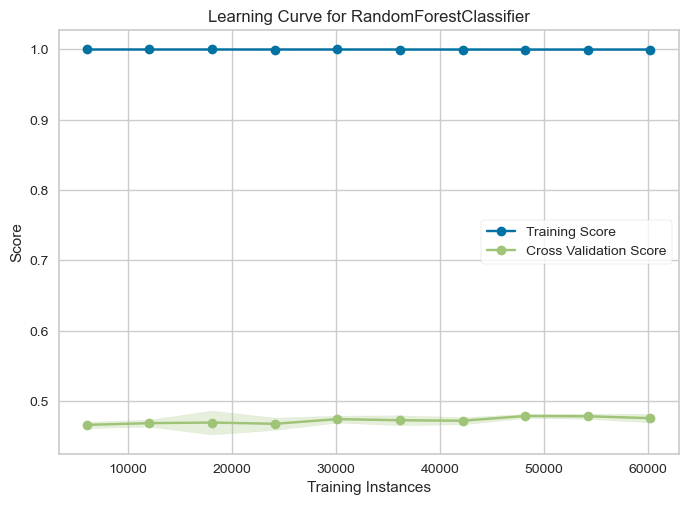

In [211]:
evaluation_bis(model_rfc,  X_train, y_train, X_test, scoring='recall')

Les r√©sultats avec le Random Forest sont meilleurs (autour des 0.5 pour l'ensemble des m√©triques) mais le mod√®le n'est pas robuste puisqu'en cross validation, le train montre un score de 1 et le validation score autour de 0.5, sans jamais converger. Nous sommes clairement dans un sc√©nario d'overfitting. Il est √©tonnant de constater que pour les mod√®les param√©triques de r√©gression, nous sommes en underfitting et que pour les arbres de d√©cision en overfitting. Il y a clairement quelque chose avec nos donn√©es qui pose probl√®me. 

Intuitivement, on a senti qu'il y avait quelque chose qui clochait dans les donn√©es => recherches (notamment sur le fait que les deux courbes de la learning curve pour les mod√®les param√©triques se suivaient parfaitement -> la piste √©tait les questions d'√©chantillonnage) et on a recherch√© du c√¥t√© des donn√©es et des mod√®les param√©triques. En repensant √† notre √©chantillon, on s'est rappel√© que certains patients avaient √©t√© hospitalis√©s plusieurs fois. Notre √©chantillon n'√©tait donc pas ind√©pendant (l'un des pr√©suppos√©s des mod√®les param√©triques). Nous allons donc tenter de supprimer ces "doublons" et de r√©-√©valuer nos mod√®les avec ce nouvel √©chantillon. 

In [197]:
# dict_of_models = {'RandomForest': RandomForestClassifier,
#                   'SGDClassifier' : SGDClassifier
#                  }

In [ ]:
# for name, model in dict_of_models.items():
#     print(name)
#     evaluation_bis(model, scoring = 'recall')

### Apr√®s suppression des duplicates pour avoir un √©chantillon repr√©sentatif et ind√©pendant

#### Preparation des donn√©es (nouvel √©chantillon)

Objectif : pour chaque patient, on prend sa premi√®re admission. 

In [7]:
def base_clean_dataset_drop_duplicate():
    '''Permet de r√©initialiser le dataset pr√©-nettoy√© √† chaque nouvelle it√©ration 
       Afin d'avoir un √©chantillon repr√©sentatif et ind√©pendant, on supprime les duplicates de patients
       (qui ont √©t√© admis plusieurs fois)
    '''
    data = pd.read_csv('diabetic_data_130US_hospital.csv', sep=';')
    data = data.sort_values(by=['patient_nbr','encounter_id'], ascending=True)
    data = data.drop_duplicates(subset='patient_nbr', keep='first')
    data = data.replace({'?' : np.nan}).replace({'Unknown/Invalid' : np.nan})
    data = data.replace({'readmitted' : {'NO' : 0, '>30' : 1, '<30' : 1}})
    data = data.drop(columns=['encounter_id', 'patient_nbr'])
    data = age_transform_to_numeric(data)
#     df = data.copy()
    return data

In [8]:
df_without_duplicate = base_clean_dataset_drop_duplicate()

In [9]:
df_without_duplicate.shape

(71518, 48)

En supprimant les duplicate de patient_nb, nous avons un dataset de base qui comprend d√©sormais 71518 exemples et 48 colonnes.  
Appliquons-lui les r√®gles de pre-processing d√©finies et mesurons de nouveau les nouveaux algorithmes. 

In [10]:
df_without_duplicate = df_without_duplicate[['num_lab_procedures','num_medications', 'number_diagnoses', 'time_in_hospital', 'age', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_3', 'medical_specialty', 'payer_code', 'race', 'gender', 'change', 'diabetesMed', 'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'pioglitazone', 'rosiglitazone', 'insulin', 'readmitted']]
df_without_duplicate.shape

(71518, 23)

In [12]:
trainset_without_duplicate, testset_without_duplicate = train_test_split(df_without_duplicate, test_size=0.2, random_state=5)
print('Train set :', trainset_without_duplicate.shape)
print('Test set :', testset_without_duplicate.shape)

Train set : (57214, 23)
Test set : (14304, 23)


In [34]:
X_train_3, y_train_3 = preprocessing(trainset_without_duplicate)
X_test_3, y_test_3 = preprocessing(testset_without_duplicate)
X_train_3.shape, y_train_3.shape, X_test_3.shape, y_test_3.shape

((52834, 38), (52834, 1), (13183, 38), (13183, 1))

In [79]:
# Point d'attention : avec le r√©-√©chantillonnage, notre target est plus d√©s√©quilibr√©e (ratio 60/40)

analyse_target(df_without_duplicate)

number     %
0   42985  60.1
1   28533  39.9

#### Evaluation des mod√®les : SGD & RandomForestC & RegLog

CLASSIFICATION REPORT SUR LE TEST

              precision    recall  f1-score   support

           0       0.63      0.68      0.66      7847
           1       0.47      0.41      0.44      5336

    accuracy                           0.57     13183
   macro avg       0.55      0.55      0.55     13183
weighted avg       0.57      0.57      0.57     13183

Learning curve en cross validation pour le recall:


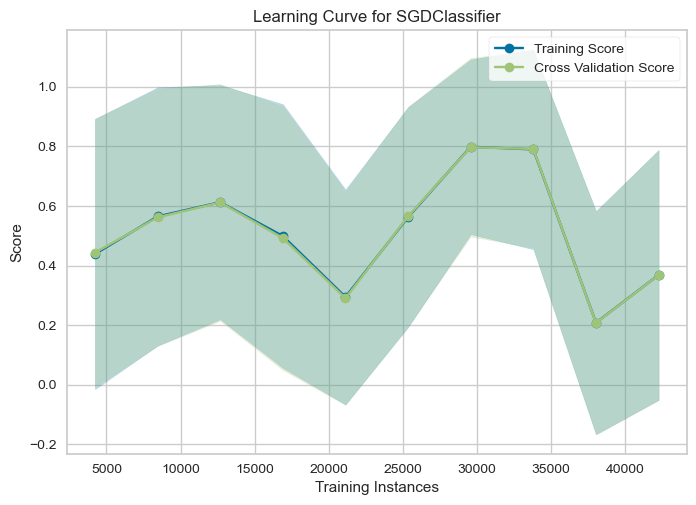

In [44]:
# Avec le Stochastic Gradient Descend Classifier 

evaluation_bis(model_sgdc,  X_train_3, y_train_3, X_test_3, y_test_3, scoring='recall')

La learning curve a toujours la m√™me allure, en revanche, le score recall s'est nettement am√©lior√©, passant de 0.17 √† 0.41, ainsi que l'accuracy (de 0.55 √† 0.57) et surtout le F1-score (de 0.26 √† 0.44). 

CLASSIFICATION REPORT SUR LE TEST

              precision    recall  f1-score   support

           0       0.63      0.79      0.70      7847
           1       0.50      0.30      0.38      5336

    accuracy                           0.60     13183
   macro avg       0.56      0.55      0.54     13183
weighted avg       0.58      0.60      0.57     13183

Learning curve en cross validation pour le recall:


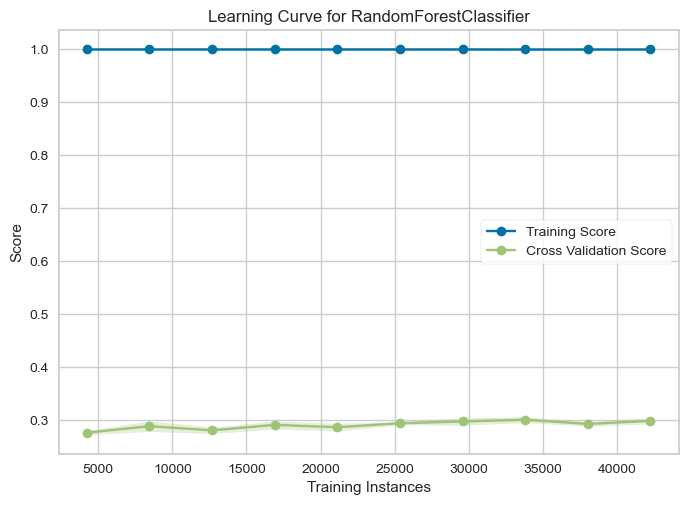

In [45]:
# Avec le Random Forest Classifier

evaluation_bis(model_rfc,  X_train_3, y_train_3, X_test_3, y_test_3, scoring='recall')

Les scores sont moins bons avec le Random Forest et le mod√®le souffre toujours autant d'overfitting. Ce qui est peut-√™tre pas √©tonnant car cet algorithme est peu sensible aux probl√©matiques d'√©chantillon. 
Seule l'accuracy s'est l√©g√®rement am√©lior√©e. 

CLASSIFICATION REPORT SUR LE TEST

              precision    recall  f1-score   support

           0       0.61      0.88      0.72      7847
           1       0.49      0.18      0.26      5336

    accuracy                           0.59     13183
   macro avg       0.55      0.53      0.49     13183
weighted avg       0.56      0.59      0.53     13183

Learning curve en cross validation pour le recall:


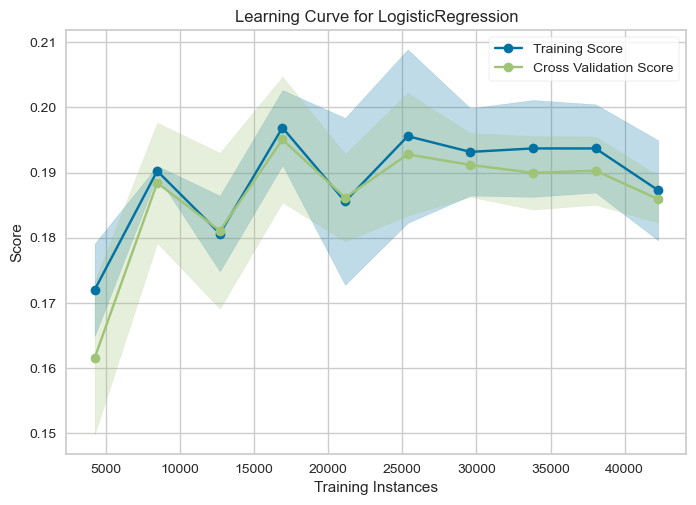

In [47]:
# Avec la Regression logistique

evaluation_bis(model_iter_2_lr,  X_train_3, y_train_3, X_test_3, y_test_3, scoring='recall')

Les r√©sultats en r√©gression logistique avec le r√©-enchantillonnage sont plus mauvais. Les scores sur le test en recall sont aussi mauvais qu'enn cross validation et ont tendance √† baisser √† mesure que nous ajoutons des donn√©es au mod√®le. 

### Interpr√©tation et axes d'am√©lioration 

Les r√©sultats du SGD apr√®s r√©√©chantillonnage et toutes les variables initialement s√©lectionn√©es sont meilleurs (on passe de 0.17 √† 0.41 sur le test). Le mod√®le souffre encore d'underfitting car les erreurs pour le recall restent grandes sur le train et le test. Notre mod√®le souffre de biais.  
On va avoir recours √† une autre solution : apporter des variables de meilleure qualit√© gr√¢ce cette fois-ci la s√©lection de features bas√©es sur le test d'Anova.  

Par ailleurs, √† noter que pour le moment l'algorithme qui donne de meilleurs r√©sultats est le Decision Tree (0.50 sur le recall) apr√®s EDA et avec tout l'√©chantillon. Mais souffre clairement d'overfitting donc est moins robuste. 

## En s√©lectionnant les variables gr√¢ce au SelectKBest 

On va utiliser le module SelectKBest de sklearn qui permet de faire de la s√©lection de variables en se basant sur des tests statistiques. Nous choisissons pour notre part le test Anova qui sert √† mesurer la variance entre plusieurs groupes (entre des variables cat√©gorielles et num√©riques). 


Pour essayer "d'assainir" nos donn√©es, nous allons tenter une autre technique de s√©lection de variable, le test Anova. 

### Selon SGD Classifier

On commence par √©valuer le mod√®le qui pour nous pour le moment est le plus robuste : le SGD Classifier apr√®s re-enchantillonnage et avec toutes les variables. On va tenter de lui donner des variables plus pertinentes. 

In [57]:
model_sgd_Kbest = make_pipeline(SelectKBest(f_classif, k=10), 
                       SGDClassifier(random_state = 5))

In [58]:
model_sgd_Kbest

Pipeline(steps=[('selectkbest', SelectKBest()),
                ('sgdclassifier', SGDClassifier(random_state=5))])

CLASSIFICATION REPORT SUR LE TEST

              precision    recall  f1-score   support

           0       0.71      0.13      0.22      7847
           1       0.42      0.92      0.58      5336

    accuracy                           0.45     13183
   macro avg       0.57      0.53      0.40     13183
weighted avg       0.59      0.45      0.36     13183

Learning curve en cross validation pour le recall:


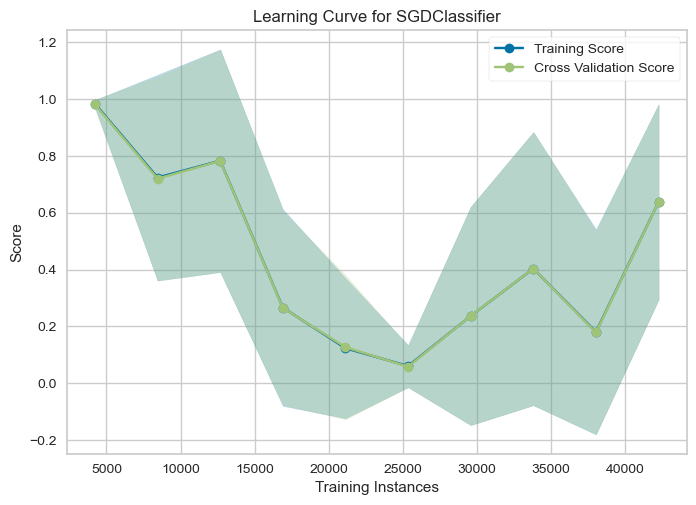

In [59]:
evaluation_bis(model_sgd_Kbest, X_train_3, y_train_3, X_test_3, y_test_3, scoring='recall')

**Interpr√©tation** : 92% des personnes qui ont √©t√© r√©admises ont √©t√© d√©tect√©es par notre mod√®le. Le r√©sultat est tr√®s bon, d'autant que notre √©valuation repose sur 5300 exemples, avec un F1 score de 0.58 honorable qui nous permet d'embarquer la precision. 

In [73]:
# Avec k=5 -> r√©sultats cata (recall = 0)
# Avec k=15 -> r√©sultats meilleurs du recall (de 0.92 √† 0.94) mais F1 score un peu moins bon (de 0.1 de diff√©rence)

model_sgd_Kbest_15 = make_pipeline(SelectKBest(f_classif, k=15), 
                       SGDClassifier(random_state = 5))

CLASSIFICATION REPORT SUR LE TEST

              precision    recall  f1-score   support

           0       0.69      0.09      0.16      7847
           1       0.41      0.94      0.57      5336

    accuracy                           0.44     13183
   macro avg       0.55      0.52      0.37     13183
weighted avg       0.58      0.44      0.33     13183

Learning curve en cross validation pour le recall:


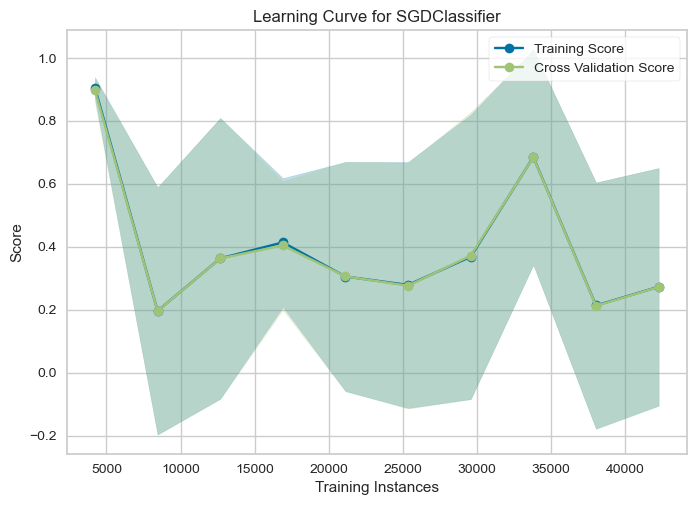

In [74]:
evaluation_bis(model_sgd_Kbest_15, X_train_3, y_train_3, X_test_3, y_test_3, scoring='recall')

In [62]:
# Tente avec la normalisation 

model_sgd_Kbest_normalize = make_pipeline(SelectKBest(f_classif, k=10), 
                       SGDClassifier(random_state = 5))

CLASSIFICATION REPORT SUR LE TEST

              precision    recall  f1-score   support

           0       0.71      0.13      0.22      7847
           1       0.42      0.92      0.58      5336

    accuracy                           0.45     13183
   macro avg       0.57      0.53      0.40     13183
weighted avg       0.59      0.45      0.36     13183

Learning curve en cross validation pour le recall:


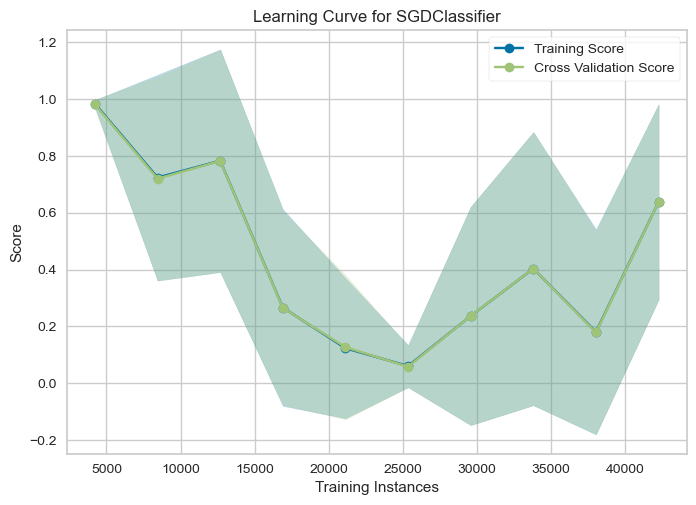

In [63]:
evaluation_bis(model_sgd_Kbest_normalize, X_train_3, y_train_3, X_test_3, y_test_3, scoring='recall')

**Interpretation** : le r√©sultat est moins bon en standardisant les donn√©es. 

### Selon le Decision Tree 

On re-examine le mod√®le avec le Decision Tree qui donnait de meilleurs r√©sultats qu'avec le RandomForest

In [65]:
# f_classif = On se base sur le test d'Anova
# k = nombre de features √† s√©lectionner 
# => on s√©lectionne les variables qui ont les liens les plus forts en test d'Anova entre nos variables et notre target 

model_dt_Kbest = make_pipeline(SelectKBest(f_classif, k=10), 
                       DecisionTreeClassifier(random_state=5))

CLASSIFICATION REPORT SUR LE TEST

              precision    recall  f1-score   support

           0       0.61      0.60      0.61      7847
           1       0.42      0.42      0.42      5336

    accuracy                           0.53     13183
   macro avg       0.51      0.51      0.51     13183
weighted avg       0.53      0.53      0.53     13183

Learning curve en cross validation pour le recall:


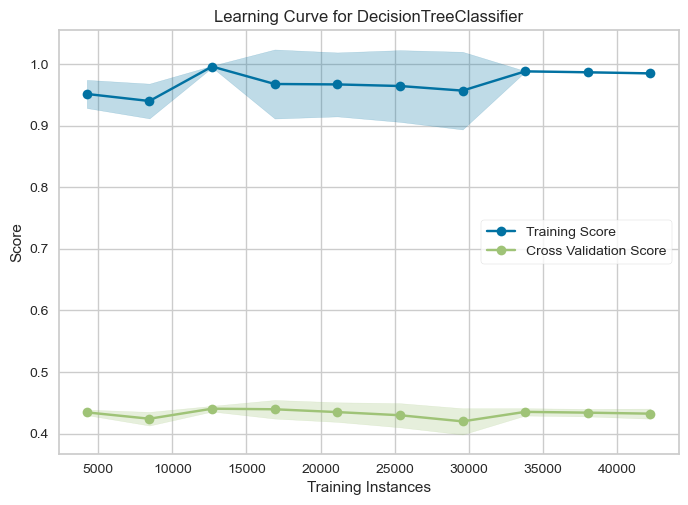

In [66]:
evaluation_bis(model_dt_Kbest, X_train_3, y_train_3, X_test_3, y_test_3, scoring='recall')

Le train apprend un peu moins bien mais mon mod√®le ne g√©n√©ralise toujours pas. Le score sur le validation test ne s'am√©liore pas √† mesure que nous ajoutons de la donn√©e.

### Identification des variables s√©lectionn√©es selon le K_best du SGD Classifier

In [76]:
model_sgd_Kbest[:-1].get_feature_names_out()

array(['num_lab_procedures', 'num_medications', 'number_diagnoses',
       'time_in_hospital', 'age', 'change', 'diabetesMed',
       'admission_source_transform_Urgences',
       'medical_specialty_transform_Autres',
       'payer_code_transform_Autres'], dtype=object)

# It√©ration 6 : optimiser les hyperparam√®tres du meilleur mod√®le s√©lectionn√©

On tente d'optimiser notre mod√®le le plus robuste : le SGD Classifier en K_best

## GridSearchCV

In [80]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [81]:
model_sgd_Kbest.get_params()

{'memory': None,
 'steps': [('selectkbest', SelectKBest()),
  ('sgdclassifier', SGDClassifier(random_state=5))],
 'verbose': False,
 'selectkbest': SelectKBest(),
 'sgdclassifier': SGDClassifier(random_state=5),
 'selectkbest__k': 10,
 'selectkbest__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>,
 'sgdclassifier__alpha': 0.0001,
 'sgdclassifier__average': False,
 'sgdclassifier__class_weight': None,
 'sgdclassifier__early_stopping': False,
 'sgdclassifier__epsilon': 0.1,
 'sgdclassifier__eta0': 0.0,
 'sgdclassifier__fit_intercept': True,
 'sgdclassifier__l1_ratio': 0.15,
 'sgdclassifier__learning_rate': 'optimal',
 'sgdclassifier__loss': 'hinge',
 'sgdclassifier__max_iter': 1000,
 'sgdclassifier__n_iter_no_change': 5,
 'sgdclassifier__n_jobs': None,
 'sgdclassifier__penalty': 'l2',
 'sgdclassifier__power_t': 0.5,
 'sgdclassifier__random_state': 5,
 'sgdclassifier__shuffle': True,
 'sgdclassifier__tol': 0.001,
 'sgdclassifier__validation_fraction

In [ ]:
model_SGD.get_params()

In [82]:
hyper_params = {
    'sgdclassifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
    'sgdclassifier__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge','perceptron'], 
    'sgdclassifier__penalty' :  ['l1', 'l2', 'elasticnet'],
    'sgdclassifier__learning_rate' : ['optimal', 'constant', 'invscaling', 'adaptive']
}

In [ ]:
evaluation_bis(model_dt_Kbest, X_train_3, y_train_3, X_test_3, y_test_3, scoring='recall')

In [86]:
# Avec le GridSearch

grid_2 = GridSearchCV(model_sgd_Kbest, hyper_params, scoring='recall', cv=4)
grid_2.fit(X_train_3, y_train_3)

print(grid_2.best_params_)

y_pred_3 = grid_2.predict(X_test_3)
print(classification_report(y_test_3, y_pred_3))

{'sgdclassifier__alpha': 0.01, 'sgdclassifier__learning_rate': 'optimal', 'sgdclassifier__loss': 'perceptron', 'sgdclassifier__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.71      0.13      0.22      7847
           1       0.42      0.92      0.58      5336

    accuracy                           0.45     13183
   macro avg       0.56      0.52      0.40     13183
weighted avg       0.59      0.45      0.36     13183



In [ ]:
# Avec le RandomizedSearch

# grid = RandomizedSearchCV(model_SGD, hyper_params, scoring='recall', cv=4,
#                           n_iter=40)

# grid.fit(X_train, y_train)
# print(grid.best_params_)

# y_pred = grid.predict(X_test)

# print(classification_report(y_test, y_pred))

In [87]:
grid_2.best_estimator_

Pipeline(steps=[('selectkbest', SelectKBest()),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.01, loss='perceptron', random_state=5))])

In [88]:
y_pred_best_params = grid_2.best_estimator_.decision_function(X_test_3)
y_pred_best_params

array([0.06722785, 0.02655758, 0.08264427, ..., 0.04253423, 0.01623121,
       0.17019594])

**Interpr√©tation** : L'optimisation des param√®tres n'a pas permis d'am√©liorer le score. On se contentera donc des r√©sultats par d√©faut. 

## Precision Recall Curve

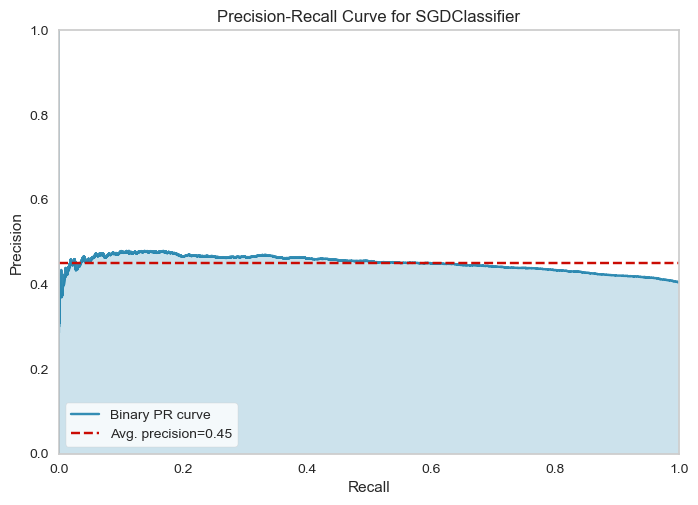

<AxesSubplot:title={'center':'Precision-Recall Curve for SGDClassifier'}, xlabel='Recall', ylabel='Precision'>

In [91]:
import matplotlib.pyplot as plt

# from yellowbrick.datasets import load_spam
# from sklearn.linear_model import RidgeClassifier
from yellowbrick.classifier import PrecisionRecallCurve
# from sklearn.model_selection import train_test_split as tts

# Load the dataset and split into train/test splits
# X, y = load_spam()

# X_train_3, X_test_3, y_train_3, y_test_3 = tts(
#     X, y, test_size=0.2, shuffle=True, random_state=0
# )

# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(model_sgd_Kbest)
viz.fit(X_train_3, y_train_3)
viz.score(X_test_3, y_test_3)
viz.show()

## Courbe ROC

In [94]:
visualizer = ROCAUC(grid_2.best_estimator_, classes=["non_rehospitalis√©", "rehospitalis√©"])

visualizer.fit(X_train_3, y_train_3)       
visualizer.score(X_test_3, y_test_3)      
visualizer.show() 

ModelError: no curves will be drawn; set binary=True.

# Mod√®le final : SGD Classifier sur l'ensemble du dataset

## Score & Pr√©diction avec le mod√®le final

On applique notre mod√®le sur l'ensemble du dataset avec les caract√©ristiques suivantes :  
- dataset √©chantillonn√© sans les duplicate patient_id
- s√©lection des variables les plus importantes selon Kbest Anova
- preprocessing
- s√©lection mod√®le avec les hyperparam√®tres optimis√©s et fit
- scoring & ypred
- enregistrement du mod√®le sous joblib

In [95]:
df_final = base_clean_dataset_drop_duplicate()

In [96]:
df_final = df_final[['num_lab_procedures', 'num_medications', 'number_diagnoses','time_in_hospital', 'age', 'change', 
                     'diabetesMed', 'admission_source_id', 'medical_specialty', 'payer_code', 'readmitted']]

In [98]:
def ordinal_encodage_final(df):
    ''' Encoder ordinalement (affecter un poids) aux variables s√©lectionn√©es
        @Retourne un df preprocess√©
    '''
    code = {'No': 0,
            'Yes': 1,
            'Ch': 1, 
            'None': 0,
            'Norm': 1,
            '>200': 2,
            '>300': 3,
            '>7': 2,
            '>8': 3,
            'Steady': 2,
            'Down': 1,
            'Up': 3        
           }

    for col in df[['change', 'diabetesMed']]:
        df.loc[:, col] = df[col].map(code)
    
    return df

In [101]:
def feature_engineering_final(df):
    '''Transformation des colonnes discharge_disposition_id, admission_source_id, diag_1, diag_3, medical_specialty
       et payer_code suite √† l'EDA
       @Return le df modifi√©
    '''
    # Transform
#     df['discharge_disposition_transform'] = df.apply(discharge_disposition_id_transform, axis=1)
    df['admission_source_transform'] = df.apply(admission_source_id_transform, axis=1)
#     df = diagnostic_transform(df)
    df['medical_specialty_transform'] = df.apply(medical_specialty_transform, axis=1)
    df['payer_code_transform'] = df.apply(payer_code_transform, axis=1)
    
    # Delete les colonnes inutiles
    df = df.drop(['admission_source_id', 'medical_specialty', 'payer_code'], axis = 1)
    
    return df

In [104]:
def dummies_encodage_final(df):
    '''Passe en get_dummies les variables cat√©gorielles indiqu√©es
       @Return le df modifi√©
    '''
    one_hot_df = pd.get_dummies(df, 
                                columns=['admission_source_transform', 'medical_specialty_transform', 'payer_code_transform'], 
                                drop_first=False)
    return one_hot_df

In [105]:
# Preprocessing 
def preprocessing_final(df):
    '''Actionne toutes les √©tapes de preprocessing
       @Return le dataset en s√©parant les variables de la target
    '''
    df = null_cleaning(df)
    df = remove_outliers_dataset(df)
    df = logarithme(df)
    df = ordinal_encodage_final(df)
    df = feature_engineering_final(df)
    df = dummies_encodage_final(df)
#     df = standardisation(df)
                         
    X = df.drop(columns=['readmitted'], axis=1)
    y = df[['readmitted']]
    
    return X, y

In [106]:
X_final, y_final = preprocessing_final(df_final)

In [108]:
X_final.shape

(68702, 21)

In [109]:
y_final.shape

(68702, 1)

In [119]:
model_final = SGDClassifier(random_state=5, alpha=0.01, learning_rate='optimal', loss='perceptron', penalty='l2')
model_final.fit(X_final, y_final)

SGDClassifier(alpha=0.01, loss='perceptron', random_state=5)

In [120]:
ypred_final = model_final.predict(X_final)
ypred_final

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [121]:
print(classification_report(y_final, ypred_final))

              precision    recall  f1-score   support

           0       0.73      0.15      0.26     41076
           1       0.42      0.92      0.58     27626

    accuracy                           0.46     68702
   macro avg       0.58      0.54      0.42     68702
weighted avg       0.61      0.46      0.39     68702



## Enregistrement du mod√®le sous joblib

In [125]:
joblib.dump(model_final, 'model_joblib_sgdc')

['model_joblib_sgdc']

In [127]:
model_joblib = joblib.load('model_joblib_sgdc')
model_joblib

SGDClassifier(alpha=0.01, loss='perceptron', random_state=5)

In [130]:
prediction_joblib = model_joblib.predict(X_final)
prediction_joblib

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

# Id√©es en vrac

- Pour le nettoyage des donn√©es : 
    - Voir comment g√©rer la colonne 'race' : pour le m√™me id = pas la m√™me race attribu√©e
- Feature engineering 
    - nb d'admissions par patient mais sera s√ªrement biais√© car fortement corr√©l√© √† la target : si le patient pr√©sente plusieurs lignes dans le dataset, c'est forc√©ment qu'il a √©t√© r√©admis. Il serait peut-√™tre plus int√©ressant de noter la diff√©rence de traitement entre les diff√©rentes admissions (augmentation de la glyc√©mie √† jeun/glyqu√©e, diff√©rence de traitement)
    - Gestion des 3 variables id encod√©es en ordinal mais qui sont en r√©alit√© des cat√©gorielles. Les passer en string puis les encoder en OneHot. Ex : baseline['admission_type_id'].map(lambda x: str(x))
- Gestion des variables qualitatives 
    - cross_tab Khi 2
- precision-recall curve : Apr√®s avoir trouv√© le bon mod√®le et r√©gler les hyperparam√®tres, g√©rer le bon threshold entre la precision et le recall grace au  : https://www.scikit-yb.org/en/latest/api/classifier/prcurve.html